# 背景

In [1]:
df_bad = pd.DataFrame({
    'index': ['2018-02', '2018-03','2018-04', '2018-05', '2018-06','2018-07','2018-08','2018-09','2018-10'], 
    'total_bad_ratio': [0.008, 0.01, 0.007,0.006, 0.008, 0.008,0.008, 0.009, 0.008],
    'qczj_bad_ratio': [0.007, 0.004, 0.004,0.003, 0.006, 0.003,0.006, 0.011, 0.02]
})

df_bad.index=df_bad['index']
df_bad=df_bad.drop(['index'],axis=1)

NameError: name 'pd' is not defined

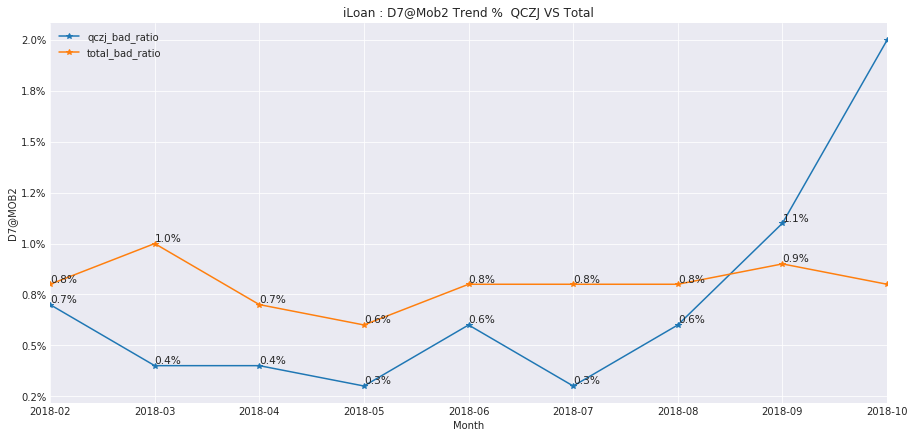

In [1903]:
# 逾期率趋势
ax=df_bad.plot(title='iLoan : D7@Mob2 Trend %  QCZJ VS Total',figsize=(15,7),grid=True,marker='*')

# 设置坐标轴
ax.set_ylabel('D7@MOB2') 
ax.set_xlabel('Month')

# Y坐标显示百分号
from matplotlib.ticker import FuncFormatter
def to_percent(temp, position):
    return '%.1f'%(100*temp) + '%'

# Y坐标显示百分号
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))


# 显示图例
for x, y in zip(range(8), df_bad['total_bad_ratio']):
    plt.text(x,y,'%.1f'%(y*100)+'%', ha='left', va='bottom', fontsize=10.5)


for x, y in zip(range(8), df_bad['qczj_bad_ratio']):
    plt.text(x,y,'%.1f'%(y*100)+'%', ha='left', va='bottom',fontsize=10.5)

**暴露两个问题 :**

* 自7月份以来, 逾期率直线上升

* 自9月份以来, 逾期率超过普惠整体平均逾期率

* 10月份逾期率突破2%, 是之家前9个月逾期率均值的3倍左右,是普惠整体逾期率的1.5倍

** ---------------- **

# 解决方案

* 第一阶段 : 以拒绝为主, 包括三部分

  * 黑名单拒绝
  
  * 模型拒绝
  
  * 规则拒绝


* 第二阶段 : 拒绝 + 召回, 在一阶段的基础上, 增加模型分放行和召回

  * 模型放行
  
  * 模型召回

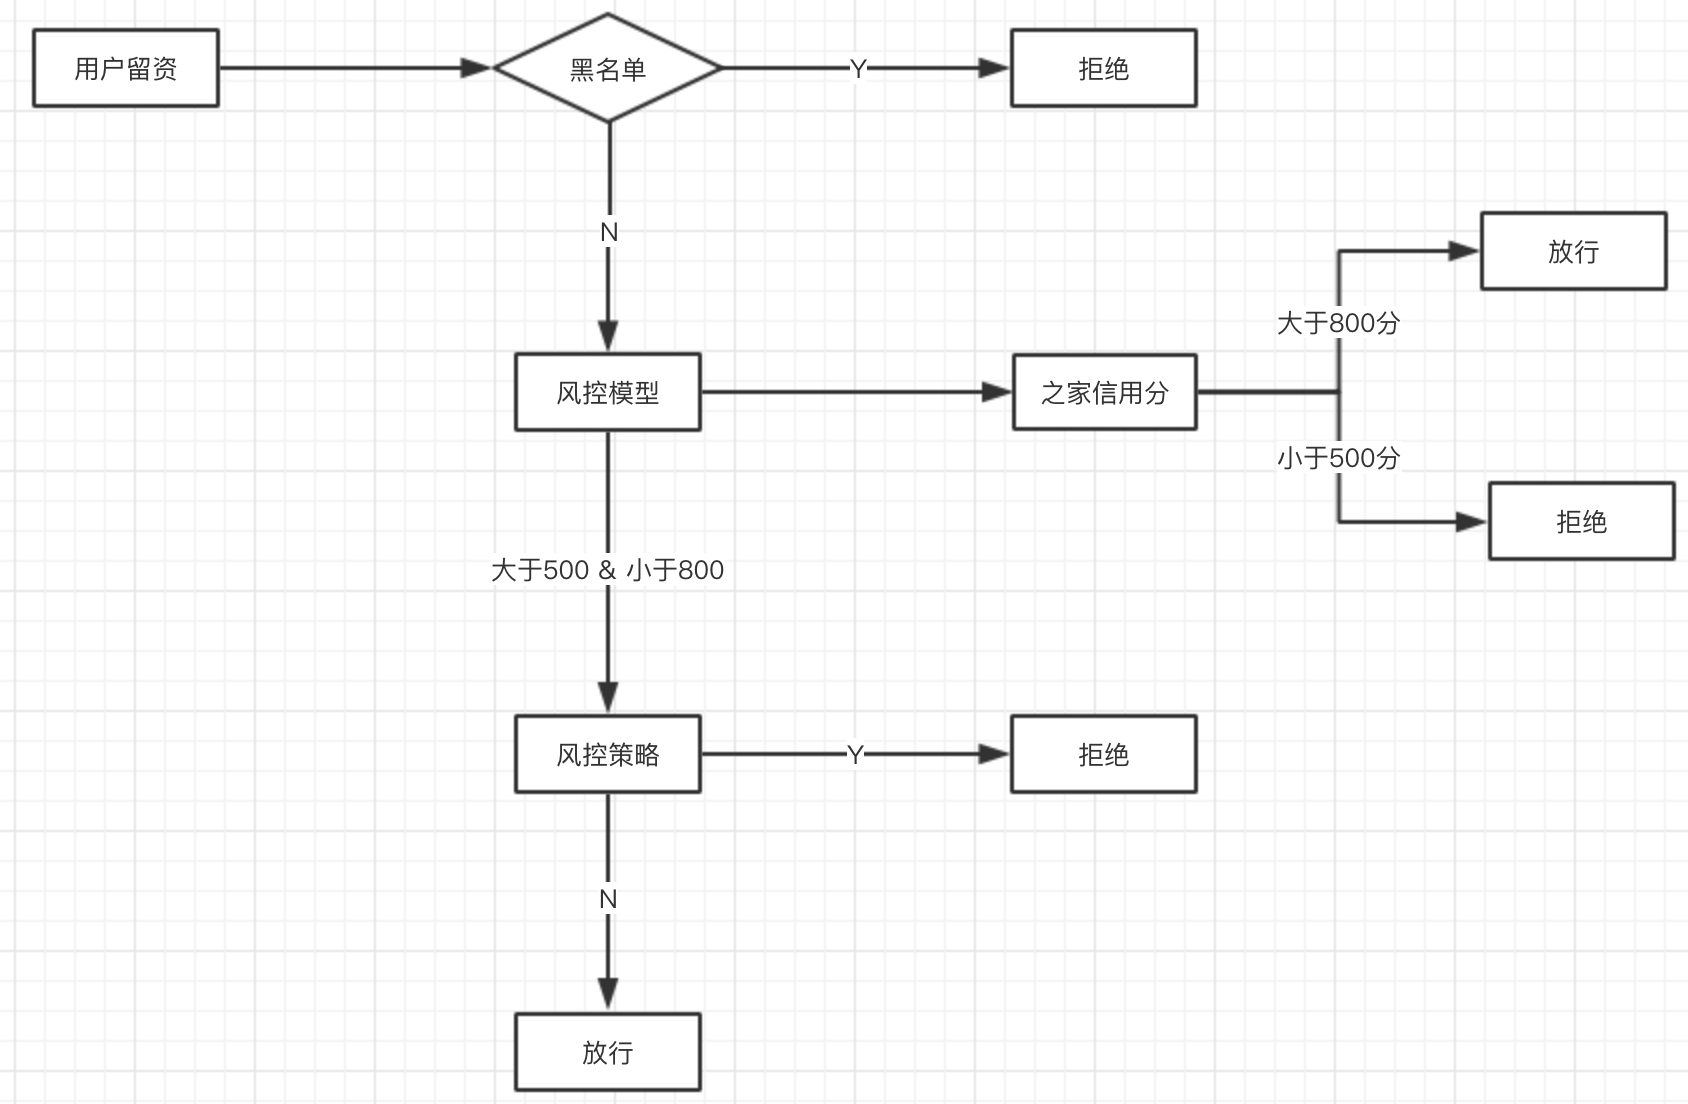

In [2027]:
# 解决方案
from IPython.display import Image
Image('aa.png',width=750)

## 黑名单体系

包括 :
* 设备黑名单(斯巴达设备号) : 基于逾期用户库, 凡是逾期用户登陆过的设备, 后续若产生新的线索, 直接拒绝
* GPS黑名单 : 基于逾期用户库, 基于逾期用户申请贷款时的GPS方圆5KM里内, 如若产生新的线索, 直接拒绝
* 机型黑名单 : 基于逾期用户库, 高逾期机型直接拉黑, 后续若产生新的线索, 直接拒绝


## 模型环节

* **800分及以上群体** : 用信人数占比6.1%; 逾期率为2.4%; 逾期人数占总逾期人数的3.6%


* **500分及以下群体** : 用信人数占比7.9%; 逾期率为7.9%; 逾期人数占总逾期人数的15%

## 规则体系

# 依赖的库

In [2]:
#!/usr/bin/python
#-*- coding:utf-8 -*-
import pandas as pd
import numpy as np
import xgboost as xgb
from scipy import stats
import os
import sys
import gc
import re
import datetime
import warnings

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn import preprocessing
from scipy.stats import skew, boxcox
import os

# from pyecharts import Bar
# import mpld3
# from mpld3 import plugins

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics

# 首先构建时间变量
from datetime import datetime, date, time
from time import strftime, localtime

#
from math import sin, asin, cos, radians, fabs, sqrt

In [3]:
# 显示中文
plt.rcParams['font.sans-serif']=['SimHei']

# 正常显示负号
plt.rcParams['axes.unicode_minus']=False

In [4]:
#显示所有列
pd.set_option('display.max_columns', 500)
#显示所有行
pd.set_option('display.max_rows', 100)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',10000)

# load data

## 基础数据

In [5]:
#1、设置异常值替换标准
na_values=['','NULL','NA','null','na','Na','-9999','-1','Infinity','NaN']

xpath='/Users/chaoyue/Documents/QC_iLoan/sos'
# xpath='/data/home/jiwenchao/model/iloan/data_set'
xfile_name='/name.txt'
#2、读取列名 :%s/\s*$//g
data_set_name=pd.read_table(xpath+xfile_name,
                         header=None,
                         names=['var_name']
                         )

xfile_data='/data_set.txt'
#3、加载数据
data_set_v0=pd.read_table(xpath+xfile_data,
                         sep='\t',
                         header=None,
                         na_values=na_values,
                         names=data_set_name['var_name'].values
                         )

In [6]:
# 画像的年龄换个名字, 避免跟身份证解析出的真实年龄字段混淆
data_set_v0.rename(columns={'age':'fig_age'}, inplace = True)
data_set_v0.head(1)

,mobile_hash,create_dt,create_time,create_unix_time,phone_md5,uuid,fig_age,marital_status,edu_level,loan_willing,mortgage,is_car_loan,violation_level,credit_level,customer_value,is_loan,lbs_cnt,price_max,price_min,diff_price,is_have,probability,is_predict,concen_degree,stage,convert_level,convert_prob,car_age_0,minage,maxage,credit_card_1_day,credit_card_3_day,credit_card_5_day,credit_card_7_day,credit_card_14_day,credit_card_30_day,credit_card_60_day,diff_inst_dt,diff_pass_dt,diff_active_dt,diff_pay_dt,cnt_active_1_day,dist_act_platform_1_day,dist_dt_1_day,cnt_jxd_1_day,cnt_chexian_1_day,cnt_daik_page_1_day,cnt_active_3_day,dist_act_platform_3_day,dist_dt_3_day,cnt_jxd_3_day,cnt_chexian_3_day,cnt_daik_page_3_day,cnt_active_5_day,dist_act_platform_5_day,dist_dt_5_day,cnt_jxd_5_day,cnt_chexian_5_day,cnt_daik_page_5_day,cnt_active_7_day,dist_act_platform_7_day,dist_dt_7_day,cnt_jxd_7_day,cnt_chexian_7_day,cnt_daik_page_7_day,cnt_active_14_day,dist_act_platform_14_day,dist_dt_14_day,cnt_jxd_14_day,cnt_chexian_14_day,cnt_daik_page_14_day,cnt_active_30_day,dist_act_platform_30_day,dist_dt_30_day,cnt_jxd_30_day,cnt_chexian_30_day,cnt_daik_page_30_day,cnt_queryword_1_day,cnt_daik_1_day,cnt_lix_1_day,cnt_shouf_1_day,cnt_qian_1_day,cnt_hfh6_1_day,cnt_dz_1_day,cnt_kll_1_day,cnt_sy_1_day,cnt_yg_1_day,cnt_ly_1_day,cnt_yx_1_day,cnt_bc_1_day,cnt_mt_1_day,cnt_kmr_1_day,cnt_pst_1_day,cnt_bm3_1_day,cnt_ft_1_day,cnt_p_dz_1_day,cnt_p_kll_1_day,cnt_p_sy_1_day,cnt_p_yg_1_day,cnt_p_ly_1_day,cnt_p_yx_1_day,cnt_p_bc_1_day,cnt_p_mt_1_day,cnt_p_kmr_1_day,cnt_p_pst_1_day,cnt_p_bm3_1_day,cnt_p_ft_1_day,cnt_p_daik_1_day,cnt_p_lix_1_day,cnt_p_shouf_1_day,cnt_p_qian_1_day,cnt_p_hfh6_1_day,dist_platform_1_day,dist_querydt_1_day,cnt_queryword_3_day,cnt_daik_3_day,cnt_lix_3_day,cnt_shouf_3_day,cnt_qian_3_day,cnt_hfh6_3_day,cnt_dz_3_day,cnt_kll_3_day,cnt_sy_3_day,cnt_yg_3_day,cnt_ly_3_day,cnt_yx_3_day,cnt_bc_3_day,cnt_mt_3_day,cnt_kmr_3_day,cnt_pst_3_day,cnt_bm3_3_day,cnt_ft_3_day,cnt_p_dz_3_day,cnt_p_kll_3_day,cnt_p_sy_3_day,cnt_p_yg_3_day,cnt_p_ly_3_day,cnt_p_yx_3_day,cnt_p_bc_3_day,cnt_p_mt_3_day,cnt_p_kmr_3_day,cnt_p_pst_3_day,cnt_p_bm3_3_day,cnt_p_ft_3_day,cnt_p_daik_3_day,cnt_p_lix_3_day,cnt_p_shouf_3_day,cnt_p_qian_3_day,cnt_p_hfh6_3_day,dist_platform_3_day,dist_querydt_3_day,cnt_queryword_5_day,cnt_daik_5_day,cnt_lix_5_day,cnt_shouf_5_day,cnt_qian_5_day,cnt_hfh6_5_day,cnt_dz_5_day,cnt_kll_5_day,cnt_sy_5_day,cnt_yg_5_day,cnt_ly_5_day,cnt_yx_5_day,cnt_bc_5_day,cnt_mt_5_day,cnt_kmr_5_day,cnt_pst_5_day,cnt_bm3_5_day,cnt_ft_5_day,cnt_p_dz_5_day,cnt_p_kll_5_day,cnt_p_sy_5_day,cnt_p_yg_5_day,cnt_p_ly_5_day,cnt_p_yx_5_day,cnt_p_bc_5_day,cnt_p_mt_5_day,cnt_p_kmr_5_day,cnt_p_pst_5_day,cnt_p_bm3_5_day,cnt_p_ft_5_day,cnt_p_daik_5_day,cnt_p_lix_5_day,cnt_p_shouf_5_day,cnt_p_qian_5_day,cnt_p_hfh6_5_day,dist_platform_5_day,dist_querydt_5_day,cnt_queryword_7_day,cnt_daik_7_day,cnt_lix_7_day,cnt_shouf_7_day,cnt_qian_7_day,cnt_hfh6_7_day,cnt_dz_7_day,cnt_kll_7_day,cnt_sy_7_day,cnt_yg_7_day,cnt_ly_7_day,cnt_yx_7_day,cnt_bc_7_day,cnt_mt_7_day,cnt_kmr_7_day,cnt_pst_7_day,cnt_bm3_7_day,cnt_ft_7_day,cnt_p_dz_7_day,cnt_p_kll_7_day,cnt_p_sy_7_day,cnt_p_yg_7_day,cnt_p_ly_7_day,cnt_p_yx_7_day,cnt_p_bc_7_day,cnt_p_mt_7_day,cnt_p_kmr_7_day,cnt_p_pst_7_day,cnt_p_bm3_7_day,cnt_p_ft_7_day,cnt_p_daik_7_day,cnt_p_lix_7_day,cnt_p_shouf_7_day,cnt_p_qian_7_day,cnt_p_hfh6_7_day,dist_platform_7_day,dist_querydt_7_day,cnt_queryword_14_day,cnt_daik_14_day,cnt_lix_14_day,cnt_shouf_14_day,cnt_qian_14_day,cnt_hfh6_14_day,cnt_dz_14_day,cnt_kll_14_day,cnt_sy_14_day,cnt_yg_14_day,cnt_ly_14_day,cnt_yx_14_day,cnt_bc_14_day,cnt_mt_14_day,cnt_kmr_14_day,cnt_pst_14_day,cnt_bm3_14_day,cnt_ft_14_day,cnt_p_dz_14_day,cnt_p_kll_14_day,cnt_p_sy_14_day,cnt_p_yg_14_day,cnt_p_ly_14_day,cnt_p_yx_14_day,cnt_p_bc_14_day,cnt_p_mt_14_day,cnt_p_kmr_14_day,cnt_p_pst_14_day,cnt_p_bm3_14_day,cnt_p_ft_14_day,cnt_p_daik_14_day,cnt_p_lix_14_day,cnt_p_shouf_14_day,cnt_p_qian_14_day,cnt_p_hfh6_14_day,dist_platform_14_day,dist_

## 标签数据

In [7]:
data_y=pd.read_table(xpath+'/is_over_hash.csv',sep=',')
data_y.columns=['account_id','mobile_hash','y_tag']
data_y.head(1)

,account_id,mobile_hash,y_tag
0,rRw1DEL94scgbrIa5tbJIg,f54f26fa90367428d002c09028a137ef18e5d63e7a44d4bd699872c073207c24,1


## 申请行为标签

In [8]:
data_apply=pd.read_csv('i_data.txt',sep='\t')
data_apply.columns=['mobile_hash'     
,'create_dt'     
,'create_time'     
,'create_unix_time'
,'device_id'     
,'machine_sn' 
,'latitude'      
,'longitude'     
,'gps_city'        
,'tel_city'        
,'mobile_brand']
data_apply.head(1)

,mobile_hash,create_dt,create_time,create_unix_time,device_id,machine_sn,latitude,longitude,gps_city,tel_city,mobile_brand
0,d31152684e6787154507cd717d794903a86dd961a467c20fffe98cf65a2b4617,2018-01-01,2018-01-01 00:17:33,1514737053,b054deb4,NaN,29.525239,106.576826,重庆市,NaN,vivo


In [9]:
# 验证GPS是否为空
print data_apply['longitude'].isnull().sum()

# 验证tel_city是否为空
print data_apply['tel_city'].isnull().sum()

0
32819


In [10]:
# 删除时间字段
data_apply.drop(['create_dt','create_time','create_unix_time'], axis=1, inplace=True)
data_apply.head(1)

,mobile_hash,device_id,machine_sn,latitude,longitude,gps_city,tel_city,mobile_brand
0,d31152684e6787154507cd717d794903a86dd961a467c20fffe98cf65a2b4617,b054deb4,NaN,29.525239,106.576826,重庆市,NaN,vivo


## GPS

### GPS码表

In [11]:
# 加载城市码表
city_index = pd.read_table('city_index.txt', sep = '\t')

In [12]:
# 删除gps_city字段中的 '市' 字段，替换为空值
data_apply.gps_city.replace(to_replace = '市', value = '', inplace = True, regex = True)
gps_city_idx = city_index.rename_axis({'city': 'gps_city', 'index': 'gps_city_idx'}, axis='columns')

# 匹配城市码表
data_apply = pd.merge(data_apply, gps_city_idx, on = 'gps_city', how = 'left')


In [13]:
data_apply.shape

(33745, 9)

### GPS省市

In [13]:
# 导入信用分数据
gps_city_province=pd.read_csv('gps_sf.txt',sep='\t')
gps_city_province.columns=['gps_city','gps_province']
gps_city_province.gps_province.replace(to_replace = '市', value = '', inplace = True, regex = True)
gps_city_province.gps_province.replace(to_replace = '省', value = '', inplace = True, regex = True)
gps_city_province.head()

,gps_city,gps_province
0,重庆,重庆
1,开封,河南
2,朝阳,辽宁
3,扬州,江苏
4,保定,河北


In [14]:
# 匹配
data_apply=data_apply.merge(gps_city_province,on='gps_city')
data_apply.head()

,mobile_hash,device_id,machine_sn,latitude,longitude,gps_city,tel_city,mobile_brand,gps_city_idx,gps_province
0,d31152684e6787154507cd717d794903a86dd961a467c20fffe98cf65a2b4617,b054deb4,NaN,29.525239,106.576826,重庆,NaN,vivo,1.5,重庆
1,41049aa7465950f6d7cd8924a13e4626c28234f3cb8eb87a431aef7ba4c291c7,74cbd4e7,NaN,29.439176,106.476922,重庆,重庆,vivo,1.5,重庆
2,cd0339e5f4ff3e669d0d0e1aba53a1fc309cae967d1fa3a472c5e110ca465b03,830a4e9f,NaN,29.166158,107.091125,重庆,NaN,vivo,1.5,重庆
3,643c199ab1cb6fbd4633d42348c39b5a661a94e12c29245ca4854e08d0d42aa3,1F84B793-5261-4CD0-A64F-2051AF35644D,e23ef5ba262eb11842cf20f7eeaa8683bcad5947,28.720668,106.772279,重庆,NaN,apple,1.5,重庆
4,0cfac9789117922ba71d486afd6e72f89074d1c18aa95fc7f0131b0661c6961d,30BDC368-A4F0-416F-B48A-49DADFDAEADA,7678db6a9b1cc7256587ea66a4089f31e5caea71,29.563754,106.585589,重庆,NaN,apple,1.5,重庆


In [15]:
data_apply.shape

(33737, 10)

## tel_city

In [16]:
# 加载城市码表
city_index = pd.read_table('city_index.txt', sep = '\t')

# 删除gps_city字段中的 '市' 字段，替换为空值
data_apply.tel_city.replace(to_replace = '市', value = '', inplace = True, regex = True)
tel_city_idx = city_index.rename_axis({'city': 'tel_city', 'index': 'tel_city_idx'}, axis='columns')

# 匹配城市码表
data_apply = pd.merge(data_apply, tel_city_idx, on = 'tel_city', how = 'left')


## 信用分

In [17]:
# 导入信用分数据
data_credit_score=pd.read_csv('iloan_score_v2.txt',sep=',')
data_credit_score.columns=['mobile_hash','score_1','score_2']
data_credit_score.head(1)

,mobile_hash,score_1,score_2
0,000223184d00256e5de3a0115d525895c47f4a9804e3cee3484fbf6dffd6f6b0,0.028731,716


## Y标签

In [18]:
data_set_v1=data_apply.merge(data_y,on='mobile_hash',how='left')
data_set_v1['y_tag']=data_set_v1['y_tag'].fillna(0)
data_set_v1.head(1)

,mobile_hash,device_id,machine_sn,latitude,longitude,gps_city,tel_city,mobile_brand,gps_city_idx,gps_province,tel_city_idx,account_id,y_tag
0,d31152684e6787154507cd717d794903a86dd961a467c20fffe98cf65a2b4617,b054deb4,NaN,29.525239,106.576826,重庆,NaN,vivo,1.5,重庆,NaN,NaN,0.0


## 整合XY宽表

In [19]:
data_set_v2=data_set_v0.merge(data_set_v1,on='mobile_hash',how='left')
data_set_v2.head(1)

,mobile_hash,create_dt,create_time,create_unix_time,phone_md5,uuid,fig_age,marital_status,edu_level,loan_willing,mortgage,is_car_loan,violation_level,credit_level,customer_value,is_loan,lbs_cnt,price_max,price_min,diff_price,is_have,probability,is_predict,concen_degree,stage,convert_level,convert_prob,car_age_0,minage,maxage,credit_card_1_day,credit_card_3_day,credit_card_5_day,credit_card_7_day,credit_card_14_day,credit_card_30_day,credit_card_60_day,diff_inst_dt,diff_pass_dt,diff_active_dt,diff_pay_dt,cnt_active_1_day,dist_act_platform_1_day,dist_dt_1_day,cnt_jxd_1_day,cnt_chexian_1_day,cnt_daik_page_1_day,cnt_active_3_day,dist_act_platform_3_day,dist_dt_3_day,cnt_jxd_3_day,cnt_chexian_3_day,cnt_daik_page_3_day,cnt_active_5_day,dist_act_platform_5_day,dist_dt_5_day,cnt_jxd_5_day,cnt_chexian_5_day,cnt_daik_page_5_day,cnt_active_7_day,dist_act_platform_7_day,dist_dt_7_day,cnt_jxd_7_day,cnt_chexian_7_day,cnt_daik_page_7_day,cnt_active_14_day,dist_act_platform_14_day,dist_dt_14_day,cnt_jxd_14_day,cnt_chexian_14_day,cnt_daik_page_14_day,cnt_active_30_day,dist_act_platform_30_day,dist_dt_30_day,cnt_jxd_30_day,cnt_chexian_30_day,cnt_daik_page_30_day,cnt_queryword_1_day,cnt_daik_1_day,cnt_lix_1_day,cnt_shouf_1_day,cnt_qian_1_day,cnt_hfh6_1_day,cnt_dz_1_day,cnt_kll_1_day,cnt_sy_1_day,cnt_yg_1_day,cnt_ly_1_day,cnt_yx_1_day,cnt_bc_1_day,cnt_mt_1_day,cnt_kmr_1_day,cnt_pst_1_day,cnt_bm3_1_day,cnt_ft_1_day,cnt_p_dz_1_day,cnt_p_kll_1_day,cnt_p_sy_1_day,cnt_p_yg_1_day,cnt_p_ly_1_day,cnt_p_yx_1_day,cnt_p_bc_1_day,cnt_p_mt_1_day,cnt_p_kmr_1_day,cnt_p_pst_1_day,cnt_p_bm3_1_day,cnt_p_ft_1_day,cnt_p_daik_1_day,cnt_p_lix_1_day,cnt_p_shouf_1_day,cnt_p_qian_1_day,cnt_p_hfh6_1_day,dist_platform_1_day,dist_querydt_1_day,cnt_queryword_3_day,cnt_daik_3_day,cnt_lix_3_day,cnt_shouf_3_day,cnt_qian_3_day,cnt_hfh6_3_day,cnt_dz_3_day,cnt_kll_3_day,cnt_sy_3_day,cnt_yg_3_day,cnt_ly_3_day,cnt_yx_3_day,cnt_bc_3_day,cnt_mt_3_day,cnt_kmr_3_day,cnt_pst_3_day,cnt_bm3_3_day,cnt_ft_3_day,cnt_p_dz_3_day,cnt_p_kll_3_day,cnt_p_sy_3_day,cnt_p_yg_3_day,cnt_p_ly_3_day,cnt_p_yx_3_day,cnt_p_bc_3_day,cnt_p_mt_3_day,cnt_p_kmr_3_day,cnt_p_pst_3_day,cnt_p_bm3_3_day,cnt_p_ft_3_day,cnt_p_daik_3_day,cnt_p_lix_3_day,cnt_p_shouf_3_day,cnt_p_qian_3_day,cnt_p_hfh6_3_day,dist_platform_3_day,dist_querydt_3_day,cnt_queryword_5_day,cnt_daik_5_day,cnt_lix_5_day,cnt_shouf_5_day,cnt_qian_5_day,cnt_hfh6_5_day,cnt_dz_5_day,cnt_kll_5_day,cnt_sy_5_day,cnt_yg_5_day,cnt_ly_5_day,cnt_yx_5_day,cnt_bc_5_day,cnt_mt_5_day,cnt_kmr_5_day,cnt_pst_5_day,cnt_bm3_5_day,cnt_ft_5_day,cnt_p_dz_5_day,cnt_p_kll_5_day,cnt_p_sy_5_day,cnt_p_yg_5_day,cnt_p_ly_5_day,cnt_p_yx_5_day,cnt_p_bc_5_day,cnt_p_mt_5_day,cnt_p_kmr_5_day,cnt_p_pst_5_day,cnt_p_bm3_5_day,cnt_p_ft_5_day,cnt_p_daik_5_day,cnt_p_lix_5_day,cnt_p_shouf_5_day,cnt_p_qian_5_day,cnt_p_hfh6_5_day,dist_platform_5_day,dist_querydt_5_day,cnt_queryword_7_day,cnt_daik_7_day,cnt_lix_7_day,cnt_shouf_7_day,cnt_qian_7_day,cnt_hfh6_7_day,cnt_dz_7_day,cnt_kll_7_day,cnt_sy_7_day,cnt_yg_7_day,cnt_ly_7_day,cnt_yx_7_day,cnt_bc_7_day,cnt_mt_7_day,cnt_kmr_7_day,cnt_pst_7_day,cnt_bm3_7_day,cnt_ft_7_day,cnt_p_dz_7_day,cnt_p_kll_7_day,cnt_p_sy_7_day,cnt_p_yg_7_day,cnt_p_ly_7_day,cnt_p_yx_7_day,cnt_p_bc_7_day,cnt_p_mt_7_day,cnt_p_kmr_7_day,cnt_p_pst_7_day,cnt_p_bm3_7_day,cnt_p_ft_7_day,cnt_p_daik_7_day,cnt_p_lix_7_day,cnt_p_shouf_7_day,cnt_p_qian_7_day,cnt_p_hfh6_7_day,dist_platform_7_day,dist_querydt_7_day,cnt_queryword_14_day,cnt_daik_14_day,cnt_lix_14_day,cnt_shouf_14_day,cnt_qian_14_day,cnt_hfh6_14_day,cnt_dz_14_day,cnt_kll_14_day,cnt_sy_14_day,cnt_yg_14_day,cnt_ly_14_day,cnt_yx_14_day,cnt_bc_14_day,cnt_mt_14_day,cnt_kmr_14_day,cnt_pst_14_day,cnt_bm3_14_day,cnt_ft_14_day,cnt_p_dz_14_day,cnt_p_kll_14_day,cnt_p_sy_14_day,cnt_p_yg_14_day,cnt_p_ly_14_day,cnt_p_yx_14_day,cnt_p_bc_14_day,cnt_p_mt_14_day,cnt_p_kmr_14_day,cnt_p_pst_14_day,cnt_p_bm3_14_day,cnt_p_ft_14_day,cnt_p_daik_14_day,cnt_p_lix_14_day,cnt_p_shouf_14_day,cnt_p_qian_14_day,cnt_p_hfh6_14_day,dist_platform_14_day,dist_

In [20]:
data_set_v2.shape

(33750, 379)

## 实名数据

In [21]:
# 导入信用分数据
# 不引入银行名称'bank_code'
data_real_name=pd.read_csv('real_name_data.txt',sep='\t',names=['mobile_hash','province_id','city_id','country_id','age','sex','card_id_6','card_id_10','bank_name','bank_code'])
data_real_name=data_real_name[['mobile_hash','province_id','city_id','country_id','age','sex']].drop_duplicates()
# data_real_name=data_real_name.reset_index()
data_real_name.head(1)


,mobile_hash,province_id,city_id,country_id,age,sex
0,d31152684e6787154507cd717d794903a86dd961a467c20fffe98cf65a2b4617,51.0,5116.0,511623.0,28.0,1


In [22]:
data_real_name.shape

(33409, 6)

In [23]:
# 99%的匹配度, 共计300余个空的匹配不上
data_real_name=data_real_name.fillna(0)
data_real_name['city_id']=data_real_name['city_id'].astype(int)
data_real_name['province_id']=data_real_name['province_id'].astype(int)
data_real_name['country_id']=data_real_name['country_id'].astype(int)
data_real_name['age']=data_real_name['age'].astype(int)
data_real_name['sex']=data_real_name['sex'].astype(int)
data_real_name.head()

,mobile_hash,province_id,city_id,country_id,age,sex
0,d31152684e6787154507cd717d794903a86dd961a467c20fffe98cf65a2b4617,51,5116,511623,28,1
1,3b542aef0005de7faaaf093e0f277fae01d92c6f2604f6b04cb22ff2124c47c9,41,4102,410203,34,1
2,e879849c8c0524bde7439f5cc142a74b3bcea196a804f2ac67aef7b410bded69,12,1202,120221,26,1
4,6f0ddc44cc0dc47fb6fcfc033f9bf31d5326d72194989afae90547c30ec95301,32,3210,321088,39,1
5,ba9a696c37742aa8e68fd050bc712a818fb906b924cbfb94ffc2821cf5d80926,13,1306,130628,30,1


### 籍贯省

In [24]:
# 身份证码表
id_index=pd.read_csv('id_1_2.txt',sep=',',header=None)
id_index.columns=['province_id','rn_province']
id_index.head()

,province_id,rn_province
0,11,北京
1,31,上海
2,41,河南
3,51,四川
4,64,宁夏


### 籍贯市

In [25]:
# 身份证码表
id_city_index=pd.read_csv('id_city_1.txt',sep='\t',header=None)
id_city_index.columns=['city_id','rn_city']
id_city_index['city_id']=id_city_index['city_id'].astype(int)
id_city_index.head()


,city_id,rn_city
0,1100,北京
1,1200,天津
2,1301,石家庄
3,1302,唐山
4,1303,秦皇岛


In [26]:
city_index.head()

,city,index
0,香港,1.0
1,澳门,1.0
2,北京,1.0
3,上海,1.0
4,广州,1.0


In [27]:
# 身份证籍贯城市 城市等级
city_index = pd.read_table('city_index.txt', sep = '\t')

# 删除gps_city字段中的 '市' 字段，替换为空值
city_index.city.replace(to_replace = '市', value = '', inplace = True, regex = True)
rn_city_idx = city_index.rename_axis({'city': 'rn_city', 'index': 'rn_city_idx'}, axis='columns')

# 匹配城市码表
id_city_index=pd.merge(id_city_index, rn_city_idx, on = 'rn_city', how = 'left')
id_city_index.head()

,city_id,rn_city,rn_city_idx
0,1100,北京,1.0
1,1200,天津,1.5
2,1301,石家庄,2.0
3,1302,唐山,3.0
4,1303,秦皇岛,3.0


In [28]:
# 实名数据匹配
data_real_name=data_real_name.merge(id_index,on='province_id')
data_real_name.head()

,mobile_hash,province_id,city_id,country_id,age,sex,rn_province
0,d31152684e6787154507cd717d794903a86dd961a467c20fffe98cf65a2b4617,51,5116,511623,28,1,四川
1,cde6e9b9747a64bd6eaceeddad3493538da8061d28444d2aa78cf0c679198791,51,5131,513126,27,1,四川
2,318fd2947aaba463486fab82c6e5fc947fd33c290ae5ef6b0ee8249a6364b31a,51,5113,511323,23,1,四川
3,cd1d07b02a3a4fb31cc2f1f78ad07b6a9213d5857e437d1b953b23e085a06f23,51,5137,513721,29,1,四川
4,cd0339e5f4ff3e669d0d0e1aba53a1fc309cae967d1fa3a472c5e110ca465b03,51,5123,512323,43,1,四川


In [29]:
# 实名数据匹配
data_real_name=data_real_name.merge(id_city_index,on='city_id',how='left')
data_real_name.head()

,mobile_hash,province_id,city_id,country_id,age,sex,rn_province,rn_city,rn_city_idx
0,d31152684e6787154507cd717d794903a86dd961a467c20fffe98cf65a2b4617,51,5116,511623,28,1,四川,广安,5.0
1,cde6e9b9747a64bd6eaceeddad3493538da8061d28444d2aa78cf0c679198791,51,5131,513126,27,1,四川,雅安,5.0
2,318fd2947aaba463486fab82c6e5fc947fd33c290ae5ef6b0ee8249a6364b31a,51,5113,511323,23,1,四川,南充,3.0
3,cd1d07b02a3a4fb31cc2f1f78ad07b6a9213d5857e437d1b953b23e085a06f23,51,5137,513721,29,1,四川,巴中,5.0
4,cd0339e5f4ff3e669d0d0e1aba53a1fc309cae967d1fa3a472c5e110ca465b03,51,5123,512323,43,1,四川,重庆,1.5


## 匹配信用分

In [30]:
# 整合信用分
data_set_v3=data_set_v2.merge(data_credit_score,on='mobile_hash',how='left')
data_set_v3.head(1)

,mobile_hash,create_dt,create_time,create_unix_time,phone_md5,uuid,fig_age,marital_status,edu_level,loan_willing,mortgage,is_car_loan,violation_level,credit_level,customer_value,is_loan,lbs_cnt,price_max,price_min,diff_price,is_have,probability,is_predict,concen_degree,stage,convert_level,convert_prob,car_age_0,minage,maxage,credit_card_1_day,credit_card_3_day,credit_card_5_day,credit_card_7_day,credit_card_14_day,credit_card_30_day,credit_card_60_day,diff_inst_dt,diff_pass_dt,diff_active_dt,diff_pay_dt,cnt_active_1_day,dist_act_platform_1_day,dist_dt_1_day,cnt_jxd_1_day,cnt_chexian_1_day,cnt_daik_page_1_day,cnt_active_3_day,dist_act_platform_3_day,dist_dt_3_day,cnt_jxd_3_day,cnt_chexian_3_day,cnt_daik_page_3_day,cnt_active_5_day,dist_act_platform_5_day,dist_dt_5_day,cnt_jxd_5_day,cnt_chexian_5_day,cnt_daik_page_5_day,cnt_active_7_day,dist_act_platform_7_day,dist_dt_7_day,cnt_jxd_7_day,cnt_chexian_7_day,cnt_daik_page_7_day,cnt_active_14_day,dist_act_platform_14_day,dist_dt_14_day,cnt_jxd_14_day,cnt_chexian_14_day,cnt_daik_page_14_day,cnt_active_30_day,dist_act_platform_30_day,dist_dt_30_day,cnt_jxd_30_day,cnt_chexian_30_day,cnt_daik_page_30_day,cnt_queryword_1_day,cnt_daik_1_day,cnt_lix_1_day,cnt_shouf_1_day,cnt_qian_1_day,cnt_hfh6_1_day,cnt_dz_1_day,cnt_kll_1_day,cnt_sy_1_day,cnt_yg_1_day,cnt_ly_1_day,cnt_yx_1_day,cnt_bc_1_day,cnt_mt_1_day,cnt_kmr_1_day,cnt_pst_1_day,cnt_bm3_1_day,cnt_ft_1_day,cnt_p_dz_1_day,cnt_p_kll_1_day,cnt_p_sy_1_day,cnt_p_yg_1_day,cnt_p_ly_1_day,cnt_p_yx_1_day,cnt_p_bc_1_day,cnt_p_mt_1_day,cnt_p_kmr_1_day,cnt_p_pst_1_day,cnt_p_bm3_1_day,cnt_p_ft_1_day,cnt_p_daik_1_day,cnt_p_lix_1_day,cnt_p_shouf_1_day,cnt_p_qian_1_day,cnt_p_hfh6_1_day,dist_platform_1_day,dist_querydt_1_day,cnt_queryword_3_day,cnt_daik_3_day,cnt_lix_3_day,cnt_shouf_3_day,cnt_qian_3_day,cnt_hfh6_3_day,cnt_dz_3_day,cnt_kll_3_day,cnt_sy_3_day,cnt_yg_3_day,cnt_ly_3_day,cnt_yx_3_day,cnt_bc_3_day,cnt_mt_3_day,cnt_kmr_3_day,cnt_pst_3_day,cnt_bm3_3_day,cnt_ft_3_day,cnt_p_dz_3_day,cnt_p_kll_3_day,cnt_p_sy_3_day,cnt_p_yg_3_day,cnt_p_ly_3_day,cnt_p_yx_3_day,cnt_p_bc_3_day,cnt_p_mt_3_day,cnt_p_kmr_3_day,cnt_p_pst_3_day,cnt_p_bm3_3_day,cnt_p_ft_3_day,cnt_p_daik_3_day,cnt_p_lix_3_day,cnt_p_shouf_3_day,cnt_p_qian_3_day,cnt_p_hfh6_3_day,dist_platform_3_day,dist_querydt_3_day,cnt_queryword_5_day,cnt_daik_5_day,cnt_lix_5_day,cnt_shouf_5_day,cnt_qian_5_day,cnt_hfh6_5_day,cnt_dz_5_day,cnt_kll_5_day,cnt_sy_5_day,cnt_yg_5_day,cnt_ly_5_day,cnt_yx_5_day,cnt_bc_5_day,cnt_mt_5_day,cnt_kmr_5_day,cnt_pst_5_day,cnt_bm3_5_day,cnt_ft_5_day,cnt_p_dz_5_day,cnt_p_kll_5_day,cnt_p_sy_5_day,cnt_p_yg_5_day,cnt_p_ly_5_day,cnt_p_yx_5_day,cnt_p_bc_5_day,cnt_p_mt_5_day,cnt_p_kmr_5_day,cnt_p_pst_5_day,cnt_p_bm3_5_day,cnt_p_ft_5_day,cnt_p_daik_5_day,cnt_p_lix_5_day,cnt_p_shouf_5_day,cnt_p_qian_5_day,cnt_p_hfh6_5_day,dist_platform_5_day,dist_querydt_5_day,cnt_queryword_7_day,cnt_daik_7_day,cnt_lix_7_day,cnt_shouf_7_day,cnt_qian_7_day,cnt_hfh6_7_day,cnt_dz_7_day,cnt_kll_7_day,cnt_sy_7_day,cnt_yg_7_day,cnt_ly_7_day,cnt_yx_7_day,cnt_bc_7_day,cnt_mt_7_day,cnt_kmr_7_day,cnt_pst_7_day,cnt_bm3_7_day,cnt_ft_7_day,cnt_p_dz_7_day,cnt_p_kll_7_day,cnt_p_sy_7_day,cnt_p_yg_7_day,cnt_p_ly_7_day,cnt_p_yx_7_day,cnt_p_bc_7_day,cnt_p_mt_7_day,cnt_p_kmr_7_day,cnt_p_pst_7_day,cnt_p_bm3_7_day,cnt_p_ft_7_day,cnt_p_daik_7_day,cnt_p_lix_7_day,cnt_p_shouf_7_day,cnt_p_qian_7_day,cnt_p_hfh6_7_day,dist_platform_7_day,dist_querydt_7_day,cnt_queryword_14_day,cnt_daik_14_day,cnt_lix_14_day,cnt_shouf_14_day,cnt_qian_14_day,cnt_hfh6_14_day,cnt_dz_14_day,cnt_kll_14_day,cnt_sy_14_day,cnt_yg_14_day,cnt_ly_14_day,cnt_yx_14_day,cnt_bc_14_day,cnt_mt_14_day,cnt_kmr_14_day,cnt_pst_14_day,cnt_bm3_14_day,cnt_ft_14_day,cnt_p_dz_14_day,cnt_p_kll_14_day,cnt_p_sy_14_day,cnt_p_yg_14_day,cnt_p_ly_14_day,cnt_p_yx_14_day,cnt_p_bc_14_day,cnt_p_mt_14_day,cnt_p_kmr_14_day,cnt_p_pst_14_day,cnt_p_bm3_14_day,cnt_p_ft_14_day,cnt_p_daik_14_day,cnt_p_lix_14_day,cnt_p_shouf_14_day,cnt_p_qian_14_day,cnt_p_hfh6_14_day,dist_platform_14_day,dist_

In [31]:
data_set_v3.shape

(33750, 381)

In [33]:
# 信用分和s004的相关性
data_set[['score_1','s004']].corr()

NameError: name 'data_set' is not defined

## 设备创建时间

In [32]:
# 身份证籍贯城市 城市等级
data_first_login = pd.read_table('registe_info.txt', sep = '\t' , header=None ,names=['mobile_hash','first_login_dt'])
data_first_login.head()


,mobile_hash,first_login_dt
0,0000f50fb74f427ffa60daf04e43effe67068da9d30c06ea911bdea7bbfa1bb6,2018/2/28
1,000223184d00256e5de3a0115d525895c47f4a9804e3cee3484fbf6dffd6f6b0,2018/3/22
2,00022aecf18524455efc768692309abc5cb5f613bf4e627d49ad27e293eef80e,2018/1/9
3,0002433055cb3cd2fb727216e971db53ceed22f8c10a0a5df4d5c9de3b7243ff,NaN
4,000641c2634b84ec40e7f56ae68128ddd30801acc0b4d7dceaf7c21bf2762406,2018/3/2


In [33]:
data_set_v3.shape

(33750, 381)

In [34]:
# 整合信用分
data_set_v4=data_set_v3.merge(data_first_login,on='mobile_hash',how='left')
data_set_v4.head(1)

,mobile_hash,create_dt,create_time,create_unix_time,phone_md5,uuid,fig_age,marital_status,edu_level,loan_willing,mortgage,is_car_loan,violation_level,credit_level,customer_value,is_loan,lbs_cnt,price_max,price_min,diff_price,is_have,probability,is_predict,concen_degree,stage,convert_level,convert_prob,car_age_0,minage,maxage,credit_card_1_day,credit_card_3_day,credit_card_5_day,credit_card_7_day,credit_card_14_day,credit_card_30_day,credit_card_60_day,diff_inst_dt,diff_pass_dt,diff_active_dt,diff_pay_dt,cnt_active_1_day,dist_act_platform_1_day,dist_dt_1_day,cnt_jxd_1_day,cnt_chexian_1_day,cnt_daik_page_1_day,cnt_active_3_day,dist_act_platform_3_day,dist_dt_3_day,cnt_jxd_3_day,cnt_chexian_3_day,cnt_daik_page_3_day,cnt_active_5_day,dist_act_platform_5_day,dist_dt_5_day,cnt_jxd_5_day,cnt_chexian_5_day,cnt_daik_page_5_day,cnt_active_7_day,dist_act_platform_7_day,dist_dt_7_day,cnt_jxd_7_day,cnt_chexian_7_day,cnt_daik_page_7_day,cnt_active_14_day,dist_act_platform_14_day,dist_dt_14_day,cnt_jxd_14_day,cnt_chexian_14_day,cnt_daik_page_14_day,cnt_active_30_day,dist_act_platform_30_day,dist_dt_30_day,cnt_jxd_30_day,cnt_chexian_30_day,cnt_daik_page_30_day,cnt_queryword_1_day,cnt_daik_1_day,cnt_lix_1_day,cnt_shouf_1_day,cnt_qian_1_day,cnt_hfh6_1_day,cnt_dz_1_day,cnt_kll_1_day,cnt_sy_1_day,cnt_yg_1_day,cnt_ly_1_day,cnt_yx_1_day,cnt_bc_1_day,cnt_mt_1_day,cnt_kmr_1_day,cnt_pst_1_day,cnt_bm3_1_day,cnt_ft_1_day,cnt_p_dz_1_day,cnt_p_kll_1_day,cnt_p_sy_1_day,cnt_p_yg_1_day,cnt_p_ly_1_day,cnt_p_yx_1_day,cnt_p_bc_1_day,cnt_p_mt_1_day,cnt_p_kmr_1_day,cnt_p_pst_1_day,cnt_p_bm3_1_day,cnt_p_ft_1_day,cnt_p_daik_1_day,cnt_p_lix_1_day,cnt_p_shouf_1_day,cnt_p_qian_1_day,cnt_p_hfh6_1_day,dist_platform_1_day,dist_querydt_1_day,cnt_queryword_3_day,cnt_daik_3_day,cnt_lix_3_day,cnt_shouf_3_day,cnt_qian_3_day,cnt_hfh6_3_day,cnt_dz_3_day,cnt_kll_3_day,cnt_sy_3_day,cnt_yg_3_day,cnt_ly_3_day,cnt_yx_3_day,cnt_bc_3_day,cnt_mt_3_day,cnt_kmr_3_day,cnt_pst_3_day,cnt_bm3_3_day,cnt_ft_3_day,cnt_p_dz_3_day,cnt_p_kll_3_day,cnt_p_sy_3_day,cnt_p_yg_3_day,cnt_p_ly_3_day,cnt_p_yx_3_day,cnt_p_bc_3_day,cnt_p_mt_3_day,cnt_p_kmr_3_day,cnt_p_pst_3_day,cnt_p_bm3_3_day,cnt_p_ft_3_day,cnt_p_daik_3_day,cnt_p_lix_3_day,cnt_p_shouf_3_day,cnt_p_qian_3_day,cnt_p_hfh6_3_day,dist_platform_3_day,dist_querydt_3_day,cnt_queryword_5_day,cnt_daik_5_day,cnt_lix_5_day,cnt_shouf_5_day,cnt_qian_5_day,cnt_hfh6_5_day,cnt_dz_5_day,cnt_kll_5_day,cnt_sy_5_day,cnt_yg_5_day,cnt_ly_5_day,cnt_yx_5_day,cnt_bc_5_day,cnt_mt_5_day,cnt_kmr_5_day,cnt_pst_5_day,cnt_bm3_5_day,cnt_ft_5_day,cnt_p_dz_5_day,cnt_p_kll_5_day,cnt_p_sy_5_day,cnt_p_yg_5_day,cnt_p_ly_5_day,cnt_p_yx_5_day,cnt_p_bc_5_day,cnt_p_mt_5_day,cnt_p_kmr_5_day,cnt_p_pst_5_day,cnt_p_bm3_5_day,cnt_p_ft_5_day,cnt_p_daik_5_day,cnt_p_lix_5_day,cnt_p_shouf_5_day,cnt_p_qian_5_day,cnt_p_hfh6_5_day,dist_platform_5_day,dist_querydt_5_day,cnt_queryword_7_day,cnt_daik_7_day,cnt_lix_7_day,cnt_shouf_7_day,cnt_qian_7_day,cnt_hfh6_7_day,cnt_dz_7_day,cnt_kll_7_day,cnt_sy_7_day,cnt_yg_7_day,cnt_ly_7_day,cnt_yx_7_day,cnt_bc_7_day,cnt_mt_7_day,cnt_kmr_7_day,cnt_pst_7_day,cnt_bm3_7_day,cnt_ft_7_day,cnt_p_dz_7_day,cnt_p_kll_7_day,cnt_p_sy_7_day,cnt_p_yg_7_day,cnt_p_ly_7_day,cnt_p_yx_7_day,cnt_p_bc_7_day,cnt_p_mt_7_day,cnt_p_kmr_7_day,cnt_p_pst_7_day,cnt_p_bm3_7_day,cnt_p_ft_7_day,cnt_p_daik_7_day,cnt_p_lix_7_day,cnt_p_shouf_7_day,cnt_p_qian_7_day,cnt_p_hfh6_7_day,dist_platform_7_day,dist_querydt_7_day,cnt_queryword_14_day,cnt_daik_14_day,cnt_lix_14_day,cnt_shouf_14_day,cnt_qian_14_day,cnt_hfh6_14_day,cnt_dz_14_day,cnt_kll_14_day,cnt_sy_14_day,cnt_yg_14_day,cnt_ly_14_day,cnt_yx_14_day,cnt_bc_14_day,cnt_mt_14_day,cnt_kmr_14_day,cnt_pst_14_day,cnt_bm3_14_day,cnt_ft_14_day,cnt_p_dz_14_day,cnt_p_kll_14_day,cnt_p_sy_14_day,cnt_p_yg_14_day,cnt_p_ly_14_day,cnt_p_yx_14_day,cnt_p_bc_14_day,cnt_p_mt_14_day,cnt_p_kmr_14_day,cnt_p_pst_14_day,cnt_p_bm3_14_day,cnt_p_ft_14_day,cnt_p_daik_14_day,cnt_p_lix_14_day,cnt_p_shouf_14_day,cnt_p_qian_14_day,cnt_p_hfh6_14_day,dist_platform_14_day,dist_

In [1534]:
data_set_v4.shape

(33756, 382)

## 整合实名数据

In [35]:
# 整合实名信息
data_set_v5=data_set_v4.merge(data_real_name,on='mobile_hash',how='left')
data_set_v5.shape

(34946, 390)

## 以该数据为准

In [36]:
# 整体去个重
data_set_v5=data_set_v5.drop_duplicates()
data_set_v6=data_set_v5.reset_index()
data_set_v6.shape

(34813, 391)

In [37]:
# 剔除异常标签
data_set=data_set_v6[(data_set_v6.y_tag==0)|(data_set_v6.y_tag==1)]
data_set=data_set.reset_index()
data_set.shape

(34804, 392)

## 加工月份

In [38]:
# 生成月份
create_month=[]
for i in range(data_set['create_dt'].shape[0]):
    create_month.append(data_set['create_dt'][i][0:7])


data_set['create_month']=create_month

In [1673]:
data_set.shape

(34804, 393)

In [2056]:
data_set.to_csv('data_set_0114.txt',sep = ',',index = False,encoding = 'utf-8')

In [2057]:
# 身份证籍贯城市 城市等级
a=pd.read_table('data_set_0114.txt', sep = ',' )
a.head()

,level_0,index,mobile_hash,create_dt,create_time,create_unix_time,phone_md5,uuid,fig_age,marital_status,edu_level,loan_willing,mortgage,is_car_loan,violation_level,credit_level,customer_value,is_loan,lbs_cnt,price_max,price_min,diff_price,is_have,probability,is_predict,concen_degree,stage,convert_level,convert_prob,car_age_0,minage,maxage,credit_card_1_day,credit_card_3_day,credit_card_5_day,credit_card_7_day,credit_card_14_day,credit_card_30_day,credit_card_60_day,diff_inst_dt,diff_pass_dt,diff_active_dt,diff_pay_dt,cnt_active_1_day,dist_act_platform_1_day,dist_dt_1_day,cnt_jxd_1_day,cnt_chexian_1_day,cnt_daik_page_1_day,cnt_active_3_day,dist_act_platform_3_day,dist_dt_3_day,cnt_jxd_3_day,cnt_chexian_3_day,cnt_daik_page_3_day,cnt_active_5_day,dist_act_platform_5_day,dist_dt_5_day,cnt_jxd_5_day,cnt_chexian_5_day,cnt_daik_page_5_day,cnt_active_7_day,dist_act_platform_7_day,dist_dt_7_day,cnt_jxd_7_day,cnt_chexian_7_day,cnt_daik_page_7_day,cnt_active_14_day,dist_act_platform_14_day,dist_dt_14_day,cnt_jxd_14_day,cnt_chexian_14_day,cnt_daik_page_14_day,cnt_active_30_day,dist_act_platform_30_day,dist_dt_30_day,cnt_jxd_30_day,cnt_chexian_30_day,cnt_daik_page_30_day,cnt_queryword_1_day,cnt_daik_1_day,cnt_lix_1_day,cnt_shouf_1_day,cnt_qian_1_day,cnt_hfh6_1_day,cnt_dz_1_day,cnt_kll_1_day,cnt_sy_1_day,cnt_yg_1_day,cnt_ly_1_day,cnt_yx_1_day,cnt_bc_1_day,cnt_mt_1_day,cnt_kmr_1_day,cnt_pst_1_day,cnt_bm3_1_day,cnt_ft_1_day,cnt_p_dz_1_day,cnt_p_kll_1_day,cnt_p_sy_1_day,cnt_p_yg_1_day,cnt_p_ly_1_day,cnt_p_yx_1_day,cnt_p_bc_1_day,cnt_p_mt_1_day,cnt_p_kmr_1_day,cnt_p_pst_1_day,cnt_p_bm3_1_day,cnt_p_ft_1_day,cnt_p_daik_1_day,cnt_p_lix_1_day,cnt_p_shouf_1_day,cnt_p_qian_1_day,cnt_p_hfh6_1_day,dist_platform_1_day,dist_querydt_1_day,cnt_queryword_3_day,cnt_daik_3_day,cnt_lix_3_day,cnt_shouf_3_day,cnt_qian_3_day,cnt_hfh6_3_day,cnt_dz_3_day,cnt_kll_3_day,cnt_sy_3_day,cnt_yg_3_day,cnt_ly_3_day,cnt_yx_3_day,cnt_bc_3_day,cnt_mt_3_day,cnt_kmr_3_day,cnt_pst_3_day,cnt_bm3_3_day,cnt_ft_3_day,cnt_p_dz_3_day,cnt_p_kll_3_day,cnt_p_sy_3_day,cnt_p_yg_3_day,cnt_p_ly_3_day,cnt_p_yx_3_day,cnt_p_bc_3_day,cnt_p_mt_3_day,cnt_p_kmr_3_day,cnt_p_pst_3_day,cnt_p_bm3_3_day,cnt_p_ft_3_day,cnt_p_daik_3_day,cnt_p_lix_3_day,cnt_p_shouf_3_day,cnt_p_qian_3_day,cnt_p_hfh6_3_day,dist_platform_3_day,dist_querydt_3_day,cnt_queryword_5_day,cnt_daik_5_day,cnt_lix_5_day,cnt_shouf_5_day,cnt_qian_5_day,cnt_hfh6_5_day,cnt_dz_5_day,cnt_kll_5_day,cnt_sy_5_day,cnt_yg_5_day,cnt_ly_5_day,cnt_yx_5_day,cnt_bc_5_day,cnt_mt_5_day,cnt_kmr_5_day,cnt_pst_5_day,cnt_bm3_5_day,cnt_ft_5_day,cnt_p_dz_5_day,cnt_p_kll_5_day,cnt_p_sy_5_day,cnt_p_yg_5_day,cnt_p_ly_5_day,cnt_p_yx_5_day,cnt_p_bc_5_day,cnt_p_mt_5_day,cnt_p_kmr_5_day,cnt_p_pst_5_day,cnt_p_bm3_5_day,cnt_p_ft_5_day,cnt_p_daik_5_day,cnt_p_lix_5_day,cnt_p_shouf_5_day,cnt_p_qian_5_day,cnt_p_hfh6_5_day,dist_platform_5_day,dist_querydt_5_day,cnt_queryword_7_day,cnt_daik_7_day,cnt_lix_7_day,cnt_shouf_7_day,cnt_qian_7_day,cnt_hfh6_7_day,cnt_dz_7_day,cnt_kll_7_day,cnt_sy_7_day,cnt_yg_7_day,cnt_ly_7_day,cnt_yx_7_day,cnt_bc_7_day,cnt_mt_7_day,cnt_kmr_7_day,cnt_pst_7_day,cnt_bm3_7_day,cnt_ft_7_day,cnt_p_dz_7_day,cnt_p_kll_7_day,cnt_p_sy_7_day,cnt_p_yg_7_day,cnt_p_ly_7_day,cnt_p_yx_7_day,cnt_p_bc_7_day,cnt_p_mt_7_day,cnt_p_kmr_7_day,cnt_p_pst_7_day,cnt_p_bm3_7_day,cnt_p_ft_7_day,cnt_p_daik_7_day,cnt_p_lix_7_day,cnt_p_shouf_7_day,cnt_p_qian_7_day,cnt_p_hfh6_7_day,dist_platform_7_day,dist_querydt_7_day,cnt_queryword_14_day,cnt_daik_14_day,cnt_lix_14_day,cnt_shouf_14_day,cnt_qian_14_day,cnt_hfh6_14_day,cnt_dz_14_day,cnt_kll_14_day,cnt_sy_14_day,cnt_yg_14_day,cnt_ly_14_day,cnt_yx_14_day,cnt_bc_14_day,cnt_mt_14_day,cnt_kmr_14_day,cnt_pst_14_day,cnt_bm3_14_day,cnt_ft_14_day,cnt_p_dz_14_day,cnt_p_kll_14_day,cnt_p_sy_14_day,cnt_p_yg_14_day,cnt_p_ly_14_day,cnt_p_yx_14_day,cnt_p_bc_14_day,cnt_p_mt_14_day,cnt_p_kmr_14_day,cnt_p_pst_14_day,cnt_p_bm3_14_day,cnt_p_ft_14_day,cnt_p_daik_14_day,cnt_p_lix_14_day,cnt_p_shouf_14_day,cnt_p_qian_14_day,cnt_p_hfh6_14_day,dist_platfor

# 特征加工

## 申请小时

In [2000]:
create_hour=[]
for i in range(data_set.shape[0]):
    create_hour.append(str(data_set['create_time'][i]).split(' ')[1].split(':')[0])

# 加工申请时的小时
data_set['create_hour']=create_hour

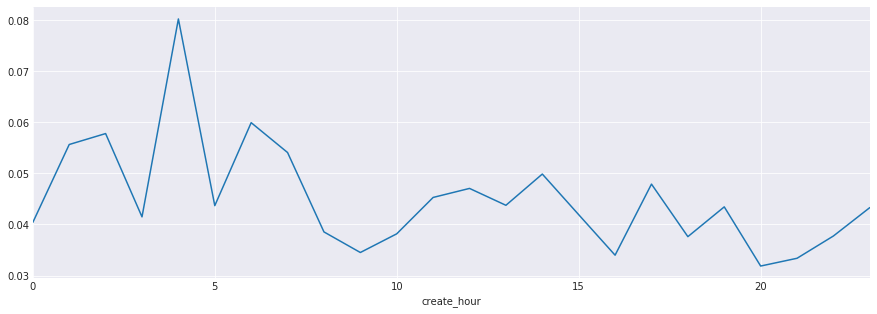

In [2054]:
a=data_set.groupby(['create_hour']).y_tag.agg(['size','sum','mean'])
# a['mean']=a['mean'].apply(lambda x: format(x, '.1%'))
a['mean'].plot(figsize=(15,5))

## 周几

In [2042]:
# 计算周几
def get_week_day(date):
    week_day_dict = {
    0 : '1',
    1 : '2',
    2 : '3',
    3 : '4',
    4 : '5',
    5 : '6',
    6 : '7',
  }
    day = date.weekday()
    return week_day_dict[day]


week_day=[]
for i in range(data_set.shape[0]):
    week_day.append(get_week_day(datetime.datetime.strptime(data_set['create_dt'][i],"%Y-%m-%d")))
    

data_set['week_day']=week_day

In [2050]:
data_set['week_day_tag']=((data_set['week_day']=='6')|(data_set['week_day']=='7'))
data_set[['week_day','week_day_tag']].head()

# (data_set['delta_reg_day']==0)

,week_day,week_day_tag
0,1,False
1,6,True
2,2,False
3,7,True
4,3,False


In [2053]:
data_set.pivot_table(values=['y_tag'],index='create_month',columns='week_day_tag',aggfunc=[np.size,np.sum,np.mean])

size            sum             mean          
               y_tag          y_tag            y_tag          
week_day_tag   False   True   False  True      False     True 
create_month                                                  
2018-01       1925.0   523.0    0.0    0.0  0.000000  0.000000
2018-02       1502.0   562.0    0.0    0.0  0.000000  0.000000
2018-03       2369.0   867.0    0.0    0.0  0.000000  0.000000
2018-04       2213.0   894.0  144.0  101.0  0.065070  0.112975
2018-05       1958.0   647.0  132.0   34.0  0.067416  0.052550
2018-06       2510.0   958.0  166.0   70.0  0.066135  0.073069
2018-07       3110.0   845.0  142.0   69.0  0.045659  0.081657
2018-08       3232.0   837.0  151.0   48.0  0.046720  0.057348
2018-09       3554.0  1325.0   97.0   96.0  0.027293  0.072453
2018-10       3824.0  1149.0  198.0   16.0  0.051778  0.013925

## s004

In [1677]:
# s004数据对之家数据的匹配度
data_set['s004_tag']=(data_set['s004'].notnull())

data_set['s004_01']=(data_set['s004']>=0.1)


In [1678]:
# 是否能匹配上s004特征
data_set['s004_01'].value_counts()

False    31989
True      2815
Name: s004_01, dtype: int64

## 信用分

In [1948]:
# 500分以下
data_set['score_2_500']=(data_set['score_2']<500)

# 487分以下
data_set['score_2_487']=(data_set['score_2']<487)


# 500分以下拒绝 : 效果如何
a=data_set.groupby(['score_2_487']).y_tag.agg(['size','sum','mean'])
a['mean']=a['mean'].apply(lambda x: format(x, '.1%'))
a

,size,sum,mean
score_2_487,,,
False,33140,1302.0,3.9%
True,1664,162.0,9.7%


In [1949]:
a=data_set.groupby(['score_2_500']).y_tag.agg(['size','sum','mean'])
a['mean']=a['mean'].apply(lambda x: format(x, '.1%'))
a

,size,sum,mean
score_2_500,,,
False,32865,1285.0,3.9%
True,1939,179.0,9.2%


## 画像

In [1680]:
# 画像特征
tag_cols=['marital_status','mortgage','customer_value','is_loan','concen_degree'
        ,'is_car_loan','violation_level','credit_level','stage','car_age_0']


# 是否可以匹配上
for col in tag_cols:
    data_set[col+str('_tag')]=(data_set[col].notnull())+0


In [1681]:
# 画像特征 : 是否为空
hua_tag=[col for col in data_set.columns if col.endswith('_tag')]
data_set[hua_tag].head(1)

,dahua_tag,qianbao_tag,card_no_tag,id_no_tag,name_tag,y_tag,s004_tag,marital_status_tag,mortgage_tag,customer_value_tag,is_loan_tag,concen_degree_tag,is_car_loan_tag,violation_level_tag,credit_level_tag,stage_tag,car_age_0_tag
0,1.0,0.0,2.0,3.0,3.0,0.0,False,1,1,1,1,1,1,1,1,1,1


## 省一致性

In [1682]:
# 判断GPS所在省份和籍贯是否同省
data_set['diff_gps_real_prov']=(data_set.gps_province==data_set.rn_province)

In [1683]:
# 省份一致性验证
print 'diff_gps_real_prov' ,'\n',data_set['diff_gps_real_prov'].value_counts(dropna=False)

diff_gps_real_prov 
True     25207
False     9597
Name: diff_gps_real_prov, dtype: int64


## 市一致性

In [1684]:
# GPS城市 VS 注册城市 是否一致
data_set['diff_gps_reg_city']=(data_set.gps_city==data_set.city_name)

# GPS城市 VS 籍贯城市 是否一致
data_set['diff_gps_real_city']=(data_set.gps_city==data_set.rn_city)

# GPS城市 VS 籍贯城市 是否一致
data_set['diff_reg_real_city']=(data_set.city_name==data_set.rn_city)

In [1685]:
data_set.pivot_table(values=['y_tag'],index='diff_gps_reg_city',aggfunc=[np.size,np.sum,np.mean])
# columns='create_month',

,size,sum,mean
,y_tag,y_tag,y_tag
diff_gps_reg_city,,,
False,18601.0,860.0,0.046234
True,16203.0,604.0,0.037277


## ICBC

In [952]:
# 判断银行是否有比较高的逾期聚集效应
data_set.groupby(['bank_code']).y_tag.agg([np.size,np.sum,np.mean]).sort_values(by='mean',ascending=False)[0:3]

,size,sum,mean
bank_code,,,
ICBC,9836.0,547.0,0.055629
BOS,19.0,1.0,0.052632
GDB,197.0,9.0,0.045685


In [953]:
# 特征构建 : 绑定的银行卡是否是ICBC的
data_set['bank_tag']=(data_set['bank_code']=='ICBC')

# 绑ICBC银行卡的人逾期率是不是就高一些呢
data_set.groupby(['bank_tag']).y_tag.agg([np.size,np.sum,np.mean])

,size,sum,mean
bank_tag,,,
False,28634.0,1052.0,0.036749
True,9836.0,547.0,0.055629


## 经纬度

In [1686]:
data_set['latitude']=data_set['latitude'].fillna(0)
data_set['longitude']=data_set['longitude'].fillna(0)


LatLong=[]
for i in range(data_set.shape[0]):
    LatLong.append(str(data_set['latitude'][i])+str('_')+str(data_set['longitude'][i]))


data_set['LatLong']=LatLong
data_set[['latitude','longitude','LatLong']].head(1)

,latitude,longitude,LatLong
0,31.6765,118.516914,31.67650023_118.516914001


## 多头特征

In [39]:
# 申请i贷前是否申请其他贷款
data_set['cnt_duotou_7_day_tag']=(data_set['cnt_duotou_7_day']==0)
data_set['cnt_duotou_5_day_tag']=(data_set['cnt_duotou_5_day']==0)

In [47]:
# data_set['cnt_duotou_3_day'].value_counts()
data_set['cnt_duotou_3_day_tag']=(data_set['cnt_duotou_3_day']>=2)

In [48]:
data_set.groupby(['create_month']).cnt_duotou_3_day_tag.agg([np.size,np.sum,np.mean])


,size,sum,mean
create_month,,,
2018-01,2448,478.0,0.195261
2018-02,2064,512.0,0.248062
2018-03,3236,815.0,0.251854
2018-04,3107,570.0,0.183457
2018-05,2605,528.0,0.202687
2018-06,3468,785.0,0.226355
2018-07,3955,757.0,0.191403
2018-08,4069,889.0,0.218481
2018-09,4879,840.0,0.172166


## 是否当天注册

In [40]:
# 转化为天
data_set['delta_reg_time']=data_set['delta_reg_time'].fillna(0)
delta_reg_day=[]
for i in data_set['delta_reg_time']:
    delta_reg_day.append(int(i/24))


data_set['delta_reg_day']=delta_reg_day

In [46]:
data_set.groupby(['create_month']).delta_reg_day_tag.agg([np.size,np.sum,np.mean])

,size,sum,mean
create_month,,,
2018-01,2448,472.0,0.192810
2018-02,2064,418.0,0.202519
2018-03,3236,624.0,0.192831
2018-04,3107,453.0,0.145800
2018-05,2605,411.0,0.157774
2018-06,3468,596.0,0.171857
2018-07,3955,577.0,0.145891
2018-08,4069,693.0,0.170312
2018-09,4879,1041.0,0.213363


In [43]:
# True : 当天注册
data_set['delta_reg_day_tag']=(data_set['delta_reg_day']==0)

data_set.groupby(['delta_reg_day_tag']).y_tag.agg([np.size,np.sum,np.mean])

,size,sum,mean
delta_reg_day_tag,,,
False,27942.0,1032.0,0.036934
True,6862.0,432.0,0.062955


## 城市等级

In [1691]:
# True : 4线,5线
data_set['gps_idx_4']=(data_set['gps_city_idx']>=4)
data_set['rn_idx_4']=(data_set['rn_city_idx']>=4)

In [1692]:
data_set.groupby(['rn_idx_4']).y_tag.agg([np.size,np.sum,np.mean])

,size,sum,mean
rn_idx_4,,,
False,20792.0,812.0,0.039053
True,14012.0,652.0,0.046532


## 年龄

In [1693]:
data_set['age_v']=((data_set['age']>=45)|(data_set['age']<=27))
data_set.groupby(['age_v']).y_tag.agg([np.size,np.sum,np.mean])

,size,sum,mean
age_v,,,
False,21561.0,839.0,0.038913
True,13243.0,625.0,0.047195


In [1694]:
data_set['age_45']=(data_set['age']>=45)
data_set.groupby(['age_45']).y_tag.agg([np.size,np.sum,np.mean])

,size,sum,mean
age_45,,,
False,33926.0,1421.0,0.041885
True,878.0,43.0,0.048975


## 首次登陆时间

In [1561]:
data_set['first_login_dt'].head()

0    2018/2/28
1    2018/3/22
2     2018/1/9
3            0
4     2018/3/2
Name: first_login_dt, dtype: object

In [1695]:
import time
import datetime

# 首次
data_set['first_login_dt']=data_set['first_login_dt'].fillna(0)

# 时间转换
first_login_dt=data_set['first_login_dt'].astype(str)
first_login_day=[]
for i in first_login_dt:
    if i!='0':
        a_1=datetime.datetime.strptime(i,"%Y/%m/%d").strftime("%Y-%m-%d")
        first_login_day.append(a_1)
    else :
        first_login_day.append(0)

# 计算申请设备首次出现时间差
data_set['first_login_day']=first_login_day
data_set['first_login_day'].head()

0    2018-02-28
1    2018-03-22
2    2018-01-09
3             0
4    2018-03-02
Name: first_login_day, dtype: object

In [1696]:
# 计算时间差
def Caltime(date1,date2):
    date1=time.strptime(date1,"%Y-%m-%d")
    date2=time.strptime(date2,"%Y-%m-%d")
    date1=datetime.datetime(date1[0],date1[1],date1[2])
    date2=datetime.datetime(date2[0],date2[1],date2[2])
    return date1-date2

In [1697]:
delta_day=[]

# 计算申请设备首次出现时间差
for i in range(data_set.shape[0]):
    if data_set['first_login_day'][i]!=0:
        a=Caltime(data_set['create_dt'][i],data_set['first_login_day'][i]).days
        delta_day.append(a)
    else :
        delta_day.append(-1)
    

data_set['delta_apply_first_day']=delta_day

In [1698]:
# 判断设备是否当天首次出现
data_set['delta_apply_first_day_tag']=(data_set['delta_apply_first_day']==0)

data_set.groupby(['delta_apply_first_day_tag']).y_tag.agg([np.size,np.sum,np.mean])

,size,sum,mean
delta_apply_first_day_tag,,,
False,32234.0,1262.0,0.039151
True,2570.0,202.0,0.078599


In [1699]:
# 测试以下注册时间差和设备创建时间差
a=data_set.groupby(['delta_reg_day_tag','delta_apply_first_day_tag']).y_tag.agg([np.size,np.sum,np.mean])
a['mean']=a['mean'].apply(lambda x: format(x, '.1%'))
a

size     sum  mean
delta_reg_day_tag delta_apply_first_day_tag                       
False             False                      27558.0  1011.0  3.7%
                  True                         384.0    21.0  5.5%
True              False                       4676.0   251.0  5.4%
                  True                        2186.0   181.0  8.3%

In [1700]:
# 测试以下注册时间差和设备创建时间差
a=data_set.groupby(['delta_reg_day_tag']).y_tag.agg([np.size,np.sum,np.mean])
a['mean']=a['mean'].apply(lambda x: format(x, '.1%'))
a

,size,sum,mean
delta_reg_day_tag,,,
False,27942.0,1032.0,3.7%
True,6862.0,432.0,6.3%


## 注册时间 * 登陆时间

In [1720]:
# 注册时间 * 登陆时间
data_set.loc[(data_set.delta_reg_day_tag == True)&(data_set.delta_apply_first_day_tag ==False), 'delta_day_tag'] = 1
data_set.loc[(data_set.delta_reg_day_tag == False)&(data_set.delta_apply_first_day_tag ==False), 'delta_day_tag'] = 2
data_set.loc[(data_set.delta_reg_day_tag == True)&(data_set.delta_apply_first_day_tag ==True), 'delta_day_tag'] = 3
data_set.loc[(data_set.delta_reg_day_tag == False)&(data_set.delta_apply_first_day_tag ==True), 'delta_day_tag'] = 4


In [1723]:
reg_first_table=data_set.groupby(['delta_day_tag']).y_tag.agg([np.size,np.sum,np.mean])
reg_first_table['mean']=reg_first_table['mean'].apply(lambda x: format(x, '.1%'))
reg_first_table

,size,sum,mean
delta_day_tag,,,
1.0,4676.0,251.0,5.4%
2.0,27558.0,1011.0,3.7%
3.0,2186.0,181.0,8.3%
4.0,384.0,21.0,5.5%


* 当天注册且设备当天出现, 逾期率8.3%, 可覆盖6.3%的交易

# 探索分析

## device_id

### 总揽

In [69]:
# 不同设备用信人数, 逾期人数和逾期率
device_id_trend=data_set.pivot_table(values=['y_tag'],index='device_id',columns='create_month',aggfunc=[np.size,np.sum,np.mean])
device_id_trend[0:20]

size                                  \
                                       y_tag                                   
create_month                         2018-01 2018-02 2018-03 2018-04 2018-05   
device_id                                                                      
000229B3-1391-469C-83E1-A713C8097229     NaN     NaN     1.0     NaN     NaN   
00053F56-32CA-4863-9B71-940F7426EC75     NaN     NaN     NaN     NaN     NaN   
0008C75C-45A9-4857-858E-D316AA729435     NaN     NaN     NaN     NaN     NaN   
000D0271-4F2C-47CC-A9D4-E315AA6029AA     NaN     NaN     NaN     NaN     1.0   
0011D5C7-706D-40B1-9E4E-E9A66B9D6CCC     NaN     NaN     NaN     NaN     NaN   
00137111-7395-4798-AA60-E9F93DF11B60     NaN     NaN     NaN     NaN     NaN   
0013FB63-D227-4E8B-BC59-F44B7AA57648     NaN     NaN     1.0     NaN     NaN   
00177797-13EB-472A-BBB9-5AD0C4414C06     NaN     NaN     NaN     NaN     1.0   
0018f053                                 1.0     NaN     NaN     NaN     NaN   
001FA6F5-BC20-4DAB-9D94-6F728A432F84     NaN     NaN     NaN     NaN     NaN   
0020AC80-EF22-4A2F-9444-908B4D241C71     NaN     NaN     NaN     NaN     1.0   
00285234-EE58-43BF-A7AA-4A957671F5B1     NaN     NaN     NaN     1.0     NaN   
0039dbe1                                 NaN     NaN     NaN     NaN     NaN   
003B2737-EBC8-418E-8239-7481E4C59C71     NaN     NaN     NaN     NaN     NaN   
003DE896-C9CE-46FD-AA91-2657068C5471     NaN     NaN     NaN     NaN     NaN   
003F3697-8B29-45C3-8E8E-9F0186FE7037     NaN     NaN     NaN     1.0     NaN   
003F4A95-184F-4E99-BC8E-DA5F5048CAB9     NaN     NaN     NaN     NaN     NaN   
003a7f7c                                 NaN     NaN     NaN     NaN     NaN   
00442A78-C2D4-4F50-8FAA-5B5090CA4FA2     NaN     NaN     1.0     NaN     NaN   
00446BC0-C5DD-4E8D-BDB1-2D10DBD4EEA6     NaN     NaN     1.0     NaN     NaN   

                                                                              \
                                                                               
create_month                         2018-06 2018-07 2018-08 2018-09 2018-10   
device_id                                                                      
000229B3-1391-469C-83E1-A713C8097229     NaN     NaN     NaN     NaN     NaN   
00053F56-32CA-4863-9B71-940F7426EC75     1.0     NaN     NaN     NaN     NaN   
0008C75C-45A9-4857-858E-D316AA729435     1.0     NaN     NaN     NaN     NaN   
000D0271-4F2C-47CC-A9D4-E315AA6029AA     NaN     NaN     NaN     NaN     NaN   
0011D5C7-706D-40B1-9E4E-E9A66B9D6CCC     NaN     NaN     NaN     1.0     NaN   
00137111-7395-4798-AA60-E9F93DF11B60     1.0     NaN     NaN     NaN     NaN   
0013FB63-D227-4E8B-BC59-F44B7AA57648     NaN     NaN     NaN     NaN     NaN   
00177797-13EB-472A-BBB9-5AD0C4414C06     NaN     NaN     NaN     NaN     NaN   
0018f053                                 NaN     NaN     NaN     NaN     NaN   
001FA6F5-BC20-4DAB-9D94-6F728A432F84     NaN     NaN     1.0     NaN     NaN   
0020AC80-EF22-4A2F-9444-908B4D241C71     NaN     NaN     NaN     NaN     NaN   
00285234-EE58-43BF-A7AA-4A957671F5B1     NaN     NaN     NaN     NaN     NaN   
0039dbe1                                 NaN     1.0     NaN     NaN     NaN   
003B2737-EBC8-418E-8239-7481E4C59C71     NaN     NaN     1.0     NaN     NaN   
003DE896-C9CE-46FD-AA91-2657068C5471     NaN     NaN     NaN     NaN     1.0   
003F3697-8B29-45C3-8E8E-9F0186FE7037     NaN     NaN     NaN     NaN     NaN   
003F4A95-184F-4E99-BC8E-DA5F5048CAB9     NaN     NaN     NaN     NaN     1.0   
003a7f7c                                 NaN     1.0     NaN     NaN     NaN   
00442A78-C2D4-4F50-8FAA-5B5090CA4FA2     NaN     NaN     NaN     NaN     NaN   
00446BC0-C5DD-4E8D-BDB1-2D10DBD4EEA6     NaN     NaN     NaN     NaN     NaN   

                                         sum                                  \
                                       y_tag                                   
create_month                         2

### 用信人数趋势

In [70]:
# 从逾期人数维度观察
device_id_trend_size=device_id_trend['size']['y_tag'].sort_values(by=['2018-10'],ascending=False,inplace=False)
device_id_trend_size[0:9]

create_month,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10
device_id,,,,,,,,,,
SP3695314683244,NaN,1.0,NaN,3.0,3.0,30.0,61.0,60.0,56.0,151.0
SP4496126466244,NaN,NaN,NaN,2.0,NaN,1.0,40.0,62.0,88.0,103.0
SP6496815499248,NaN,NaN,NaN,3.0,14.0,23.0,39.0,51.0,81.0,79.0
SP3695304683244,NaN,NaN,NaN,NaN,NaN,6.0,36.0,53.0,31.0,58.0
SP7792985782243,NaN,NaN,1.0,1.0,4.0,23.0,24.0,28.0,39.0,43.0
SP6496145466844,NaN,NaN,NaN,2.0,2.0,12.0,12.0,19.0,27.0,32.0
SP6696505646247,NaN,NaN,NaN,NaN,NaN,1.0,5.0,9.0,17.0,26.0
SP3595514683244,NaN,NaN,NaN,NaN,NaN,NaN,2.0,15.0,9.0,26.0
SP3595354683244,NaN,NaN,NaN,NaN,NaN,17.0,5.0,3.0,26.0,25.0


### 逾期人数趋势

In [71]:
# 从逾期人数维度观察
device_id_trend_sum=device_id_trend['sum']['y_tag'].sort_values(by=['2018-10'],ascending=False,inplace=False)
device_id_trend_sum[0:9]

create_month,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10
device_id,,,,,,,,,,
SP3695314683244,NaN,0.0,NaN,0.0,0.0,3.0,1.0,1.0,1.0,8.0
SP4496126466244,NaN,NaN,NaN,1.0,NaN,0.0,5.0,5.0,1.0,6.0
SP6496815499248,NaN,NaN,NaN,1.0,0.0,3.0,4.0,2.0,3.0,5.0
SP3695304683244,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,1.0,4.0
SP8597333683244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,3.0
SP6498815429248,NaN,NaN,NaN,0.0,0.0,1.0,0.0,2.0,2.0,2.0
SP6496465466244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0
SP3595514683244,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,2.0
SP3695324683244,0.0,0.0,0.0,8.0,0.0,2.0,1.0,0.0,0.0,2.0


### 逾期率趋势

In [95]:
# 逾期率
device_id_trend_mean=device_id_trend['mean']['y_tag'].sort_values(by=['2018-10'],ascending=False,inplace=False)
device_id_trend_mean[0:9]

create_month,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10
device_id,,,,,,,,,,
612cc80b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
EJLDU16824002751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
088420E8-511A-4A83-BE16-9181DDFE8939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
532c8b0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
Z5WSJZNV99999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
6C0BEEBC-21C4-4FF3-9DE3-2AED244449D9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
13B48891-3605-43A0-BDA3-729CA844005D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
277D233C-949F-4877-8FC0-25CA42F27BC7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
660B810B-4F99-4D71-9757-C2F95850412E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


### 是否存在异常点

* 同时满足或用信人数多、或逾期人数多、或逾期率高

In [89]:
# 按照申请多少判断异常点
Undevice_Point_1=device_id_trend['size']['y_tag'].sort_values(by=['2018-10'],ascending=False,inplace=False)[0:30]
Undevice_Point_2=device_id_trend['sum']['y_tag'].sort_values(by=['2018-10'],ascending=False,inplace=False)[0:30]
Undevice_Point_3=device_id_trend['mean']['y_tag'].sort_values(by=['2018-10'],ascending=False,inplace=False)[0:200]

# 转成list形式
Undevice_Point_1=Undevice_Point_1.index.tolist()
Undevice_Point_2=Undevice_Point_2.index.tolist()
Undevice_Point_3=Undevice_Point_3.index.tolist()

In [1304]:
UnNormal_device=[]
for i in Undevice_Point_1:
    if i in Undevice_Point_2:
        if i in Undevice_Point_3:
            UnNormal_device.append(i)
            

# 取出交集:满足或用信人数多、或逾期人数多、或逾期率高
print len(UnNormal_device),UnNormal_device

9 ['SP3695314683244', 'SP4496126466244', 'SP6496815499248', 'SP3695304683244', 'SP3595514683244', 'SP6498815429248', 'SP6496465466244', 'SP8597333683244', 'SP3695324683244']


### 疑似异常点逾期率

In [91]:
# 异常点的申请量
device_id_trend[['size','sum','mean']].loc[UnNormal_device]


size                                                  \
                  y_tag                                                   
create_month    2018-01 2018-02 2018-03 2018-04 2018-05 2018-06 2018-07   
device_id                                                                 
SP3695314683244     NaN     1.0     NaN     3.0     3.0    30.0    61.0   
SP4496126466244     NaN     NaN     NaN     2.0     NaN     1.0    40.0   
SP6496815499248     NaN     NaN     NaN     3.0    14.0    23.0    39.0   
SP3695304683244     NaN     NaN     NaN     NaN     NaN     6.0    36.0   
SP3595514683244     NaN     NaN     NaN     NaN     NaN     NaN     2.0   
SP6498815429248     NaN     NaN     NaN     3.0     3.0     5.0     9.0   
SP6496465466244     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
SP8597333683244     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
SP3695324683244    26.0    41.0   103.0    59.0    26.0    51.0    10.0   

                                            sum                          \
                                          y_tag                           
create_month    2018-08 2018-09 2018-10 2018-01 2018-02 2018-03 2018-04   
device_id                                                                 
SP3695314683244    60.0    56.0   151.0     NaN     0.0     NaN     0.0   
SP4496126466244    62.0    88.0   103.0     NaN     NaN     NaN     1.0   
SP6496815499248    51.0    81.0    79.0     NaN     NaN     NaN     1.0   
SP3695304683244    53.0    31.0    58.0     NaN     NaN     NaN     NaN   
SP3595514683244    15.0     9.0    26.0     NaN     NaN     NaN     NaN   
SP6498815429248    14.0    16.0    24.0     NaN     NaN     NaN     0.0   
SP6496465466244     NaN    19.0    23.0     NaN     NaN     NaN     NaN   
SP8597333683244     1.0    12.0    17.0     NaN     NaN     NaN     NaN   
SP3695324683244     5.0     1.0    13.0     0.0     0.0     0.0     8.0   

                                                                   mean  \
                                                                  y_tag   
create_month    2018-05 2018-06 2018-07 2018-08 2018-09 2018-10 2018-01   
device_id                                                                 
SP3695314683244     0.0     3.0     1.0     1.0     1.0     8.0     NaN   
SP4496126466244     NaN     0.0     5.0     5.0     1.0     6.0     NaN   
SP6496815499248     0.0     3.0     4.0     2.0     3.0     5.0     NaN   
SP3695304683244     NaN     1.0     2.0     2.0     1.0     4.0     NaN   
SP3595514683244     NaN     NaN     0.0     0.0     1.0     2.0     NaN   
SP6498815429248     0.0     1.0     0.0     2.0     2.0     2.0     NaN   
SP6496465466244     NaN     NaN     NaN     NaN     0.0     2.0     NaN   
SP8597333683244     NaN     NaN     NaN     0.0     0.0     3.0     NaN   
SP3695324683244     0.0     2.0     1.0     0.0     0.0     2.0     0.0   

                                                                       \
                                                                        
create_month    2018-02 2018-03   2018-04 2018-05   2018-06   2018-07   
device_id                                                               
SP3695314683244     0.0     NaN  0.000000     0.0  0.100000  0.016393   
SP4496126466244     NaN     NaN  0.500000     NaN  0.000000  0.125000   
SP6496815499248     NaN     NaN  0.333333     0.0  0.130435  0.102564   
SP3695304683244     NaN     NaN       NaN     NaN  0.166667  0.055556   
SP3595514683244     NaN     NaN       NaN     NaN       NaN  0.000000   
SP6498815429248     NaN     NaN  0.000000     0.0  0.200000  0.000000   
SP6496465466244     NaN     NaN       NaN     NaN       NaN       NaN   
SP8597333683244     NaN     NaN       NaN     NaN       NaN       NaN   
SP3695324683244     0.0     0.0  0.135593     0.0  0.039216  0.100000   

                                               
                                               
create_month      2018-08   2018-09   2018-10

### 异常点趋势

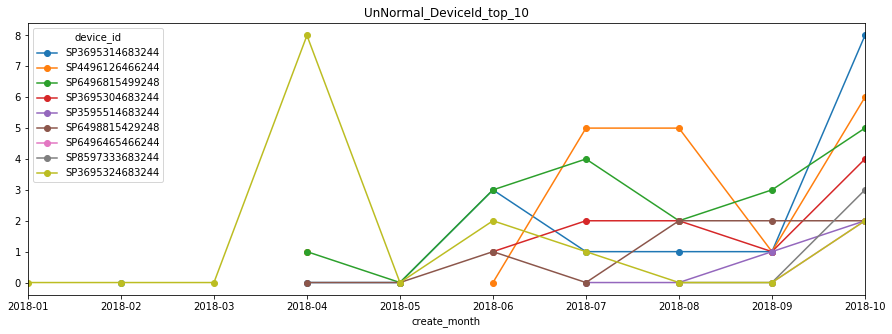

In [98]:
# 异常点趋势
device_id_trend_sum.loc[UnNormal_device].T.plot(title='UnNormal_DeviceId_top_10',style='-o',figsize=(15, 5))

### 异常点热力图

[Text(0.5,0,u'2018-01'),
 Text(1.5,0,u'2018-02'),
 Text(2.5,0,u'2018-03'),
 Text(3.5,0,u'2018-04'),
 Text(4.5,0,u'2018-05'),
 Text(5.5,0,u'2018-06'),
 Text(6.5,0,u'2018-07'),
 Text(7.5,0,u'2018-08'),
 Text(8.5,0,u'2018-09'),
 Text(9.5,0,u'2018-10')]

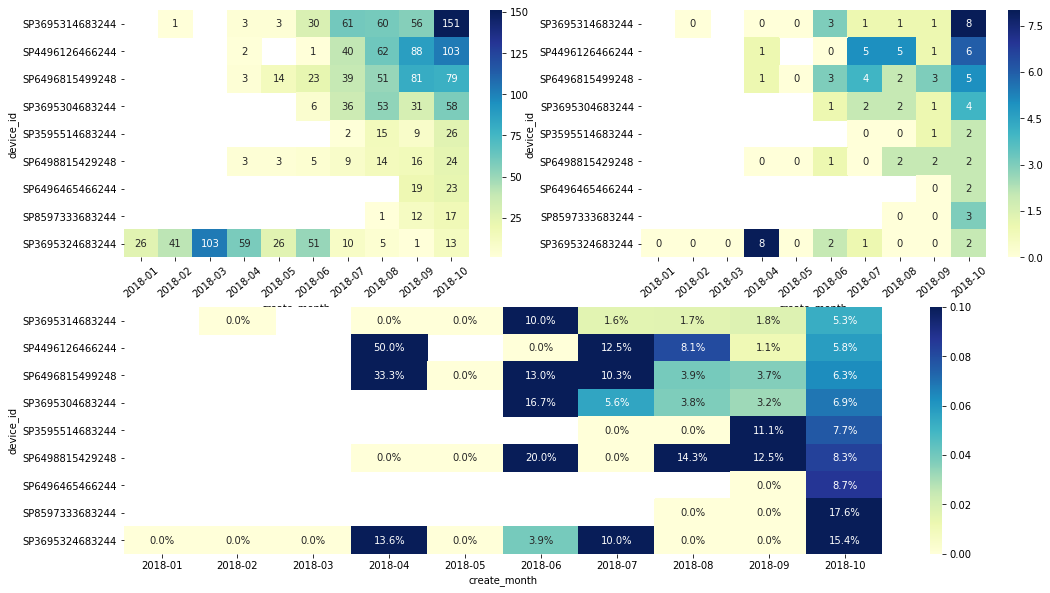

In [96]:
# 布局
fig = plt.figure(figsize=(17, 10))
axes1=fig.add_subplot(221)
axes2=fig.add_subplot(222)
axes3=fig.add_subplot(212)

# 逾期人数热力图
sns.heatmap(device_id_trend_size.loc[UnNormal_device],annot=True,cmap="YlGnBu",fmt="0.0f",ax=axes1)
sns.heatmap(device_id_trend_sum.loc[UnNormal_device],annot=True,cmap="YlGnBu",fmt="0.0f",ax=axes2)
sns.heatmap(device_id_trend_mean.loc[UnNormal_device],annot=True,cmap="YlGnBu",vmin=0, vmax=0.1,fmt="0.1%",ax=axes3)

# 坐标轴方向
axes1.set_xticklabels(axes1.get_xticklabels(), rotation=40)
axes2.set_xticklabels(axes2.get_xticklabels(), rotation=40)
# axes3.set_xticklabels(axes3.get_xticklabels(), rotation=45)

### 结论

* 拉黑以下设备号, 后续同设备申请直接拒绝


* 找出以下设备号跟之家关联设备, 也做关联拉黑, 后续之家黑设备申请的用户也拉黑处理


In [115]:
# 拉黑以下设备号
UnNormal_device[0:5]

['SP3695314683244',
 'SP4496126466244',
 'SP6496815499248',
 'SP3695304683244',
 'SP3595514683244']

In [131]:
device_result=data_set.pivot_table(values=['y_tag'],index='device_id',aggfunc=[np.size,np.sum,np.mean]).loc[UnNormal_device[0:5]]
a1=device_result['size'].sum()
a2=device_result['sum'].sum()

print '拒绝人数 : %.2f%%'%(a1/data_set.shape[0]*100)
print '逾期率 : %.2f%%'%(a2/a1*100)
print '召回率 : %.2f%%'%(a2/data_set['y_tag'].sum()*100)

拒绝人数 : 3.52%
逾期率 : 5.31%
召回率 : 4.48%


## 经纬度

### 总揽

In [135]:
# 不同GPS用信人数, 逾期人数和逾期率
LatLong_trend=data_set.pivot_table(values=['y_tag'],index='LatLong',columns='create_month',aggfunc=[np.size,np.sum,np.mean])
LatLong_trend[0:9]

size                                          \
                              y_tag                                           
create_month                2018-01 2018-02 2018-03 2018-04 2018-05 2018-06   
LatLong                                                                       
0.0_0.0                         1.0     NaN     NaN     NaN     NaN     NaN   
10.7736151909_106.696437805     NaN     NaN     NaN     1.0     NaN     NaN   
11.0735449288_106.173315263     NaN     NaN     NaN     NaN     NaN     1.0   
13.822487562_100.574277854      NaN     NaN     1.0     NaN     NaN     NaN   
18.2167858578_109.490984525     NaN     1.0     NaN     NaN     NaN     NaN   
18.2271357028_109.528200978     1.0     NaN     NaN     NaN     NaN     NaN   
18.227647772_109.53444001       NaN     NaN     NaN     NaN     NaN     NaN   
18.2286639_109.526261592        NaN     NaN     NaN     NaN     NaN     NaN   
18.231610184_109.636706077      NaN     NaN     NaN     NaN     NaN     NaN   

                                                                sum          \
                                                              y_tag           
create_month                2018-07 2018-08 2018-09 2018-10 2018-01 2018-02   
LatLong                                                                       
0.0_0.0                         NaN     NaN     NaN     NaN     NaN     NaN   
10.7736151909_106.696437805     NaN     NaN     NaN     NaN     NaN     NaN   
11.0735449288_106.173315263     NaN     NaN     NaN     NaN     NaN     NaN   
13.822487562_100.574277854      NaN     NaN     NaN     NaN     NaN     NaN   
18.2167858578_109.490984525     NaN     NaN     NaN     NaN     NaN     0.0   
18.2271357028_109.528200978     NaN     NaN     NaN     NaN     0.0     NaN   
18.227647772_109.53444001       NaN     NaN     1.0     NaN     NaN     NaN   
18.2286639_109.526261592        1.0     NaN     NaN     NaN     NaN     NaN   
18.231610184_109.636706077      1.0     NaN     NaN     NaN     NaN     NaN   

                                                                             \
                                                                              
create_month                2018-03 2018-04 2018-05 2018-06 2018-07 2018-08   
LatLong                                                                       
0.0_0.0                         NaN     NaN     NaN     NaN     NaN     NaN   
10.7736151909_106.696437805     NaN     0.0     NaN     NaN     NaN     NaN   
11.0735449288_106.173315263     NaN     NaN     NaN     0.0     NaN     NaN   
13.822487562_100.574277854      0.0     NaN     NaN     NaN     NaN     NaN   
18.2167858578_109.490984525     NaN     NaN     NaN     NaN     NaN     NaN   
18.2271357028_109.528200978     NaN     NaN     NaN     NaN     NaN     NaN   
18.227647772_109.53444001       NaN     NaN     NaN     NaN     NaN     NaN   
18.2286639_109.526261592        NaN     NaN     NaN     NaN     0.0     NaN   
18.231610184_109.636706077      NaN     NaN     NaN     NaN     0.0     NaN   

                                               mean                          \
                                              y_tag                           
create_month                2018-09 2018-10 2018-01 2018-02 2018-03 2018-04   
LatLong                                                                       
0.0_0.0                         NaN     NaN     NaN     NaN     NaN     NaN   
10.7736151909_106.696437805     NaN     NaN     NaN     NaN     NaN     0.0   
11.0735449288_106.173315263     NaN     NaN     NaN     NaN     NaN     NaN   
13.822487562_100.574277854      NaN     NaN     NaN     NaN     0.0     NaN   
18.2167858578_109.490984525     NaN     NaN     NaN     0.0     NaN     NaN   
18.2271357028_109.528200978     NaN     NaN     0.0     NaN     NaN     NaN   
18.227647772_109.53444001       0.0     NaN     NaN     NaN     NaN     NaN   
18.2286639_109.526261592        NaN     NaN     NaN     NaN     NaN     NaN   

### 用信人数趋势

In [998]:
# 从用信人数维度观察
LatLong_trend_size=LatLong_trend['size']['y_tag'].sort_values(by=['2018-08'],ascending=False,inplace=False)
LatLong_trend_size[0:9]

create_month,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10
LatLong,,,,,,,,,,
22.7756913027_114.129425904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
22.7554992696_114.973726323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
37.1530197494_111.798957272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
32.3079224409_118.726826318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
32.3095254643_121.183470545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
32.316270518_119.465828927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
32.3166698017_108.907202515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
32.3171510049_108.911063844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
32.3218059625_112.145887302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


### 逾期人数趋势

In [1048]:
# 从逾期人数维度观察
LatLong_trend_sum=LatLong_trend['sum']['y_tag'].sort_values(by=['2018-08'],ascending=False,inplace=False)
LatLong_trend_sum[0:9]

create_month,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10
LatLong,,,,,,,,,,
22.7756913027_114.129425904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
22.7554992696_114.973726323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
36.0456554975_103.918132705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
22.5862774028_113.955301222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
27.5911100054_106.676035047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
37.0915056183_114.510242998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
30.9501557912_120.884696263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
30.5704382936_111.457515226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
25.4170542191_118.757140183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


### 逾期率趋势

In [1001]:
# 从逾期人数维度观察
LatLong_trend_mean=LatLong_trend['mean']['y_tag'].sort_values(by=['2018-08'],ascending=False,inplace=False)
LatLong_trend_mean[0:9]

create_month,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10
LatLong,,,,,,,,,,
36.0456554975_103.918132705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
35.0249147431_118.424255955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
27.5911100054_106.676035047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
37.0915056183_114.510242998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
30.9501557912_120.884696263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
30.5704382936_111.457515226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
25.4170542191_118.757140183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
31.7586917607_117.21147245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
22.7756913027_114.129425904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


### 是否存在异常点

In [1055]:
# 按照申请多少判断异常点
Un_gps_1=LatLong_trend['size']['y_tag'].sort_values(by=['2018-08'],ascending=False,inplace=False)[0:1000]
Un_gps_2=LatLong_trend['sum']['y_tag'].sort_values(by=['2018-08'],ascending=False,inplace=False)[0:100]
Un_gps_3=LatLong_trend['mean']['y_tag'].sort_values(by=['2018-08'],ascending=False,inplace=False)[0:1000]

# 转成list形式
Un_gps_1=Un_gps_1.index.tolist()
Un_gps_2=Un_gps_2.index.tolist()
Un_gps_3=Un_gps_3.index.tolist()

In [1056]:
UnNormal_gps=[]
for i in Un_gps_2:
    if i in Un_gps_1:
        if i in Un_gps_3:
            UnNormal_gps.append(i)
            

# 取出交集:满足或用信人数多、或逾期人数多、或逾期率高
print len(UnNormal_gps),UnNormal_gps

20 ['22.7756913027_114.129425904', '22.7554992696_114.973726323', '30.9501557912_120.884696263', '31.7586917607_117.21147245', '30.9663172_104.203967042', '31.7577889247_116.534570005', '33.5480232175_114.717471836', '33.5562913282_114.000461171', '34.1103044856_110.138208379', '31.7749309603_118.876866283', '31.8140221786_117.194215997', '32.6478134311_110.788377965', '31.7982400641_120.784423017', '34.1878741781_108.872322041', '34.0660240124_111.070618903', '34.065839626_111.067844169', '31.5617836692_106.003820133', '31.2173848254_121.423592831', '32.332258105_106.82768032', '33.9577064962_118.29450389']


### 疑似异常点逾期率

In [1057]:
# 异常点的申请量
LatLong_trend[['size','sum','mean']].loc[UnNormal_gps]

size                                          \
                              y_tag                                           
create_month                2018-01 2018-02 2018-03 2018-04 2018-05 2018-06   
LatLong                                                                       
22.7756913027_114.129425904     NaN     NaN     NaN     NaN     NaN     NaN   
22.7554992696_114.973726323     NaN     NaN     NaN     NaN     NaN     NaN   
30.9501557912_120.884696263     NaN     NaN     NaN     NaN     NaN     NaN   
31.7586917607_117.21147245      NaN     NaN     NaN     NaN     NaN     NaN   
30.9663172_104.203967042        NaN     NaN     NaN     NaN     NaN     NaN   
31.7577889247_116.534570005     NaN     NaN     NaN     NaN     NaN     NaN   
33.5480232175_114.717471836     NaN     NaN     NaN     NaN     NaN     NaN   
33.5562913282_114.000461171     NaN     NaN     NaN     NaN     NaN     NaN   
34.1103044856_110.138208379     NaN     NaN     NaN     NaN     NaN     NaN   
31.7749309603_118.876866283     NaN     NaN     NaN     NaN     NaN     NaN   
31.8140221786_117.194215997     NaN     NaN     NaN     NaN     NaN     NaN   
32.6478134311_110.788377965     NaN     NaN     NaN     NaN     NaN     NaN   
31.7982400641_120.784423017     NaN     NaN     NaN     NaN     NaN     NaN   
34.1878741781_108.872322041     NaN     NaN     NaN     NaN     NaN     NaN   
34.0660240124_111.070618903     NaN     NaN     NaN     NaN     NaN     NaN   
34.065839626_111.067844169      NaN     NaN     NaN     NaN     NaN     NaN   
31.5617836692_106.003820133     NaN     NaN     NaN     NaN     NaN     NaN   
31.2173848254_121.423592831     NaN     NaN     NaN     NaN     NaN     NaN   
32.332258105_106.82768032       NaN     NaN     NaN     NaN     NaN     NaN   
33.9577064962_118.29450389      NaN     NaN     NaN     NaN     NaN     NaN   

                                                                sum          \
                                                              y_tag           
create_month                2018-07 2018-08 2018-09 2018-10 2018-01 2018-02   
LatLong                                                                       
22.7756913027_114.129425904     NaN     2.0     NaN     NaN     NaN     NaN   
22.7554992696_114.973726323     NaN     2.0     NaN     NaN     NaN     NaN   
30.9501557912_120.884696263     NaN     1.0     NaN     NaN     NaN     NaN   
31.7586917607_117.21147245      NaN     1.0     NaN     NaN     NaN     NaN   
30.9663172_104.203967042        NaN     1.0     NaN     NaN     NaN     NaN   
31.7577889247_116.534570005     NaN     1.0     NaN     NaN     NaN     NaN   
33.5480232175_114.717471836     NaN     1.0     NaN     NaN     NaN     NaN   
33.5562913282_114.000461171     NaN     1.0     NaN     NaN     NaN     NaN   
34.1103044856_110.138208379     NaN     1.0     NaN     NaN     NaN     NaN   
31.7749309603_118.876866283     NaN     1.0     NaN     NaN     NaN     NaN   
31.8140221786_117.194215997     NaN     1.0     NaN     NaN     NaN     NaN   
32.6478134311_110.788377965     NaN     1.0     NaN     NaN     NaN     NaN   
31.7982400641_120.784423017     NaN     1.0     NaN     NaN     NaN     NaN   
34.1878741781_108.872322041     NaN     1.0     NaN     NaN     NaN     NaN   
34.0660240124_111.070618903     NaN     1.0     NaN     NaN     NaN     NaN   
34.065839626_111.067844169      NaN     1.0     NaN     NaN     NaN     NaN   
31.5617836692_106.003820133     NaN     1.0     NaN     NaN     NaN     NaN   
31.2173848254_121.423592831     NaN     1.0     NaN     NaN     NaN     NaN   
32.332258105_106.82768032       NaN     1.0     NaN     NaN     NaN     NaN   
33.9577064962_118.29450389      NaN     1.0     NaN     NaN     NaN     NaN   

                                                                             \
                                                                              
create_month                2018-03 2018-04 2018-05 2018-06 2018-07 2018-08   


### 异常点分布

In [1058]:
Long=[]
Lat=[]
for i in range(len(UnNormal_gps)):
    Long.append(float(UnNormal_gps[i].split('_')[0]))
    Lat.append(float(UnNormal_gps[i].split('_')[1]))


UnNormal_gps_dict=dict()
for i in range(len(UnNormal_gps)):
    UnNormal_gps_dict['key'+str(i)]=[Long[i],Lat[i]]


UnNormal_gps_dict

{'key0': [22.7756913027, 114.129425904],
 'key1': [22.7554992696, 114.973726323],
 'key10': [31.8140221786, 117.194215997],
 'key11': [32.6478134311, 110.788377965],
 'key12': [31.7982400641, 120.784423017],
 'key13': [34.1878741781, 108.872322041],
 'key14': [34.0660240124, 111.070618903],
 'key15': [34.065839626, 111.067844169],
 'key16': [31.5617836692, 106.003820133],
 'key17': [31.2173848254, 121.423592831],
 'key18': [32.332258105, 106.82768032],
 'key19': [33.9577064962, 118.29450389],
 'key2': [30.9501557912, 120.884696263],
 'key3': [31.7586917607, 117.21147245],
 'key4': [30.9663172, 104.203967042],
 'key5': [31.7577889247, 116.534570005],
 'key6': [33.5480232175, 114.717471836],
 'key7': [33.5562913282, 114.000461171],
 'key8': [34.1103044856, 110.138208379],
 'key9': [31.7749309603, 118.876866283]}

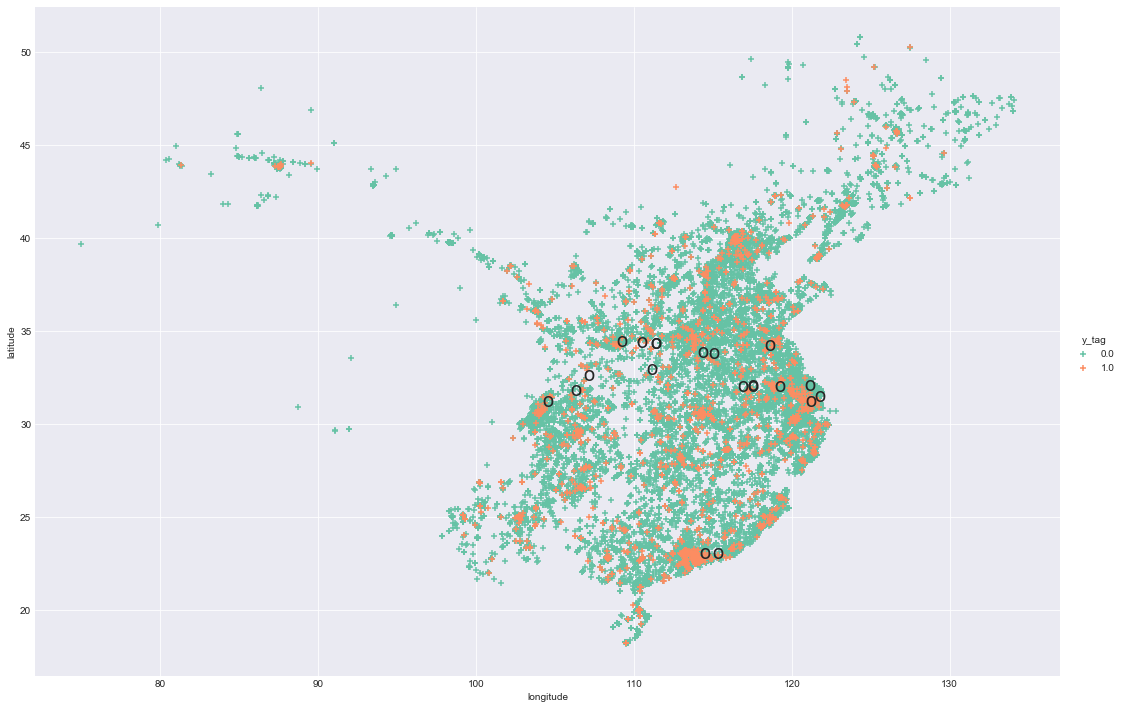

In [1059]:
# 设置背景
sns.set_style("darkgrid")

sns.pairplot(data_set[(data_set.longitude>0)&(data_set.latitude>15)]
           , palette="Set2",markers="+"
           , x_vars=["longitude"]
           , y_vars=["latitude"]
           , size=10
           , aspect=1.5
           , hue='y_tag')

# 在图纸上画出分布
for key in UnNormal_gps_dict.keys():
    a=UnNormal_gps_dict[key][1]
    b=UnNormal_gps_dict[key][0]
    plt.annotate('o', xy=(a, b), xytext=(a, b), fontsize=20)

#  , arrowprops=dict(facecolor='black', shrink=10, headwidth=1, width=1)

### GPS方圆N公里

In [1012]:
# 计算经纬度距离
EARTH_RADIUS=6371           # 地球平均半径，6371km

def hav(theta):
    s = sin(theta / 2)
    return s * s
 
def get_distance_hav(lat0, lng0, lat1, lng1):
    lat0 = radians(lat0)
    lat1 = radians(lat1)
    lng0 = radians(lng0)
    lng1 = radians(lng1)
 
    dlng = fabs(lng0 - lng1)
    dlat = fabs(lat0 - lat1)
    h = hav(dlat) + cos(lat0) * cos(lat1) * hav(dlng)
    distance = 2 * EARTH_RADIUS * asin(sqrt(h))
 
    return distance

In [1060]:
Long=[]
Lat=[]
for i in range(len(UnNormal_gps)):
    Long.append(float(UnNormal_gps[i].split('_')[0]))
    Lat.append(float(UnNormal_gps[i].split('_')[1]))


UnNormal_gps_dict=dict()
for i in range(len(UnNormal_gps)):
    UnNormal_gps_dict['key'+str(i)]=[Long[i],Lat[i]]


UnNormal_gps_dict

{'key0': [22.7756913027, 114.129425904],
 'key1': [22.7554992696, 114.973726323],
 'key10': [31.8140221786, 117.194215997],
 'key11': [32.6478134311, 110.788377965],
 'key12': [31.7982400641, 120.784423017],
 'key13': [34.1878741781, 108.872322041],
 'key14': [34.0660240124, 111.070618903],
 'key15': [34.065839626, 111.067844169],
 'key16': [31.5617836692, 106.003820133],
 'key17': [31.2173848254, 121.423592831],
 'key18': [32.332258105, 106.82768032],
 'key19': [33.9577064962, 118.29450389],
 'key2': [30.9501557912, 120.884696263],
 'key3': [31.7586917607, 117.21147245],
 'key4': [30.9663172, 104.203967042],
 'key5': [31.7577889247, 116.534570005],
 'key6': [33.5480232175, 114.717471836],
 'key7': [33.5562913282, 114.000461171],
 'key8': [34.1103044856, 110.138208379],
 'key9': [31.7749309603, 118.876866283]}

In [1062]:
# 初始化
d=[[],[],[],[],[],[],[],[],[],[]
  ,[],[],[],[],[],[],[],[],[],[]]

print len(d)

20


In [1063]:
# d=[[]] * len(UnNormal_point.keys())
d=[[],[],[],[],[],[],[],[],[],[]
  ,[],[],[],[],[],[],[],[],[],[]]


# 构建逻辑变量
data_set['latitude']=data_set['latitude'].fillna(0)
data_set['longitude']=data_set['longitude'].fillna(0)

for j in range(len(d)):
    for i in range(data_set.shape[0]):
        d[j].append(int(get_distance_hav(data_set['latitude'][i],data_set['longitude'][i],UnNormal_gps_dict[UnNormal_gps_dict.keys()[j]][0],UnNormal_gps_dict[UnNormal_gps_dict.keys()[j]][1])))
    data_set[str('d')+str(j)]=d[j]       


data_set.head(1)

,mobile_hash,create_dt,create_time,create_unix_time,phone_md5,uuid,fig_age,marital_status,edu_level,loan_willing,mortgage,is_car_loan,violation_level,credit_level,customer_value,is_loan,lbs_cnt,price_max,price_min,diff_price,is_have,probability,is_predict,concen_degree,stage,convert_level,convert_prob,car_age_0,minage,maxage,credit_card_1_day,credit_card_3_day,credit_card_5_day,credit_card_7_day,credit_card_14_day,credit_card_30_day,credit_card_60_day,diff_inst_dt,diff_pass_dt,diff_active_dt,diff_pay_dt,cnt_active_1_day,dist_act_platform_1_day,dist_dt_1_day,cnt_jxd_1_day,cnt_chexian_1_day,cnt_daik_page_1_day,cnt_active_3_day,dist_act_platform_3_day,dist_dt_3_day,cnt_jxd_3_day,cnt_chexian_3_day,cnt_daik_page_3_day,cnt_active_5_day,dist_act_platform_5_day,dist_dt_5_day,cnt_jxd_5_day,cnt_chexian_5_day,cnt_daik_page_5_day,cnt_active_7_day,dist_act_platform_7_day,dist_dt_7_day,cnt_jxd_7_day,cnt_chexian_7_day,cnt_daik_page_7_day,cnt_active_14_day,dist_act_platform_14_day,dist_dt_14_day,cnt_jxd_14_day,cnt_chexian_14_day,cnt_daik_page_14_day,cnt_active_30_day,dist_act_platform_30_day,dist_dt_30_day,cnt_jxd_30_day,cnt_chexian_30_day,cnt_daik_page_30_day,cnt_queryword_1_day,cnt_daik_1_day,cnt_lix_1_day,cnt_shouf_1_day,cnt_qian_1_day,cnt_hfh6_1_day,cnt_dz_1_day,cnt_kll_1_day,cnt_sy_1_day,cnt_yg_1_day,cnt_ly_1_day,cnt_yx_1_day,cnt_bc_1_day,cnt_mt_1_day,cnt_kmr_1_day,cnt_pst_1_day,cnt_bm3_1_day,cnt_ft_1_day,cnt_p_dz_1_day,cnt_p_kll_1_day,cnt_p_sy_1_day,cnt_p_yg_1_day,cnt_p_ly_1_day,cnt_p_yx_1_day,cnt_p_bc_1_day,cnt_p_mt_1_day,cnt_p_kmr_1_day,cnt_p_pst_1_day,cnt_p_bm3_1_day,cnt_p_ft_1_day,cnt_p_daik_1_day,cnt_p_lix_1_day,cnt_p_shouf_1_day,cnt_p_qian_1_day,cnt_p_hfh6_1_day,dist_platform_1_day,dist_querydt_1_day,cnt_queryword_3_day,cnt_daik_3_day,cnt_lix_3_day,cnt_shouf_3_day,cnt_qian_3_day,cnt_hfh6_3_day,cnt_dz_3_day,cnt_kll_3_day,cnt_sy_3_day,cnt_yg_3_day,cnt_ly_3_day,cnt_yx_3_day,cnt_bc_3_day,cnt_mt_3_day,cnt_kmr_3_day,cnt_pst_3_day,cnt_bm3_3_day,cnt_ft_3_day,cnt_p_dz_3_day,cnt_p_kll_3_day,cnt_p_sy_3_day,cnt_p_yg_3_day,cnt_p_ly_3_day,cnt_p_yx_3_day,cnt_p_bc_3_day,cnt_p_mt_3_day,cnt_p_kmr_3_day,cnt_p_pst_3_day,cnt_p_bm3_3_day,cnt_p_ft_3_day,cnt_p_daik_3_day,cnt_p_lix_3_day,cnt_p_shouf_3_day,cnt_p_qian_3_day,cnt_p_hfh6_3_day,dist_platform_3_day,dist_querydt_3_day,cnt_queryword_5_day,cnt_daik_5_day,cnt_lix_5_day,cnt_shouf_5_day,cnt_qian_5_day,cnt_hfh6_5_day,cnt_dz_5_day,cnt_kll_5_day,cnt_sy_5_day,cnt_yg_5_day,cnt_ly_5_day,cnt_yx_5_day,cnt_bc_5_day,cnt_mt_5_day,cnt_kmr_5_day,cnt_pst_5_day,cnt_bm3_5_day,cnt_ft_5_day,cnt_p_dz_5_day,cnt_p_kll_5_day,cnt_p_sy_5_day,cnt_p_yg_5_day,cnt_p_ly_5_day,cnt_p_yx_5_day,cnt_p_bc_5_day,cnt_p_mt_5_day,cnt_p_kmr_5_day,cnt_p_pst_5_day,cnt_p_bm3_5_day,cnt_p_ft_5_day,cnt_p_daik_5_day,cnt_p_lix_5_day,cnt_p_shouf_5_day,cnt_p_qian_5_day,cnt_p_hfh6_5_day,dist_platform_5_day,dist_querydt_5_day,cnt_queryword_7_day,cnt_daik_7_day,cnt_lix_7_day,cnt_shouf_7_day,cnt_qian_7_day,cnt_hfh6_7_day,cnt_dz_7_day,cnt_kll_7_day,cnt_sy_7_day,cnt_yg_7_day,cnt_ly_7_day,cnt_yx_7_day,cnt_bc_7_day,cnt_mt_7_day,cnt_kmr_7_day,cnt_pst_7_day,cnt_bm3_7_day,cnt_ft_7_day,cnt_p_dz_7_day,cnt_p_kll_7_day,cnt_p_sy_7_day,cnt_p_yg_7_day,cnt_p_ly_7_day,cnt_p_yx_7_day,cnt_p_bc_7_day,cnt_p_mt_7_day,cnt_p_kmr_7_day,cnt_p_pst_7_day,cnt_p_bm3_7_day,cnt_p_ft_7_day,cnt_p_daik_7_day,cnt_p_lix_7_day,cnt_p_shouf_7_day,cnt_p_qian_7_day,cnt_p_hfh6_7_day,dist_platform_7_day,dist_querydt_7_day,cnt_queryword_14_day,cnt_daik_14_day,cnt_lix_14_day,cnt_shouf_14_day,cnt_qian_14_day,cnt_hfh6_14_day,cnt_dz_14_day,cnt_kll_14_day,cnt_sy_14_day,cnt_yg_14_day,cnt_ly_14_day,cnt_yx_14_day,cnt_bc_14_day,cnt_mt_14_day,cnt_kmr_14_day,cnt_pst_14_day,cnt_bm3_14_day,cnt_ft_14_day,cnt_p_dz_14_day,cnt_p_kll_14_day,cnt_p_sy_14_day,cnt_p_yg_14_day,cnt_p_ly_14_day,cnt_p_yx_14_day,cnt_p_bc_14_day,cnt_p_mt_14_day,cnt_p_kmr_14_day,cnt_p_pst_14_day,cnt_p_bm3_14_day,cnt_p_ft_14_day,cnt_p_daik_14_day,cnt_p_lix_14_day,cnt_p_shouf_14_day,cnt_p_qian_14_day,cnt_p_hfh6_14_day,dist_platform_14_day,dist_

### 方圆N公里逾期率

In [326]:
# data_set=data_set.drop(['d10'], axis = 1)
# data_set.shape

(44006, 403)

In [1068]:
# 初始化距离
N_km=2

data_set['gps_km']=((data_set.d0<=N_km)|(data_set.d1<=N_km)|(data_set.d2<=N_km)|(data_set.d3<=N_km)
                   |(data_set.d4<=N_km)|(data_set.d5<=N_km)|(data_set.d6<=N_km)|(data_set.d7<=N_km)
                   |(data_set.d8<=N_km)|(data_set.d9<=N_km)|(data_set.d10<=N_km)|(data_set.d11<=N_km)
                   |(data_set.d12<=N_km)|(data_set.d13<=N_km)|(data_set.d14<=N_km)|(data_set.d15<=N_km)
                   |(data_set.d16<=N_km)|(data_set.d17<=N_km)|(data_set.d18<=N_km)|(data_set.d19<=N_km))

In [1069]:
# 不同设备用信人数, 逾期人数和逾期率
data_set.pivot_table(values=['y_tag'],index='gps_km',aggfunc=[np.size,np.sum,np.mean])
# ,columns='create_month'

,size,sum,mean
,y_tag,y_tag,y_tag
gps_km,,,
False,38251.0,1566.0,0.040951
True,219.0,33.0,0.150685


### 结论

* 拉黑以下GPS, 方圆2KM内申请用户直接拉黑

* 注意,上述是以**8月份**数据降序排列选择的TOP点, 最终的黑GPS库应分别按照每个月的异常GPS汇总


In [1070]:
print len(UnNormal_gps),UnNormal_gps

20 ['22.7756913027_114.129425904', '22.7554992696_114.973726323', '30.9501557912_120.884696263', '31.7586917607_117.21147245', '30.9663172_104.203967042', '31.7577889247_116.534570005', '33.5480232175_114.717471836', '33.5562913282_114.000461171', '34.1103044856_110.138208379', '31.7749309603_118.876866283', '31.8140221786_117.194215997', '32.6478134311_110.788377965', '31.7982400641_120.784423017', '34.1878741781_108.872322041', '34.0660240124_111.070618903', '34.065839626_111.067844169', '31.5617836692_106.003820133', '31.2173848254_121.423592831', '32.332258105_106.82768032', '33.9577064962_118.29450389']


In [1071]:
gps_result=data_set.pivot_table(values=['y_tag'],index='gps_km',aggfunc=[np.size,np.sum,np.mean])
gps_result.index
gps_result[gps_result.index==True]
gps_result[gps_result.index==True]['sum'].sum()

y_tag    33.0
dtype: float64

In [1072]:
gps_result=data_set.pivot_table(values=['y_tag'],index='gps_km',aggfunc=[np.size,np.sum,np.mean])
a1=gps_result[gps_result.index==True]['size'].sum()
a2=gps_result[gps_result.index==True]['sum'].sum()

print '拒绝人数 : %.2f%%'%(a1/data_set.shape[0]*100)
print '逾期率 : %.2f%%'%(a2/a1*100)
print '召回率 : %.2f%%'%(a2/data_set['y_tag'].sum()*100)

拒绝人数 : 0.57%
逾期率 : 15.07%
召回率 : 2.06%


## 多头

### 总揽

In [1074]:
# 不同设备用信人数, 逾期人数和逾期率
duotou_7_trend=data_set.pivot_table(values=['y_tag'],index='cnt_duotou_7_day',columns='create_month',aggfunc=[np.size,np.sum,np.mean])
duotou_7_trend

size                                                  \
                   y_tag                                                   
create_month     2018-01 2018-02 2018-03 2018-04 2018-05 2018-06 2018-07   
cnt_duotou_7_day                                                           
0.0                247.0   356.0   683.0  1413.0   884.0   876.0  1281.0   
1.0               1411.0  1159.0  1753.0  1350.0  1214.0  1757.0  1889.0   
2.0                566.0   602.0   891.0   617.0   594.0   776.0   721.0   
3.0                101.0   193.0   385.0   211.0   138.0   193.0   209.0   
4.0                 11.0    47.0    97.0    41.0    18.0    60.0    73.0   
5.0                  7.0     7.0    11.0     8.0     6.0    15.0    12.0   
6.0                  1.0     1.0     7.0     NaN     NaN     6.0    11.0   
7.0                  NaN     1.0     NaN     1.0     NaN     NaN     1.0   
8.0                  NaN     NaN     NaN     NaN     NaN     1.0     NaN   
10.0                 NaN     NaN     NaN     NaN     NaN     NaN     NaN   
11.0                 NaN     NaN     NaN     NaN     NaN     NaN     NaN   
12.0                 NaN     NaN     NaN     NaN     NaN     NaN     NaN   

                                             sum                          \
                                           y_tag                           
create_month     2018-08 2018-09 2018-10 2018-01 2018-02 2018-03 2018-04   
cnt_duotou_7_day                                                           
0.0                999.0  1195.0  1230.0     0.0     0.0     0.0    82.0   
1.0               2123.0  2597.0  2650.0     0.0     0.0     0.0   108.0   
2.0                735.0   914.0   886.0     0.0     0.0     0.0    74.0   
3.0                278.0   285.0   257.0     0.0     0.0     0.0    27.0   
4.0                 90.0    96.0    91.0     0.0     0.0     0.0     3.0   
5.0                 29.0    17.0    25.0     0.0     0.0     0.0     0.0   
6.0                 10.0     5.0     4.0     0.0     0.0     0.0     NaN   
7.0                  3.0     1.0     6.0     NaN     0.0     NaN     0.0   
8.0                  2.0     NaN     NaN     NaN     NaN     NaN     NaN   
10.0                 NaN     NaN     1.0     NaN     NaN     NaN     NaN   
11.0                 1.0     NaN     NaN     NaN     NaN     NaN     NaN   
12.0                 1.0     NaN     NaN     NaN     NaN     NaN     NaN   

                                                                    mean  \
                                                                   y_tag   
create_month     2018-05 2018-06 2018-07 2018-08 2018-09 2018-10 2018-01   
cnt_duotou_7_day                                                           
0.0                 44.0    52.0    56.0    34.0    27.0    27.0     0.0   
1.0                 80.0   128.0   113.0   103.0   117.0   134.0     0.0   
2.0                 42.0    50.0    41.0    40.0    39.0    46.0     0.0   
3.0                  9.0    18.0    10.0    28.0    13.0     8.0     0.0   
4.0                  3.0    10.0     3.0     5.0     3.0     1.0     0.0   
5.0                  0.0     2.0     0.0     0.0     0.0     2.0     0.0   
6.0                  NaN     0.0     0.0     1.0     0.0     0.0     0.0   
7.0                  NaN     NaN     0.0     0.0     0.0     0.0     NaN   
8.0                  NaN     0.0     NaN     0.0     NaN     NaN     NaN   
10.0                 NaN     NaN     NaN     NaN     NaN     0.0     NaN   
11.0                 NaN     NaN     NaN     0.0     NaN     NaN     NaN   
12.0                 NaN     NaN     NaN     0.0     NaN     NaN     NaN   

                                                                          \
                                                                           
create_month     2018-02 2018-03   2018-04   2018-05   2018-06   2018-07   
cnt_duotou_7_day                                                           
0.0                  0.0     0.0  0.058115  0.049943  0.059429  0

### 用信人数趋势

In [1075]:
# 从逾期人数维度观察
duotou_7_trend_size=duotou_7_trend['size']['y_tag'].sort_values(by=['2018-10'],ascending=False,inplace=False)
duotou_7_trend_size

create_month,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10
cnt_duotou_7_day,,,,,,,,,,
1.0,1411.0,1159.0,1753.0,1350.0,1214.0,1757.0,1889.0,2123.0,2597.0,2650.0
0.0,247.0,356.0,683.0,1413.0,884.0,876.0,1281.0,999.0,1195.0,1230.0
2.0,566.0,602.0,891.0,617.0,594.0,776.0,721.0,735.0,914.0,886.0
3.0,101.0,193.0,385.0,211.0,138.0,193.0,209.0,278.0,285.0,257.0
4.0,11.0,47.0,97.0,41.0,18.0,60.0,73.0,90.0,96.0,91.0
5.0,7.0,7.0,11.0,8.0,6.0,15.0,12.0,29.0,17.0,25.0
7.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,3.0,1.0,6.0
6.0,1.0,1.0,7.0,NaN,NaN,6.0,11.0,10.0,5.0,4.0
10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


### 逾期人数趋势

In [1076]:
# 从逾期人数维度观察
duotou_7_trend_sum=duotou_7_trend['sum']['y_tag'].sort_values(by=['2018-10'],ascending=False,inplace=False)
duotou_7_trend_sum

create_month,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10
cnt_duotou_7_day,,,,,,,,,,
1.0,0.0,0.0,0.0,108.0,80.0,128.0,113.0,103.0,117.0,134.0
2.0,0.0,0.0,0.0,74.0,42.0,50.0,41.0,40.0,39.0,46.0
0.0,0.0,0.0,0.0,82.0,44.0,52.0,56.0,34.0,27.0,27.0
3.0,0.0,0.0,0.0,27.0,9.0,18.0,10.0,28.0,13.0,8.0
5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0
4.0,0.0,0.0,0.0,3.0,3.0,10.0,3.0,5.0,3.0,1.0
6.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0
7.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0
10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


### 逾期率趋势

In [1077]:
# 从逾期人数维度观察
duotou_7_trend_mean=duotou_7_trend['mean']['y_tag'].sort_values(by=['2018-10'],ascending=False,inplace=False)
duotou_7_trend_mean

create_month,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10
cnt_duotou_7_day,,,,,,,,,,
5.0,0.0,0.0,0.0,0.000000,0.000000,0.133333,0.000000,0.000000,0.000000,0.080000
2.0,0.0,0.0,0.0,0.119935,0.070707,0.064516,0.056865,0.054422,0.042670,0.051919
1.0,0.0,0.0,0.0,0.080000,0.065898,0.072851,0.059820,0.048516,0.045052,0.050566
3.0,0.0,0.0,0.0,0.127962,0.065217,0.093264,0.047847,0.100719,0.045614,0.031128
0.0,0.0,0.0,0.0,0.058115,0.049943,0.059429,0.043716,0.034034,0.022594,0.021951
4.0,0.0,0.0,0.0,0.073171,0.166667,0.166667,0.041096,0.055556,0.031250,0.010989
6.0,0.0,0.0,0.0,NaN,NaN,0.000000,0.000000,0.100000,0.000000,0.000000
7.0,NaN,0.0,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000
10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


### 热力图趋势

[Text(0.5,0,u'2018-01'),
 Text(1.5,0,u'2018-02'),
 Text(2.5,0,u'2018-03'),
 Text(3.5,0,u'2018-04'),
 Text(4.5,0,u'2018-05'),
 Text(5.5,0,u'2018-06'),
 Text(6.5,0,u'2018-07'),
 Text(7.5,0,u'2018-08'),
 Text(8.5,0,u'2018-09'),
 Text(9.5,0,u'2018-10')]

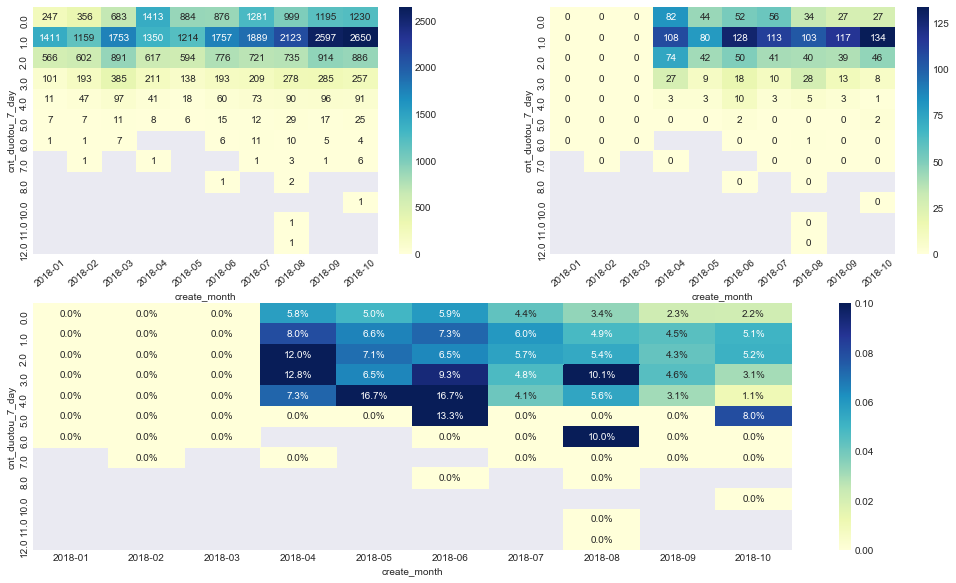

In [1078]:
# 多头次数排序
DT_sort_value_index=duotou_7_trend_size.index.tolist()
DT_sort_value_index.sort()


# 布局
fig = plt.figure(figsize=(17, 10))
axes1=fig.add_subplot(221)
axes2=fig.add_subplot(222)
axes3=fig.add_subplot(212)

# 逾期人数热力图
sns.heatmap(duotou_7_trend_size.loc[DT_sort_value_index],vmin=0,annot=True,cmap="YlGnBu",fmt="0.0f",ax=axes1)
sns.heatmap(duotou_7_trend_sum.loc[DT_sort_value_index],annot=True,cmap="YlGnBu",fmt="0.0f",ax=axes2)
sns.heatmap(duotou_7_trend_mean.loc[DT_sort_value_index],annot=True,cmap="YlGnBu",vmin=0, vmax=0.1,fmt="0.1%",ax=axes3)

# 坐标轴方向
axes1.set_xticklabels(axes1.get_xticklabels(), rotation=40)
axes2.set_xticklabels(axes2.get_xticklabels(), rotation=40)
# axes3.set_xticklabels(axes3.get_xticklabels(), rotation=45)

### 手动分段

In [1747]:
data_set.loc[data_set.cnt_duotou_7_day == 0, 'cnt_duotou_7_day_cut'] = 0
data_set.loc[data_set.cnt_duotou_7_day == 1, 'cnt_duotou_7_day_cut'] = 1
data_set.loc[data_set.cnt_duotou_7_day == 2, 'cnt_duotou_7_day_cut'] = 2
data_set.loc[data_set.cnt_duotou_7_day >= 3, 'cnt_duotou_7_day_cut'] = 3

In [1748]:
# 不同设备用信人数, 逾期人数和逾期率
duotou_7_trend=data_set.pivot_table(values=['y_tag'],index='cnt_duotou_7_day_cut',columns='create_month',aggfunc=[np.size,np.sum,np.mean])
duotou_7_trend

size                                                  \
                       y_tag                                                   
create_month         2018-01 2018-02 2018-03 2018-04 2018-05 2018-06 2018-07   
cnt_duotou_7_day_cut                                                           
0.0                    218.0   293.0   532.0  1084.0   729.0   786.0  1161.0   
1.0                   1217.0   950.0  1474.0  1182.0  1143.0  1659.0  1785.0   
2.0                    476.0   488.0   737.0   546.0   551.0   729.0   696.0   
3.0                    100.0   201.0   409.0   235.0   147.0   261.0   286.0   

                                                 sum                          \
                                               y_tag                           
create_month         2018-08 2018-09 2018-10 2018-01 2018-02 2018-03 2018-04   
cnt_duotou_7_day_cut                                                           
0.0                    916.0  1107.0  1147.0     0.0     0.0     0.0    59.0   
1.0                   2032.0  2501.0  2566.0     0.0     0.0     0.0    96.0   
2.0                    702.0   865.0   865.0     0.0     0.0     0.0    57.0   
3.0                    394.0   381.0   371.0     0.0     0.0     0.0    28.0   

                                                                        mean  \
                                                                       y_tag   
create_month         2018-05 2018-06 2018-07 2018-08 2018-09 2018-10 2018-01   
cnt_duotou_7_day_cut                                                           
0.0                     38.0    41.0    54.0    30.0    26.0    26.0     0.0   
1.0                     75.0   117.0   102.0    98.0   114.0   132.0     0.0   
2.0                     41.0    49.0    39.0    37.0    37.0    45.0     0.0   
3.0                     11.0    27.0    13.0    34.0    14.0    11.0     0.0   

                                                                              \
                                                                               
create_month         2018-02 2018-03   2018-04   2018-05   2018-06   2018-07   
cnt_duotou_7_day_cut                                                           
0.0                      0.0     0.0  0.054428  0.052126  0.052163  0.046512   
1.0                      0.0     0.0  0.081218  0.065617  0.070524  0.057143   
2.0                      0.0     0.0  0.104396  0.074410  0.067215  0.056034   
3.0                      0.0     0.0  0.119149  0.074830  0.103448  0.045455   

                                                    
                                                    
create_month           2018-08   2018-09   2018-10  
cnt_duotou_7_day_cut                                
0.0                   0.032751  0.023487  0.022668  
1.0                   0.048228  0.045582  0.051442  
2.0                   0.052707  0.042775  0.052023  
3.0                   0.086294  0.036745  0.029650

### 结论

* 整体而言, 多头倾向与逾期率呈现正相关性

* 但是就9,10月份而言, 直接拒绝多头指数为1以上的用户, 影响面较广, 慎用

## 注册时间差

### 小时转化为天

In [1490]:
# 转化为天
data_set['delta_reg_time']=data_set['delta_reg_time'].fillna(0)
delta_reg_day=[]
for i in data_set['delta_reg_time']:
    delta_reg_day.append(int(i/24))


data_set['delta_reg_day']=delta_reg_day

In [1491]:
data_set.groupby(['delta_reg_day']).y_tag.agg([np.size,np.sum,np.mean]).head()

,size,sum,mean
delta_reg_day,,,
0,7384.0,450.0,0.060943
1,390.0,13.0,0.033333
2,336.0,11.0,0.032738
3,283.0,10.0,0.035336
4,239.0,9.0,0.037657


### 手动分组

In [1701]:
data_set.loc[data_set.delta_reg_day == 0, 'delta_reg_day_cut'] = 0
data_set.loc[(data_set.delta_reg_day >=1)&(data_set.delta_reg_day <=7), 'delta_reg_day_cut'] = 7
data_set.loc[(data_set.delta_reg_day >7)&(data_set.delta_reg_day <=30), 'delta_reg_day_cut'] = 30
data_set.loc[(data_set.delta_reg_day >30)&(data_set.delta_reg_day <=180), 'delta_reg_day_cut'] = 180
data_set.loc[data_set.delta_reg_day >180, 'delta_reg_day_cut'] = 181

### 总揽

In [1249]:
delta_reg_day_trend=data_set.pivot_table(values=['y_tag'],index='create_month',columns=['delta_reg_day_cut'],aggfunc=[np.size,np.sum,np.mean])
delta_reg_day_trend

size                                 sum              \
                    y_tag                               y_tag               
delta_reg_day_cut   0.0    7.0    30.0   180.0   181.0  0.0   7.0   30.0    
create_month                                                                
2018-01             573.0  202.0  262.0  661.0  1152.0    0.0   0.0   0.0   
2018-02             504.0  190.0  173.0  523.0  1130.0    0.0   0.0   0.0   
2018-03             734.0  271.0  327.0  816.0  1785.0    0.0   0.0   0.0   
2018-04             507.0  178.0  308.0  920.0  1800.0   61.0  17.0  18.0   
2018-05             438.0  118.0  151.0  584.0  1604.0   38.0   4.0  13.0   
2018-06             619.0  172.0  168.0  676.0  2084.0   64.0  10.0   9.0   
2018-07             605.0  146.0  182.0  766.0  2527.0   53.0   4.0  17.0   
2018-08             716.0  120.0  163.0  621.0  2678.0   56.0   3.0   9.0   
2018-09            1072.0  211.0  246.0  605.0  3005.0   61.0   9.0   4.0   
2018-10            1612.0  233.0  203.0  518.0  2611.0  117.0  11.0   3.0   

                                    mean                                \
                                   y_tag                                 
delta_reg_day_cut 180.0  181.0     0.0       7.0       30.0      180.0   
create_month                                                             
2018-01             0.0    0.0  0.000000  0.000000  0.000000  0.000000   
2018-02             0.0    0.0  0.000000  0.000000  0.000000  0.000000   
2018-03             0.0    0.0  0.000000  0.000000  0.000000  0.000000   
2018-04            77.0  127.0  0.120316  0.095506  0.058442  0.083696   
2018-05            32.0   92.0  0.086758  0.033898  0.086093  0.055077   
2018-06            46.0  134.0  0.103393  0.058140  0.053571  0.068148   
2018-07            37.0  115.0  0.087603  0.027397  0.093407  0.048303   
2018-08            33.0  110.0  0.078212  0.025000  0.055215  0.053140   
2018-09            18.0  110.0  0.056903  0.042654  0.016260  0.029752   
2018-10            17.0   70.0  0.072581  0.047210  0.014778  0.032819   

                             
                             
delta_reg_day_cut     181.0  
create_month                 
2018-01            0.000000  
2018-02            0.000000  
2018-03            0.000000  
2018-04            0.070634  
2018-05            0.057357  
2018-06            0.064330  
2018-07            0.045509  
2018-08            0.041075  
2018-09            0.036606  
2018-10            0.026810

### 注册时间差热力图

In [1253]:
delta_reg_day_trend=data_set.pivot_table(values=['y_tag'],index='delta_reg_day_cut',columns=['create_month'],aggfunc=[np.size,np.sum,np.mean])
delta_reg_day_trend

size                                                  \
                    y_tag                                                   
create_month      2018-01 2018-02 2018-03 2018-04 2018-05 2018-06 2018-07   
delta_reg_day_cut                                                           
0.0                 573.0   504.0   734.0   507.0   438.0   619.0   605.0   
7.0                 202.0   190.0   271.0   178.0   118.0   172.0   146.0   
30.0                262.0   173.0   327.0   308.0   151.0   168.0   182.0   
180.0               661.0   523.0   816.0   920.0   584.0   676.0   766.0   
181.0              1152.0  1130.0  1785.0  1800.0  1604.0  2084.0  2527.0   

                                              sum                          \
                                            y_tag                           
create_month      2018-08 2018-09 2018-10 2018-01 2018-02 2018-03 2018-04   
delta_reg_day_cut                                                           
0.0                 716.0  1072.0  1612.0     0.0     0.0     0.0    61.0   
7.0                 120.0   211.0   233.0     0.0     0.0     0.0    17.0   
30.0                163.0   246.0   203.0     0.0     0.0     0.0    18.0   
180.0               621.0   605.0   518.0     0.0     0.0     0.0    77.0   
181.0              2678.0  3005.0  2611.0     0.0     0.0     0.0   127.0   

                                                                     mean  \
                                                                    y_tag   
create_month      2018-05 2018-06 2018-07 2018-08 2018-09 2018-10 2018-01   
delta_reg_day_cut                                                           
0.0                  38.0    64.0    53.0    56.0    61.0   117.0     0.0   
7.0                   4.0    10.0     4.0     3.0     9.0    11.0     0.0   
30.0                 13.0     9.0    17.0     9.0     4.0     3.0     0.0   
180.0                32.0    46.0    37.0    33.0    18.0    17.0     0.0   
181.0                92.0   134.0   115.0   110.0   110.0    70.0     0.0   

                                                                           \
                                                                            
create_month      2018-02 2018-03   2018-04   2018-05   2018-06   2018-07   
delta_reg_day_cut                                                           
0.0                   0.0     0.0  0.120316  0.086758  0.103393  0.087603   
7.0                   0.0     0.0  0.095506  0.033898  0.058140  0.027397   
30.0                  0.0     0.0  0.058442  0.086093  0.053571  0.093407   
180.0                 0.0     0.0  0.083696  0.055077  0.068148  0.048303   
181.0                 0.0     0.0  0.070634  0.057357  0.064330  0.045509   

                                                 
                                                 
create_month        2018-08   2018-09   2018-10  
delta_reg_day_cut                                
0.0                0.078212  0.056903  0.072581  
7.0                0.025000  0.042654  0.047210  
30.0               0.055215  0.016260  0.014778  
180.0              0.053140  0.029752  0.032819  
181.0              0.041075  0.036606  0.026810

[Text(0.5,0,u'2018-01'),
 Text(1.5,0,u'2018-02'),
 Text(2.5,0,u'2018-03'),
 Text(3.5,0,u'2018-04'),
 Text(4.5,0,u'2018-05'),
 Text(5.5,0,u'2018-06'),
 Text(6.5,0,u'2018-07'),
 Text(7.5,0,u'2018-08'),
 Text(8.5,0,u'2018-09'),
 Text(9.5,0,u'2018-10')]

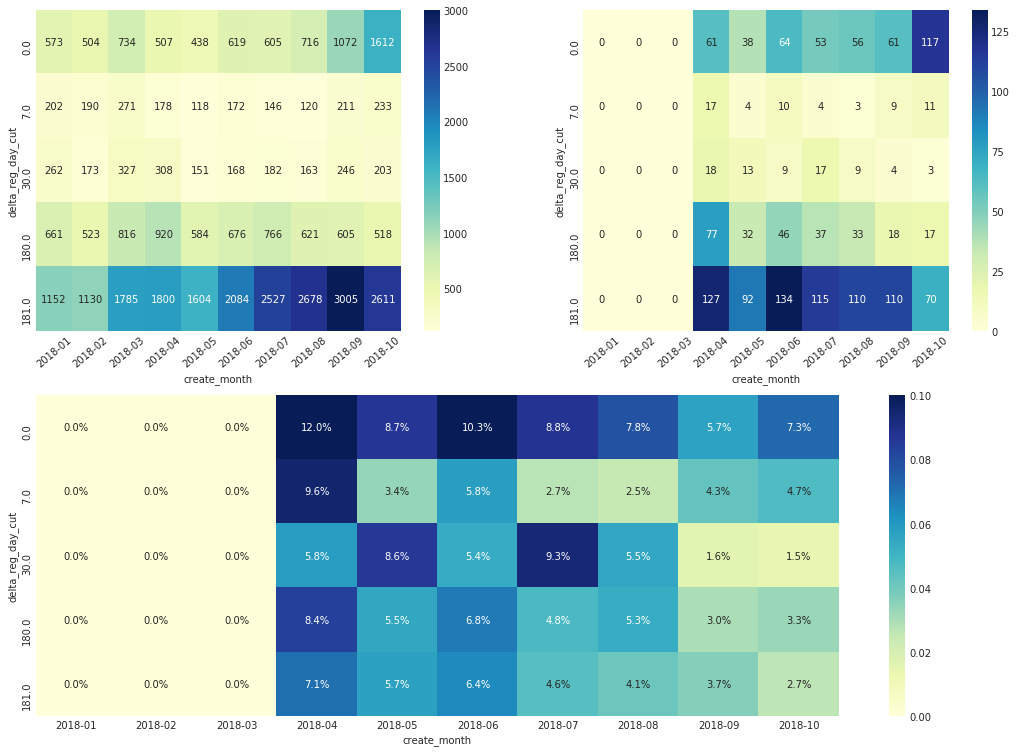

In [1257]:
# 布局
fig = plt.figure(figsize=(18, 13))
axes1=fig.add_subplot(221)
axes2=fig.add_subplot(222)
axes3=fig.add_subplot(212)

# 逾期人数热力图
sns.heatmap(delta_reg_day_trend['size']['y_tag'],annot=True,cmap="YlGnBu",fmt="0.0f",ax=axes1)
sns.heatmap(delta_reg_day_trend['sum']['y_tag'],annot=True,cmap="YlGnBu",fmt="0.0f",ax=axes2)
sns.heatmap(delta_reg_day_trend['mean']['y_tag'],annot=True,cmap="YlGnBu",vmin=0, vmax=0.1,fmt="0.1%",ax=axes3)

# 坐标轴方向
axes1.set_xticklabels(axes1.get_xticklabels(), rotation=40)
axes2.set_xticklabels(axes2.get_xticklabels(), rotation=40)
# axes3.set_xticklabels(axes3.get_xticklabels(), rotation=45)

### 结论

* 注册申请时间差与逾期率呈反比

* 注册申请时间差不足1天的用户风险最高, 随着两者时间差的增大, 风险逐渐下降

## 设备创建时间差

In [1497]:
# 申请和设备创建时间差 
data_set[['create_dt','first_login_day','delta_apply_first_day']].head(1)

,create_dt,first_login_day,delta_apply_first_day
0,2018-04-23,2018-02-28,54


### 总揽

In [1575]:
data_set.groupby(['delta_apply_first_day']).y_tag.agg([np.size,np.sum,np.mean]).head()

,size,sum,mean
delta_apply_first_day,,,
-322,1.0,0.0,0.0
-309,1.0,0.0,0.0
-301,1.0,0.0,0.0
-288,1.0,0.0,0.0
-284,1.0,0.0,0.0


### 手动分段

In [1702]:
# 部分匹配不上, 或者异常值均设置为-1
data_set.loc[data_set.delta_apply_first_day < 0, 'delta_apply_first_day_cut'] = -1
data_set.loc[data_set.delta_apply_first_day == 0, 'delta_apply_first_day_cut'] = 0
data_set.loc[(data_set.delta_apply_first_day >=1)&(data_set.delta_apply_first_day <=7), 'delta_apply_first_day_cut'] = 7
data_set.loc[(data_set.delta_apply_first_day >7)&(data_set.delta_apply_first_day <=30), 'delta_apply_first_day_cut'] = 30
data_set.loc[(data_set.delta_apply_first_day >30)&(data_set.delta_apply_first_day <=180), 'delta_apply_first_day_cut'] = 180
data_set.loc[data_set.delta_apply_first_day >180, 'delta_apply_first_day_cut'] = 181

In [1584]:
# 逾期率跟设备创建时间成反比
delta_first_day_trend=data_set.pivot_table(values=['y_tag'],index='delta_apply_first_day_cut',aggfunc=[np.size,np.sum,np.mean])
delta_first_day_trend

,size,sum,mean
,y_tag,y_tag,y_tag
delta_apply_first_day_cut,,,
-1.0,1612.0,90.0,0.055831
0.0,2570.0,202.0,0.078599
7.0,1670.0,86.0,0.051497
30.0,1828.0,72.0,0.039387
180.0,6021.0,230.0,0.038212
181.0,21112.0,784.0,0.037148


In [1585]:
# 申请与设备创建时间差逾期率趋势
delta_first_day_trend=data_set.pivot_table(values=['y_tag'],index='create_month',columns='delta_apply_first_day_cut',aggfunc=[np.size,np.sum,np.mean])
delta_first_day_trend

size                                        sum  \
                           y_tag                                      y_tag   
delta_apply_first_day_cut -1.0    0.0    7.0    30.0   180.0   181.0 -1.0     
create_month                                                                  
2018-01                    118.0  120.0  140.0  193.0  524.0  1354.0    0.0   
2018-02                     99.0   95.0  117.0  121.0  463.0  1170.0    0.0   
2018-03                    145.0  134.0  221.0  204.0  703.0  1830.0    0.0   
2018-04                    126.0   95.0  116.0  219.0  746.0  1807.0    7.0   
2018-05                    126.0  115.0  151.0  137.0  475.0  1603.0   13.0   
2018-06                    206.0  176.0  152.0  161.0  589.0  2186.0   21.0   
2018-07                    177.0  174.0  156.0  180.0  667.0  2601.0   15.0   
2018-08                    180.0  237.0  149.0  168.0  623.0  2712.0   11.0   
2018-09                    221.0  501.0  226.0  233.0  634.0  3064.0   10.0   
2018-10                    214.0  923.0  242.0  212.0  597.0  2785.0   13.0   

                                                                  mean  \
                                                                 y_tag   
delta_apply_first_day_cut  0.0    7.0    30.0   180.0  181.0    -1.0     
create_month                                                             
2018-01                      0.0    0.0    0.0    0.0    0.0  0.000000   
2018-02                      0.0    0.0    0.0    0.0    0.0  0.000000   
2018-03                      0.0    0.0    0.0    0.0    0.0  0.000000   
2018-04                     16.0    6.0   18.0   62.0  136.0  0.055556   
2018-05                      9.0    9.0   11.0   29.0   95.0  0.103175   
2018-06                     22.0   18.0    9.0   33.0  133.0  0.101942   
2018-07                     10.0    8.0   10.0   33.0  135.0  0.084746   
2018-08                     28.0   12.0   11.0   34.0  103.0  0.061111   
2018-09                     37.0   10.0    6.0   21.0  109.0  0.045249   
2018-10                     80.0   23.0    7.0   18.0   73.0  0.060748   

                                                                             
                                                                             
delta_apply_first_day_cut     0.0       7.0       30.0      180.0     181.0  
create_month                                                                 
2018-01                    0.000000  0.000000  0.000000  0.000000  0.000000  
2018-02                    0.000000  0.000000  0.000000  0.000000  0.000000  
2018-03                    0.000000  0.000000  0.000000  0.000000  0.000000  
2018-04                    0.168421  0.051724  0.082192  0.083110  0.075346  
2018-05                    0.078261  0.059603  0.080292  0.061181  0.059301  
2018-06                    0.125000  0.118421  0.055901  0.056122  0.060870  
2018-07                    0.057471  0.051282  0.055556  0.049475  0.051903  
2018-08                    0.118143  0.080537  0.065476  0.054575  0.037979  
2018-09                    0.073852  0.044248  0.025751  0.033123  0.035574  
2018-10                    0.086674  0.095041  0.033019  0.030151  0.026212

### 设备创建时间差热力图

[Text(0.5,0,u'2018-01'),
 Text(1.5,0,u'2018-02'),
 Text(2.5,0,u'2018-03'),
 Text(3.5,0,u'2018-04'),
 Text(4.5,0,u'2018-05'),
 Text(5.5,0,u'2018-06'),
 Text(6.5,0,u'2018-07'),
 Text(7.5,0,u'2018-08'),
 Text(8.5,0,u'2018-09'),
 Text(9.5,0,u'2018-10')]

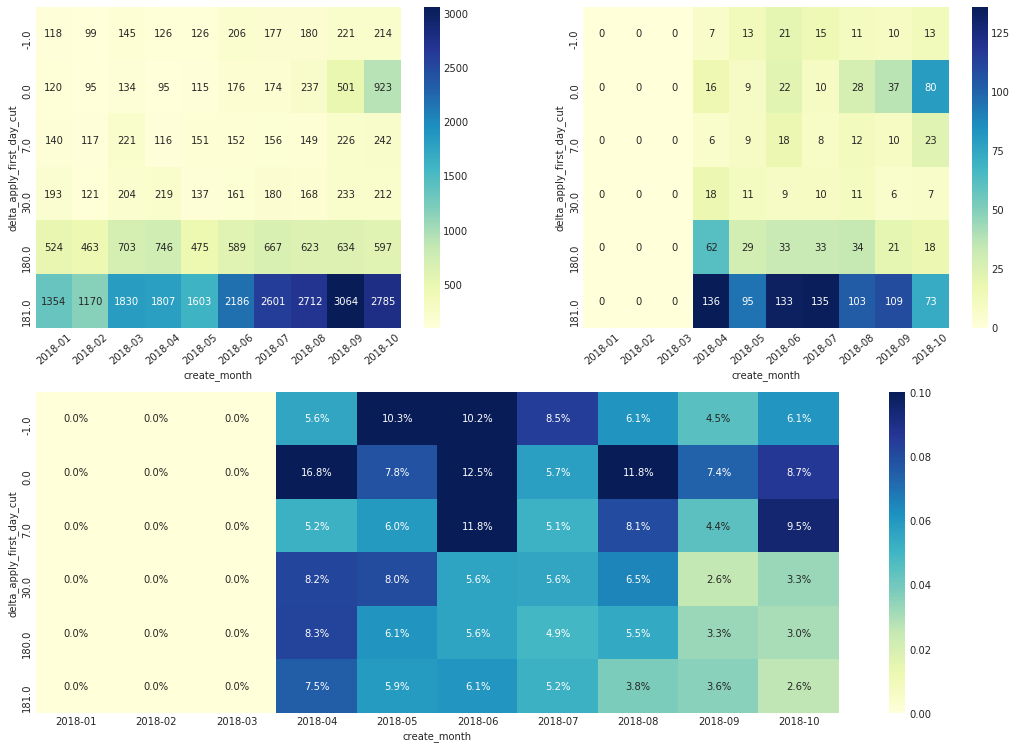

In [1592]:
# 布局
fig = plt.figure(figsize=(18, 13))
axes1=fig.add_subplot(221)
axes2=fig.add_subplot(222)
axes3=fig.add_subplot(212)

# 逾期人数热力图
sns.heatmap(delta_first_day_trend['size']['y_tag'].T,annot=True,cmap="YlGnBu",fmt="0.0f",ax=axes1)
sns.heatmap(delta_first_day_trend['sum']['y_tag'].T,annot=True,cmap="YlGnBu",fmt="0.0f",ax=axes2)
sns.heatmap(delta_first_day_trend['mean']['y_tag'].T,annot=True,cmap="YlGnBu",vmin=0, vmax=0.1,fmt="0.1%",ax=axes3)

# 坐标轴方向
axes1.set_xticklabels(axes1.get_xticklabels(), rotation=40)
axes2.set_xticklabels(axes2.get_xticklabels(), rotation=40)
# axes3.set_xticklabels(axes3.get_xticklabels(), rotation=45)

### 结论

* 如果设备创建时间和申请时间相差较近, 则逾期风险高

## 年龄

### 总揽

In [1085]:
# 不同设备用信人数, 逾期人数和逾期率
age_trend=data_set.pivot_table(values=['y_tag'],index='age',columns='create_month',aggfunc=[np.size,np.sum,np.mean])
age_trend

size                                                          \
               y_tag                                                           
create_month 2018-01 2018-02 2018-03 2018-04 2018-05 2018-06 2018-07 2018-08   
age                                                                            
23.0            19.0    20.0    50.0    50.0    57.0    91.0   143.0   129.0   
24.0           184.0   145.0   268.0   280.0   257.0   252.0   254.0   279.0   
25.0           215.0   180.0   300.0   296.0   269.0   290.0   317.0   337.0   
26.0           260.0   243.0   323.0   320.0   302.0   337.0   362.0   366.0   
27.0           257.0   231.0   348.0   370.0   248.0   345.0   411.0   395.0   
28.0           303.0   261.0   421.0   427.0   322.0   377.0   453.0   411.0   
29.0           215.0   202.0   346.0   313.0   240.0   314.0   373.0   388.0   
30.0           212.0   215.0   256.0   303.0   191.0   240.0   319.0   347.0   
31.0           166.0   168.0   328.0   225.0   216.0   239.0   274.0   273.0   
32.0           151.0   122.0   227.0   213.0   154.0   199.0   226.0   242.0   
33.0           122.0   111.0   168.0   166.0   120.0   167.0   196.0   202.0   
34.0            77.0    81.0   145.0   141.0    96.0   151.0   168.0   149.0   
35.0            89.0    99.0   125.0   123.0    87.0   116.0   125.0   116.0   
36.0           111.0    80.0    94.0    90.0    76.0   129.0   110.0   113.0   
37.0            53.0    63.0   103.0    91.0    59.0    85.0    83.0   108.0   
38.0            36.0    50.0    68.0    57.0    40.0    71.0    83.0    86.0   
39.0            50.0    29.0    69.0    40.0    30.0    48.0    82.0    60.0   
40.0            26.0    24.0    38.0    39.0    23.0    35.0    46.0    62.0   
41.0            16.0    18.0    34.0    29.0    21.0    33.0    34.0    41.0   
42.0            11.0    22.0    40.0    20.0    19.0    44.0    33.0    39.0   
43.0            19.0    27.0    28.0    25.0    13.0    34.0    26.0    17.0   
44.0            19.0    14.0    27.0    13.0     5.0    17.0    13.0    23.0   
45.0             4.0    11.0    28.0    16.0     9.0    14.0    14.0    20.0   
46.0             7.0     7.0    14.0    13.0    11.0    26.0    16.0    24.0   
47.0             9.0     9.0    12.0    11.0     8.0    14.0     9.0    19.0   
48.0             3.0     6.0     9.0    15.0     5.0     8.0     5.0    14.0   
49.0             5.0     6.0    12.0     8.0     8.0     8.0     5.0     9.0   
50.0             3.0     3.0     9.0     3.0     3.0     4.0     9.0     9.0   
51.0             4.0     NaN     3.0     NaN     2.0     7.0     4.0     6.0   
52.0             5.0     2.0     8.0     6.0     NaN     NaN     3.0     3.0   
53.0             1.0     2.0     3.0     4.0     NaN     1.0     NaN     5.0   
54.0             NaN     NaN     3.0     2.0     2.0     1.0     3.0     1.0   
55.0             7.0     1.0     1.0     3.0     2.0     3.0     2.0     NaN   
56.0             1.0     2.0     NaN     1.0     NaN     1.0     1.0     NaN   

                                 sum                                          \
                               y_tag                                           
create_month 2018-09 2018-10 2018-01 2018-02 2018-03 2018-04 2018-05 2018-06   
age                                                                            
23.0           242.0   261.0     0.0     0.0     0.0     3.0     6.0     7.0   
24.0           362.0   328.0     0.0     0.0     0.0    24.0    23.0    22.0   
25.0           403.0   419.0     0.0     0.0     0.0    15.0    14.0    26.0   
26.0           416.0   438.0     0.0     0.0     0.0    28.0    25.0    28.0   
27.0           455.0   484.0     0.0     0.0     0.0    35.0    19.0    35.0   
28.0           524.0   525.0     0.0     0.0     0.0    39.0    19.0    35.0   
29.0           406.0   392.0     0.0     0.0     0.0    17.0    13.0     8.0   
30.0           329.0   357.0     0.0     0.0     0.0    21.0     9.0     8.0   
31.0           

### 手动分组

In [1703]:
# 手动切分
data_set.loc[data_set.age<27, 'age_cut'] = 27
data_set.loc[(data_set.age >= 27)&(data_set.age<32), 'age_cut'] = 32
data_set.loc[(data_set.age >= 32)&(data_set.age<37), 'age_cut'] = 37
data_set.loc[(data_set.age >= 37)&(data_set.age<45), 'age_cut'] = 45
data_set.loc[data_set.age >= 45, 'age_cut'] = 46

In [1661]:
# 不同设备用信人数, 逾期人数和逾期率
age_cut_trend=data_set.pivot_table(values=['y_tag'],index='age_cut',columns='create_month',aggfunc=[np.size,np.sum,np.mean])
age_cut_trend

size                                                          \
               y_tag                                                           
create_month 2018-01 2018-02 2018-03 2018-04 2018-05 2018-06 2018-07 2018-08   
age_cut                                                                        
27.0           569.0   480.0   774.0   827.0   801.0   897.0  1008.0  1062.0   
32.0           983.0   872.0  1376.0  1362.0  1090.0  1434.0  1688.0  1704.0   
37.0           467.0   404.0   636.0   605.0   481.0   702.0   784.0   782.0   
45.0           195.0   203.0   337.0   250.0   191.0   338.0   381.0   408.0   
46.0            45.0    40.0    89.0    65.0    44.0    81.0    70.0   108.0   

                                 sum                                          \
                               y_tag                                           
create_month 2018-09 2018-10 2018-01 2018-02 2018-03 2018-04 2018-05 2018-06   
age_cut                                                                        
27.0          1354.0  1385.0     0.0     0.0     0.0    56.0    60.0 -1928.0   
32.0          1983.0  1996.0     0.0     0.0  -999.0   103.0 -1935.0    93.0   
37.0           916.0   922.0     0.0     0.0     0.0 -1935.0    28.0    45.0   
45.0           487.0   466.0     0.0  -999.0     0.0    21.0    14.0    18.0   
46.0           135.0   201.0     0.0     0.0     0.0     2.0     1.0    10.0   

                                                mean                      \
                                               y_tag                       
create_month 2018-07 2018-08 2018-09 2018-10 2018-01   2018-02   2018-03   
age_cut                                                                    
27.0            69.0    57.0    56.0    62.0     0.0  0.000000  0.000000   
32.0            98.0    80.0    82.0    71.0     0.0  0.000000 -0.726017   
37.0            25.0    39.0    25.0    38.0     0.0  0.000000  0.000000   
45.0            13.0    19.0    24.0    27.0     0.0 -4.921182  0.000000   
46.0             5.0     4.0     5.0    16.0     0.0  0.000000  0.000000   

                                                                          \
                                                                           
create_month   2018-04   2018-05   2018-06   2018-07   2018-08   2018-09   
age_cut                                                                    
27.0          0.067715  0.074906 -2.149387  0.068452  0.053672  0.041359   
32.0          0.075624 -1.775229  0.064854  0.058057  0.046948  0.041351   
37.0         -3.198347  0.058212  0.064103  0.031888  0.049872  0.027293   
45.0          0.084000  0.073298  0.053254  0.034121  0.046569  0.049281   
46.0          0.030769  0.022727  0.123457  0.071429  0.037037  0.037037   

                        
                        
create_month   2018-10  
age_cut                 
27.0          0.044765  
32.0          0.035571  
37.0          0.041215  
45.0          0.057940  
46.0          0.079602

In [2030]:
data_set.pivot_table(values=['y_tag'],index='age_v',columns='sex',aggfunc=[np.size,np.sum,np.mean])
# age_cut_trend

size             sum             mean          
        y_tag           y_tag            y_tag          
sex       0.0      1.0    0.0    1.0       0.0       1.0
age_v                                                   
False  2494.0  18733.0  109.0  728.0  0.043705  0.038862
True   1569.0  11674.0   75.0  550.0  0.047801  0.047113

### 结论

* 随着年龄的增高, 人群风险呈现**V型**走势

* 27岁以下和45岁以上人群风险偏高

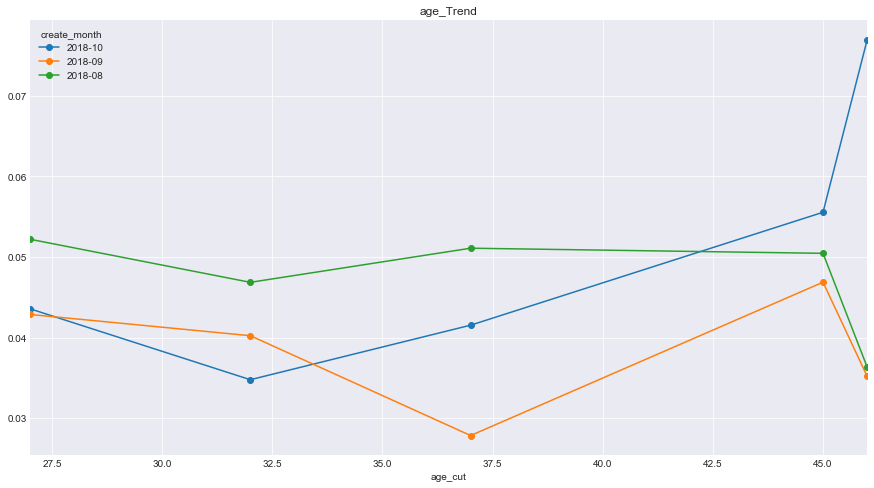

In [1106]:
age_cut_trend['mean']['y_tag'][['2018-10','2018-09','2018-08']].plot(title='age_Trend',style='-o',figsize=(15, 8))

## 绑卡银行

### 总揽

In [1108]:
# 判断银行是否有比较高的逾期聚集效应
data_set.groupby(['bank_code']).y_tag.agg([np.size,np.sum,np.mean]).sort_values(by='mean',ascending=False)

,size,sum,mean
bank_code,,,
ICBC,9836.0,547.0,0.055629
BOS,19.0,1.0,0.052632
GDB,197.0,9.0,0.045685
PAB,1052.0,45.0,0.042776
BOC,3344.0,130.0,0.038887
CCB,12122.0,467.0,0.038531
CMBC,511.0,19.0,0.037182
ABC,7881.0,291.0,0.036929
BOCOM,882.0,32.0,0.036322


### 手动分组

In [1109]:
# 特征构建 : 绑定的银行卡是否是ICBC的
data_set['bank_tag']=(data_set['bank_code']=='ICBC')

# 绑ICBC银行卡的人逾期率是不是就高一些呢
data_set.groupby(['bank_tag']).y_tag.agg([np.size,np.sum,np.mean])

,size,sum,mean
bank_tag,,,
False,28634.0,1052.0,0.036749
True,9836.0,547.0,0.055629


### ICBC逾期趋势

In [1214]:
# True : ICBC
icbc_trend=data_set.pivot_table(values=['y_tag'],index='create_month',columns='bank_tag',aggfunc=[np.size,np.sum,np.mean])
icbc_trend

size            sum            mean          
               y_tag          y_tag           y_tag          
bank_tag       False   True   False True      False     True 
create_month                                                 
2018-01       2229.0   621.0    0.0   0.0  0.000000  0.000000
2018-02       1842.0   678.0    0.0   0.0  0.000000  0.000000
2018-03       2827.0  1106.0    0.0   0.0  0.000000  0.000000
2018-04       2802.0   911.0  217.0  83.0  0.077500  0.091109
2018-05       2145.0   750.0  121.0  58.0  0.056463  0.077437
2018-06       2782.0   937.0  178.0  85.0  0.064006  0.090812
2018-07       3181.0  1045.0  156.0  70.0  0.049041  0.066986
2018-08       3214.0  1084.0  130.0  81.0  0.040448  0.074723
2018-09       3799.0  1340.0  125.0  77.0  0.032903  0.057463
2018-10       3813.0  1364.0  125.0  93.0  0.032783  0.068182

In [1200]:
# icbc_trend[icbc_trend.index==True]
icbc_size_mean=pd.concat([icbc_trend[icbc_trend.index==True]['size']['y_tag'],icbc_trend[icbc_trend.index==True]['mean']['y_tag']])

icbc_size_mean=icbc_size_mean.T

# 列重命名
icbc_size_mean.columns=['icbc_size','icbc_mean']

# 逾期率转化为百分制
# icbc_size_mean['icbc_mean']=icbc_size_mean['icbc_mean'].apply(lambda x: format(x, '.1%'))
icbc_size_mean

,icbc_size,icbc_mean
create_month,,
2018-01,621.0,0.000000
2018-02,678.0,0.000000
2018-03,1106.0,0.000000
2018-04,911.0,0.091109
2018-05,750.0,0.077437
2018-06,937.0,0.090812
2018-07,1045.0,0.066986
2018-08,1084.0,0.074723
2018-09,1340.0,0.057463


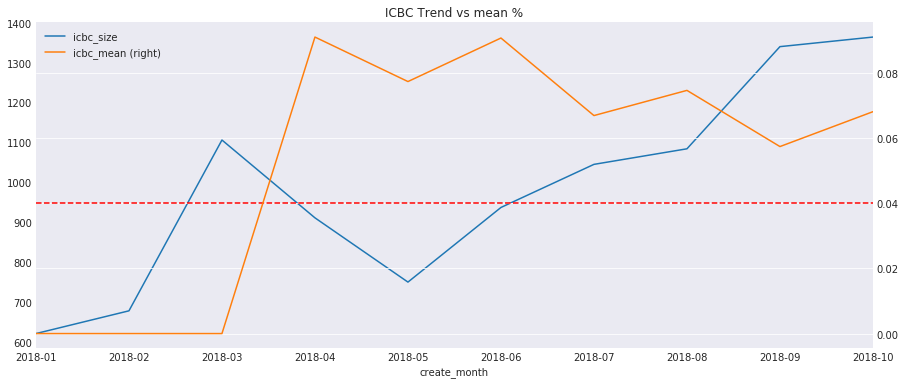

In [1202]:
icbc_size_mean.plot(title='ICBC Trend vs mean %',figsize=(15,6),secondary_y=['icbc_mean'])

# 水平画一条平均逾期率
plt.hlines(0.04, 0, 10, colors = "r", linestyles = "dashed")

### 结论

* ICBC银行存在较大的问题, 从绑卡鉴权角度去分析

## 性别

* 1 : 男性
* 0 : 女性

### 总揽

In [1309]:
# sex_trend=data_set.pivot_table(values=['y_tag'],index='create_month',columns='sex',aggfunc=[np.size,np.sum,np.mean])
# sex_trend

data_set.pivot_table(values=['y_tag'],index=['create_month'],columns=['age_cut','sex'],aggfunc=[np.size,np.sum,np.mean])




size                                                           \
              y_tag                                                            
age_cut        27.0           32.0           37.0          45.0         46.0   
sex             0.0     1.0    0.0     1.0    0.0    1.0    0.0    1.0   0.0   
create_month                                                                   
2018-01        77.0   601.0  130.0  1023.0   48.0  502.0   29.0  201.0   6.0   
2018-02        49.0   539.0  112.0   965.0   50.0  443.0   18.0  229.0   8.0   
2018-03       105.0   836.0  151.0  1548.0   59.0  700.0   56.0  351.0  22.0   
2018-04        96.0   850.0  172.0  1466.0   66.0  667.0   33.0  281.0  12.0   
2018-05        87.0   798.0  104.0  1113.0   60.0  473.0   32.0  178.0   7.0   
2018-06        88.0   882.0  156.0  1359.0   85.0  677.0   38.0  329.0  10.0   
2018-07       113.0   963.0  203.0  1627.0   91.0  734.0   50.0  350.0  13.0   
2018-08       115.0   996.0  164.0  1650.0   88.0  734.0   61.0  375.0  21.0   
2018-09       200.0  1223.0  283.0  1805.0  123.0  847.0   79.0  433.0  38.0   
2018-10       203.0  1243.0  323.0  1748.0  175.0  788.0  103.0  383.0  69.0   

                      sum                                                  \
                    y_tag                                                   
age_cut              27.0        32.0         37.0        45.0       46.0   
sex             1.0   0.0   1.0   0.0    1.0   0.0   1.0   0.0   1.0  0.0   
create_month                                                                
2018-01        43.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0   0.0  0.0   
2018-02        41.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0   0.0  0.0   
2018-03        80.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0   0.0  0.0   
2018-04        70.0   3.0  67.0   7.0  113.0   5.0  73.0   3.0  27.0  0.0   
2018-05        43.0   4.0  64.0   9.0   58.0   1.0  28.0   1.0  13.0  1.0   
2018-06        77.0   9.0  74.0  16.0   84.0   6.0  43.0   2.0  18.0  1.0   
2018-07        58.0   5.0  67.0  15.0   93.0   5.0  22.0   1.0  12.0  1.0   
2018-08        89.0   6.0  52.0   5.0   80.0   5.0  37.0   0.0  22.0  0.0   
2018-09       104.0   7.0  54.0   6.0   78.0   8.0  19.0   4.0  20.0  2.0   
2018-10       139.0  13.0  50.0  16.0   56.0  12.0  28.0  10.0  17.0  6.0   

                        mean                                          \
                       y_tag                                           
age_cut                 27.0                32.0                37.0   
sex            1.0       0.0       1.0       0.0       1.0       0.0   
create_month                                                           
2018-01        0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
2018-02        0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
2018-03        0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
2018-04        2.0  0.031250  0.078824  0.040698  0.077080  0.075758   
2018-05        0.0  0.045977  0.080201  0.086538  0.052252  0.016667   
2018-06       10.0  0.103448  0.083995  0.102564  0.061810  0.070588   
2018-07        4.0  0.044248  0.069574  0.073892  0.057160  0.054945   
2018-08        4.0  0.052174  0.052209  0.030488  0.048485  0.056818   
2018-09        3.0  0.035000  0.044154  0.021201  0.043213  0.065041   
2018-10       10.0  0.064039  0.040225  0.049536  0.032037  0.068571   

                                                                
                                                                
age_cut                     45.0                46.0            
sex                1.0       0.0       1.0       0.0       1.0  
create_month                                                    
2018-01       0.000000  0.000000  0.000000  0.000000  0.000000  
2018-02       0.000000  0.000000  0.000000  0.000000  0.000000  
2018-03       0.000000  0.000000  0.000000  0.000000  0.000000  
2018-04       0.109774  0.090909  0.096085  0.000000  0.0

### 逾期率趋势

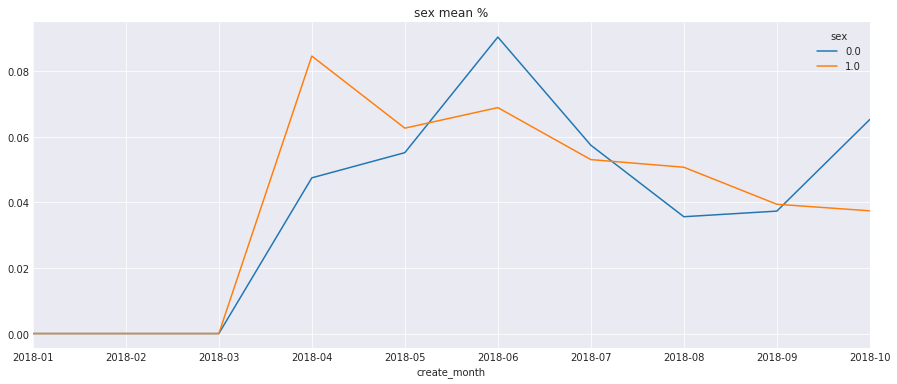

In [1212]:
# 不同设备用信人数, 逾期人数和逾期率
sex_trend=data_set.pivot_table(values=['y_tag'],index='create_month',columns='sex',aggfunc=[np.mean])
sex_trend['mean']['y_tag'].plot(title='sex mean %',figsize=(15,6))

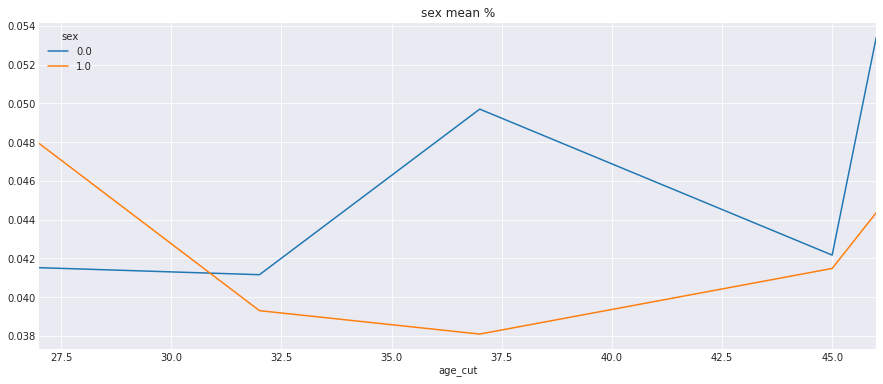

### 结论

* 近三个月, 女性群体不管是从用信人数, 逾期人数, 还是逾期率都呈现上升趋势

## 机型

### 总揽

In [1215]:
mobile_brand_trend=data_set.pivot_table(values=['y_tag'],index='mobile_brand',columns=['create_month'],aggfunc=[np.size,np.sum,np.mean])
mobile_brand_trend.head()

size                                                          \
               y_tag                                                           
create_month 2018-01 2018-02 2018-03 2018-04 2018-05 2018-06 2018-07 2018-08   
mobile_brand                                                                   
360              NaN     NaN     NaN     1.0     1.0     NaN     NaN     NaN   
4G               NaN     NaN     NaN     1.0     NaN     NaN     NaN     NaN   
AGM              NaN     NaN     1.0     NaN     NaN     NaN     NaN     NaN   
AR9              NaN     NaN     NaN     NaN     NaN     NaN     NaN     1.0   
Android          NaN     1.0     NaN     NaN     NaN     NaN     NaN     NaN   

                                 sum                                          \
                               y_tag                                           
create_month 2018-09 2018-10 2018-01 2018-02 2018-03 2018-04 2018-05 2018-06   
mobile_brand                                                                   
360              1.0     NaN     NaN     NaN     NaN     0.0     0.0     NaN   
4G               NaN     NaN     NaN     NaN     NaN     0.0     NaN     NaN   
AGM              NaN     1.0     NaN     NaN     0.0     NaN     NaN     NaN   
AR9              NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
Android          NaN     NaN     NaN     0.0     NaN     NaN     NaN     NaN   

                                                mean                          \
                                               y_tag                           
create_month 2018-07 2018-08 2018-09 2018-10 2018-01 2018-02 2018-03 2018-04   
mobile_brand                                                                   
360              NaN     NaN     0.0     NaN     NaN     NaN     NaN     0.0   
4G               NaN     NaN     NaN     NaN     NaN     NaN     NaN     0.0   
AGM              NaN     NaN     NaN     0.0     NaN     NaN     0.0     NaN   
AR9              NaN     0.0     NaN     NaN     NaN     NaN     NaN     NaN   
Android          NaN     NaN     NaN     NaN     NaN     0.0     NaN     NaN   

                                                              
                                                              
create_month 2018-05 2018-06 2018-07 2018-08 2018-09 2018-10  
mobile_brand                                                  
360              0.0     NaN     NaN     NaN     0.0     NaN  
4G               NaN     NaN     NaN     NaN     NaN     NaN  
AGM              NaN     NaN     NaN     NaN     NaN     0.0  
AR9              NaN     NaN     NaN     0.0     NaN     NaN  
Android          NaN     NaN     NaN     NaN     NaN     NaN

### 用信人数趋势

In [1216]:
mobile_trend_size=mobile_brand_trend['size']['y_tag'].sort_values(by=['2018-10'],ascending=False,inplace=False)
mobile_trend_size[0:9]

create_month,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10
mobile_brand,,,,,,,,,,
apple,1274.0,1251.0,2078.0,2323.0,1994.0,2114.0,2267.0,2292.0,2731.0,2474.0
HUAWEI,482.0,377.0,642.0,469.0,251.0,518.0,569.0,559.0,619.0,699.0
vivo,341.0,291.0,406.0,303.0,251.0,370.0,444.0,553.0,663.0,719.0
OPPO,291.0,257.0,330.0,217.0,169.0,348.0,477.0,484.0,627.0,774.0
Xiaomi,207.0,149.0,211.0,161.0,96.0,151.0,206.0,183.0,223.0,234.0
samsung,126.0,98.0,130.0,113.0,73.0,108.0,153.0,132.0,146.0,137.0
smartisan,7.0,11.0,16.0,15.0,13.0,21.0,13.0,21.0,23.0,23.0
Meizu,42.0,38.0,31.0,39.0,11.0,26.0,35.0,19.0,20.0,24.0
OnePlus,6.0,7.0,12.0,7.0,7.0,16.0,19.0,12.0,22.0,14.0


### 逾期人数趋势

In [1217]:
mobile_trend_sum=mobile_brand_trend['sum']['y_tag'].sort_values(by=['2018-10'],ascending=False,inplace=False)
mobile_trend_sum[0:9]

create_month,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10
mobile_brand,,,,,,,,,,
apple,0.0,0.0,0.0,181.0,139.0,153.0,111.0,97.0,97.0,74.0
vivo,0.0,0.0,0.0,36.0,12.0,39.0,30.0,42.0,28.0,46.0
OPPO,0.0,0.0,0.0,21.0,10.0,26.0,31.0,30.0,32.0,45.0
HUAWEI,0.0,0.0,0.0,30.0,8.0,30.0,36.0,28.0,17.0,31.0
samsung,0.0,0.0,0.0,12.0,3.0,5.0,9.0,6.0,14.0,6.0
Xiaomi,0.0,0.0,0.0,9.0,2.0,5.0,6.0,3.0,8.0,6.0
Meizu,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,4.0
GIONEE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
smartisan,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0


### 逾期率趋势

In [1218]:
mobile_trend_mean=mobile_brand_trend['mean']['y_tag'].sort_values(by=['2018-10'],ascending=False,inplace=False)
mobile_trend_mean[0:9]

create_month,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10
mobile_brand,,,,,,,,,,
SHARP,NaN,NaN,0.0,NaN,0.000000,0.000000,0.000000,NaN,0.000000,1.000000
YUFLY,0.0,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000,1.000000
LeMobile,0.0,0.0,0.0,0.000000,0.142857,0.125000,0.000000,0.166667,0.333333,0.200000
Meizu,0.0,0.0,0.0,0.076923,0.090909,0.000000,0.028571,0.000000,0.000000,0.166667
vivo,0.0,0.0,0.0,0.118812,0.047809,0.105405,0.067568,0.075949,0.042232,0.063978
GIONEE,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.062500
OPPO,0.0,0.0,0.0,0.096774,0.059172,0.074713,0.064990,0.061983,0.051037,0.058140
HUAWEI,0.0,0.0,0.0,0.063966,0.031873,0.057915,0.063269,0.050089,0.027464,0.044349
samsung,0.0,0.0,0.0,0.106195,0.041096,0.046296,0.058824,0.045455,0.095890,0.043796


### 是否存在异常机型

In [1241]:
# 按照申请多少判断异常点
Un_mobile_1=mobile_brand_trend['size']['y_tag'].sort_values(by=['2018-10'],ascending=False,inplace=False)[0:15]
Un_mobile_2=mobile_brand_trend['sum']['y_tag'].sort_values(by=['2018-10'],ascending=False,inplace=False)[0:15]
Un_mobile_3=mobile_brand_trend['mean']['y_tag'].sort_values(by=['2018-10'],ascending=False,inplace=False)[0:15]

# 转成list形式
Un_mobile_1=Un_mobile_1.index.tolist()
Un_mobile_2=Un_mobile_2.index.tolist()
Un_mobile_3=Un_mobile_3.index.tolist()


UnNormal_mobile=[]
for i in Un_mobile_2:
    if i in Un_mobile_1:
        if i in Un_mobile_3:
            UnNormal_mobile.append(i)
            

# 取出交集:满足或用信人数多、或逾期人数多、或逾期率高
print len(UnNormal_mobile),UnNormal_mobile

10 ['apple', 'vivo', 'OPPO', 'HUAWEI', 'samsung', 'Xiaomi', 'Meizu', 'GIONEE', 'smartisan', 'LeMobile']


### 异常机型逾期率

In [1242]:
# 异常点的申请量
mobile_brand_trend[['size','sum','mean']].loc[UnNormal_mobile]

size                                                          \
               y_tag                                                           
create_month 2018-01 2018-02 2018-03 2018-04 2018-05 2018-06 2018-07 2018-08   
mobile_brand                                                                   
apple         1274.0  1251.0  2078.0  2323.0  1994.0  2114.0  2267.0  2292.0   
vivo           341.0   291.0   406.0   303.0   251.0   370.0   444.0   553.0   
OPPO           291.0   257.0   330.0   217.0   169.0   348.0   477.0   484.0   
HUAWEI         482.0   377.0   642.0   469.0   251.0   518.0   569.0   559.0   
samsung        126.0    98.0   130.0   113.0    73.0   108.0   153.0   132.0   
Xiaomi         207.0   149.0   211.0   161.0    96.0   151.0   206.0   183.0   
Meizu           42.0    38.0    31.0    39.0    11.0    26.0    35.0    19.0   
GIONEE           9.0    12.0    10.0     6.0     2.0     8.0     9.0     7.0   
smartisan        7.0    11.0    16.0    15.0    13.0    21.0    13.0    21.0   
LeMobile        14.0     9.0    17.0     8.0     7.0     8.0     4.0     6.0   

                                 sum                                          \
                               y_tag                                           
create_month 2018-09 2018-10 2018-01 2018-02 2018-03 2018-04 2018-05 2018-06   
mobile_brand                                                                   
apple         2731.0  2474.0     0.0     0.0     0.0   181.0   139.0   153.0   
vivo           663.0   719.0     0.0     0.0     0.0    36.0    12.0    39.0   
OPPO           627.0   774.0     0.0     0.0     0.0    21.0    10.0    26.0   
HUAWEI         619.0   699.0     0.0     0.0     0.0    30.0     8.0    30.0   
samsung        146.0   137.0     0.0     0.0     0.0    12.0     3.0     5.0   
Xiaomi         223.0   234.0     0.0     0.0     0.0     9.0     2.0     5.0   
Meizu           20.0    24.0     0.0     0.0     0.0     3.0     1.0     0.0   
GIONEE          14.0    32.0     0.0     0.0     0.0     0.0     0.0     0.0   
smartisan       23.0    23.0     0.0     0.0     0.0     0.0     1.0     2.0   
LeMobile         3.0     5.0     0.0     0.0     0.0     0.0     1.0     1.0   

                                                mean                  \
                                               y_tag                   
create_month 2018-07 2018-08 2018-09 2018-10 2018-01 2018-02 2018-03   
mobile_brand                                                           
apple          111.0    97.0    97.0    74.0     0.0     0.0     0.0   
vivo            30.0    42.0    28.0    46.0     0.0     0.0     0.0   
OPPO            31.0    30.0    32.0    45.0     0.0     0.0     0.0   
HUAWEI          36.0    28.0    17.0    31.0     0.0     0.0     0.0   
samsung          9.0     6.0    14.0     6.0     0.0     0.0     0.0   
Xiaomi           6.0     3.0     8.0     6.0     0.0     0.0     0.0   
Meizu            1.0     0.0     0.0     4.0     0.0     0.0     0.0   
GIONEE           0.0     1.0     0.0     2.0     0.0     0.0     0.0   
smartisan        0.0     1.0     1.0     1.0     0.0     0.0     0.0   
LeMobile         0.0     1.0     1.0     1.0     0.0     0.0     0.0   

                                                                          \
                                                                           
create_month   2018-04   2018-05   2018-06   2018-07   2018-08   2018-09   
mobile_brand                                                               
apple         0.077916  0.069709  0.072375  0.048963  0.042321  0.035518   
vivo          0.118812  0.047809  0.105405  0.067568  0.075949  0.042232   
OPPO          0.096774  0.059172  0.074713  0.064990  0.061983  0.051037   
HUAWEI        0.063966  0.031873  0.057915  0.063269  0.050089  0.027464   
samsung       0.106195  0.041096  0.046296  0.058824  0.045455  0.095890   
Xiaomi        0.055901  0.020833  0.033113  0.029126  0.016393  0.035874   
Meizu

### 热力图

[Text(0.5,0,u'2018-01'),
 Text(1.5,0,u'2018-02'),
 Text(2.5,0,u'2018-03'),
 Text(3.5,0,u'2018-04'),
 Text(4.5,0,u'2018-05'),
 Text(5.5,0,u'2018-06'),
 Text(6.5,0,u'2018-07'),
 Text(7.5,0,u'2018-08'),
 Text(8.5,0,u'2018-09'),
 Text(9.5,0,u'2018-10')]

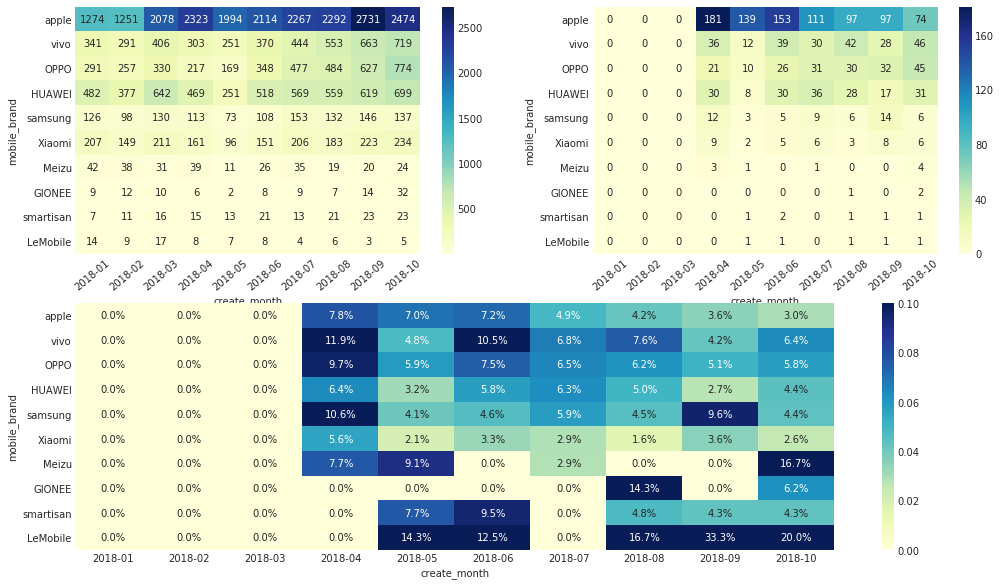

In [1243]:
# 布局
fig = plt.figure(figsize=(17, 10))
axes1=fig.add_subplot(221)
axes2=fig.add_subplot(222)
axes3=fig.add_subplot(212)

# 逾期人数热力图
sns.heatmap(mobile_trend_size.loc[UnNormal_mobile],annot=True,cmap="YlGnBu",fmt="0.0f",ax=axes1)
sns.heatmap(mobile_trend_sum.loc[UnNormal_mobile],annot=True,cmap="YlGnBu",fmt="0.0f",ax=axes2)
sns.heatmap(mobile_trend_mean.loc[UnNormal_mobile],annot=True,cmap="YlGnBu",vmin=0, vmax=0.1,fmt="0.1%",ax=axes3)

# 坐标轴方向
axes1.set_xticklabels(axes1.get_xticklabels(), rotation=40)
axes2.set_xticklabels(axes2.get_xticklabels(), rotation=40)
# axes3.set_xticklabels(axes3.get_xticklabels(), rotation=45)

### 结论

* vivo和oppo机型的逾期率普遍高于均值 : 考虑对机型进行多维度细分, 找出逾期率最高的特征组合

* xiaomi和apple用户的逾期率相对较低

* LeMobile机型用信人数少, 逾期率高, 建议直接拉黑该机型用户

## 活跃天数

### 总揽

In [1265]:
# 首先看下指标的覆盖率
data_set['dist_dt_30_day'].isnull().sum()

28649

### 手动分组

In [1704]:
data_set.loc[data_set.dist_dt_30_day == 0, 'dist_day_cut'] = 0
data_set.loc[(data_set.dist_dt_30_day >=1)&(data_set.dist_dt_30_day <7), 'dist_day_cut'] = 7
data_set.loc[(data_set.dist_dt_30_day >=7)&(data_set.dist_dt_30_day <=14), 'dist_day_cut'] = 14
data_set.loc[(data_set.dist_dt_30_day >=14)&(data_set.dist_dt_30_day <40), 'dist_day_cut'] = 30

In [1267]:
# 看下趋势
dist_day_cut_trend=data_set.pivot_table(values=['y_tag'],index='create_month',columns=['dist_day_cut'],aggfunc=[np.size,np.sum,np.mean])
dist_day_cut_trend

size                  sum                       mean            \
             y_tag                y_tag                      y_tag             
dist_day_cut  0.0  7.0  14.0 30.0  0.0  7.0  14.0 30.0        0.0       7.0    
create_month                                                                   
2018-01       -999  443  154   99  -999    0    0    0 -999.000000  0.000000   
2018-02         21  207  157  192     0    0    0    0    0.000000  0.000000   
2018-03         93  367  252  289     0    0    0    0    0.000000  0.000000   
2018-04         90  309  243  322    11   26   14   15    0.122222  0.084142   
2018-05        105  259  150  179     2   21    7   11    0.019048  0.081081   
2018-06        200  357  252  237     9   27   25   12    0.045000  0.075630   
2018-07        262  369  256  217     8   15   10   10    0.030534  0.040650   
2018-08        290  411  261  199    15   18   17   10    0.051724  0.043796   
2018-09        340  476  248  289    12   18   12   11    0.035294  0.037815   
2018-10        327  395  251  253    12   12    5    3    0.036697  0.030380   

                                  
                                  
dist_day_cut      14.0      30.0  
create_month                      
2018-01       0.000000  0.000000  
2018-02       0.000000  0.000000  
2018-03       0.000000  0.000000  
2018-04       0.057613  0.046584  
2018-05       0.046667  0.061453  
2018-06       0.099602  0.050633  
2018-07       0.039062  0.046083  
2018-08       0.065134  0.050251  
2018-09       0.048387  0.038062  
2018-10       0.019920  0.011858

### 结论

* 该特征覆盖度低, 不做优先考虑

## diff_price

### 转化为万

In [1706]:
# 先对特征进行转化
data_set['diff_price']=data_set['diff_price'].fillna(-1)
diff_price_int=[]
for i in data_set['diff_price']:
    diff_price_int.append(int(i/10000))

data_set['diff_price_int']=diff_price_int

In [1707]:
data_set.groupby(['diff_price_int']).y_tag.agg([np.size,np.sum,np.mean]).head()

,size,sum,mean
diff_price_int,,,
0,5246.0,330.0,0.062905
1,3435.0,145.0,0.042213
2,15843.0,589.0,0.037177
3,7921.0,304.0,0.038379
4,896.0,32.0,0.035714


In [1280]:
# # diff_price
# diff_price_bins=[-1,0,1,6,8,70]
# price_group_name=range(1,len(diff_price_bins))
# cats=pd.cut(list(data_set['diff_price_int']),diff_price_bins,right=False,labels=price_group_name)
# data_set['diff_price_cut']=list(cats)

### 总揽

In [1303]:
diff_price_trend=data_set.pivot_table(values=['y_tag'],index='diff_price_int',columns=['create_month'],aggfunc=[np.size,np.sum,np.mean])
diff_price_trend.head()

size                                                  \
                 y_tag                                                   
create_month   2018-01 2018-02 2018-03 2018-04 2018-05 2018-06 2018-07   
diff_price_int                                                           
0                371.0   314.0   443.0   400.0   341.0   460.0   509.0   
1                318.0   253.0   372.0   397.0   262.0   347.0   424.0   
2               1341.0  1191.0  1856.0  1780.0  1360.0  1734.0  1992.0   
3                653.0   602.0   965.0   888.0   703.0   887.0  1037.0   
4                 65.0    65.0   114.0    93.0    89.0   115.0   102.0   

                                           sum                          \
                                         y_tag                           
create_month   2018-08 2018-09 2018-10 2018-01 2018-02 2018-03 2018-04   
diff_price_int                                                           
0                561.0   872.0  1419.0     0.0     0.0     0.0    29.0   
1                427.0   525.0   459.0     0.0     0.0     0.0    25.0   
2               2016.0  2288.0  2058.0     0.0     0.0     0.0   137.0   
3               1002.0  1114.0   938.0     0.0     0.0     0.0    88.0   
4                106.0   120.0   113.0     0.0     0.0     0.0     9.0   

                                                                  mean  \
                                                                 y_tag   
create_month   2018-05 2018-06 2018-07 2018-08 2018-09 2018-10 2018-01   
diff_price_int                                                           
0                 26.0    45.0    41.0    34.0    50.0   122.0     0.0   
1                 13.0    26.0    24.0    32.0    22.0    12.0     0.0   
2                 87.0   114.0    91.0    92.0    79.0    51.0     0.0   
3                 42.0    64.0    49.0    41.0    36.0    25.0     0.0   
4                  6.0     5.0     8.0     3.0     3.0     2.0     0.0   

                                                                        \
                                                                         
create_month   2018-02 2018-03   2018-04   2018-05   2018-06   2018-07   
diff_price_int                                                           
0                  0.0     0.0  0.072682  0.076246  0.097826  0.080550   
1                  0.0     0.0  0.062972  0.049618  0.074928  0.056604   
2                  0.0     0.0  0.077010  0.064065  0.065782  0.045683   
3                  0.0     0.0  0.099099  0.059744  0.072235  0.047252   
4                  0.0     0.0  0.096774  0.068182  0.043478  0.078431   

                                              
                                              
create_month     2018-08   2018-09   2018-10  
diff_price_int                                
0               0.060606  0.057339  0.085976  
1               0.074941  0.041905  0.026144  
2               0.045635  0.034528  0.024781  
3               0.040918  0.032316  0.026652  
4               0.028302  0.025000  0.017699

### 手动分组

In [1708]:
# 手动切分
data_set.loc[data_set.diff_price_int<27, 'diff_price_cut'] = 27
data_set.loc[(data_set.diff_price_int >= 27)&(data_set.age<32), 'age_cut'] = 32
data_set.loc[(data_set.diff_price_int >= 32)&(data_set.age<37), 'age_cut'] = 37
data_set.loc[(data_set.diff_price_int >= 37)&(data_set.age<45), 'age_cut'] = 45
data_set.loc[data_set.age >= 45, 'age_cut'] = 46

### 结论

## 地区判断

### 一致性判断

In [1290]:
cols=['diff_gps_real_prov','diff_gps_reg_city','diff_gps_real_city','diff_reg_real_city']

### 总揽

In [1296]:
for col in cols:
    print col,'\n'
    print data_set.pivot_table(values=['y_tag'],index='create_month',columns=col,aggfunc=[np.size,np.sum,np.mean])
    print '--------------------------------------------------------------------'


diff_gps_real_prov 

                      size            sum             mean          
                     y_tag          y_tag            y_tag          
diff_gps_real_prov   False   True   False  True      False     True 
create_month                                                        
2018-01              871.0  1979.0    0.0    0.0  0.000000  0.000000
2018-02              572.0  1948.0    0.0    0.0  0.000000  0.000000
2018-03             1110.0  2823.0    0.0    0.0  0.000000  0.000000
2018-04             1022.0  2691.0  105.0  195.0  0.102941  0.072464
2018-05              790.0  2105.0   46.0  133.0  0.058450  0.063183
2018-06             1068.0  2651.0   68.0  195.0  0.063790  0.073557
2018-07             1177.0  3049.0   65.0  161.0  0.055225  0.052804
2018-08             1178.0  3120.0   62.0  149.0  0.052632  0.047756
2018-09             1431.0  3708.0   61.0  141.0  0.042628  0.038026
2018-10             1397.0  3780.0   64.0  154.0  0.045812  0.040741
-------------

### 城市等级

In [1300]:
cols=[col for col in data_set.columns if col.endswith('idx')]

# tel_city_idx : 覆盖度太低

cols=['gps_city_idx','rn_city_idx']

In [1301]:
for col in cols:
    print col,'\n'
    print data_set.pivot_table(values=['y_tag'],index=col,columns='create_month',aggfunc=[np.size,np.sum,np.mean])
    print '--------------------------------------------------------------------'



gps_city_idx 

                size                                                          \
               y_tag                                                           
create_month 2018-01 2018-02 2018-03 2018-04 2018-05 2018-06 2018-07 2018-08   
gps_city_idx                                                                   
1.0            259.0   199.0   436.0   401.0   369.0   436.0   560.0   498.0   
1.5            495.0   439.0   807.0   770.0   590.0   829.0   818.0   827.0   
2.0            601.0   478.0   845.0   858.0   673.0   847.0   957.0   988.0   
3.0            634.0   567.0   854.0   792.0   570.0   705.0   887.0   849.0   
4.0            495.0   506.0   564.0   523.0   421.0   529.0   584.0   669.0   
5.0            349.0   308.0   389.0   338.0   257.0   330.0   394.0   375.0   

                                 sum                                          \
                               y_tag                                           
create_month 2018-09 201

### 结论

* 城市等级能区分坏用户, 且城市等级和逾期率呈反比例关系, 普遍4,5线城市的逾期率会高些

## s004

In [1709]:
data_set['s004']=data_set['s004'].fillna(-1)
s004_round=[]
for i in data_set['s004']:
    s004_round.append(round(i,1))

data_set['s004_round']=s004_round
s004_trend=data_set.groupby(['s004_round']).y_tag.agg([np.size,np.sum,np.mean])
s004_trend['mean']=s004_trend['mean'].apply(lambda x: format(x, '.1%'))
s004_trend

,size,sum,mean
s004_round,,,
-1.0,19666.0,748.0,3.8%
0.0,9552.0,351.0,3.7%
0.1,3917.0,236.0,6.0%
0.2,1000.0,64.0,6.4%
0.3,433.0,44.0,10.2%
0.4,171.0,15.0,8.8%
0.5,47.0,5.0,10.6%
0.6,14.0,1.0,7.1%
0.7,2.0,0.0,0.0%


### 总揽

In [1314]:
# 看下趋势
s004_trend=data_set.pivot_table(values=['y_tag'],index='create_month',columns=['s004_round'],aggfunc=[np.size,np.sum,np.mean])
s004_trend

size                                                         \
               y_tag                                                          
s004_round      -1.0     0.0    0.1    0.2   0.3   0.4   0.5  0.6  0.7  0.8   
create_month                                                                  
2018-01       1590.0   845.0  299.0   67.0  34.0   6.0   7.0  2.0  NaN  NaN   
2018-02       1456.0   739.0  234.0   59.0  26.0   3.0   2.0  1.0  NaN  NaN   
2018-03       2286.0  1199.0  325.0   77.0  27.0  10.0   7.0  2.0  NaN  NaN   
2018-04       2278.0  1046.0  295.0   58.0  26.0   7.0   3.0  NaN  NaN  NaN   
2018-05       1866.0   733.0  231.0   38.0  16.0   9.0   2.0  NaN  NaN  NaN   
2018-06       2172.0  1053.0  367.0   75.0  34.0  13.0   2.0  2.0  1.0  NaN   
2018-07       2353.0  1204.0  459.0  143.0  52.0   7.0   5.0  2.0  NaN  1.0   
2018-08       2377.0  1128.0  536.0  162.0  59.0  31.0   3.0  2.0  NaN  NaN   
2018-09       2762.0  1294.0  744.0  184.0  99.0  40.0  13.0  2.0  NaN  1.0   
2018-10       2615.0  1437.0  755.0  209.0  97.0  56.0   6.0  1.0  1.0  NaN   

                sum                                                   \
              y_tag                                                    
s004_round     -1.0   0.0   0.1   0.2   0.3  0.4  0.5  0.6  0.7  0.8   
create_month                                                           
2018-01         0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0  NaN  NaN   
2018-02         0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0  NaN  NaN   
2018-03         0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0  NaN  NaN   
2018-04       176.0  78.0  30.0   4.0  10.0  2.0  0.0  NaN  NaN  NaN   
2018-05       119.0  37.0  18.0   4.0   1.0  0.0  0.0  NaN  NaN  NaN   
2018-06       134.0  81.0  29.0   8.0   7.0  2.0  1.0  1.0  0.0  NaN   
2018-07       117.0  58.0  32.0  12.0   5.0  1.0  1.0  0.0  NaN  0.0   
2018-08        98.0  50.0  35.0  21.0   5.0  1.0  1.0  0.0  NaN  NaN   
2018-09        83.0  44.0  53.0   6.0  13.0  2.0  1.0  0.0  NaN  0.0   
2018-10        92.0  49.0  50.0  11.0   7.0  8.0  1.0  0.0  0.0  NaN   

                  mean                                                    \
                 y_tag                                                     
s004_round        -1.0       0.0       0.1       0.2       0.3       0.4   
create_month                                                               
2018-01       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2018-02       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2018-03       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2018-04       0.077329  0.074570  0.101695  0.068966  0.384615  0.285714   
2018-05       0.063875  0.050477  0.077922  0.105263  0.062500  0.000000   
2018-06       0.061694  0.077069  0.079019  0.106667  0.205882  0.153846   
2018-07       0.049724  0.048173  0.069717  0.083916  0.096154  0.142857   
2018-08       0.041228  0.044326  0.065299  0.129630  0.084746  0.032258   
2018-09       0.030051  0.034003  0.071237  0.032609  0.131313  0.050000   
2018-10       0.035182  0.034099  0.066225  0.052632  0.072165  0.142857   

                                       
                                       
s004_round         0.5  0.6  0.7  0.8  
create_month                           
2018-01       0.000000  0.0  NaN  NaN  
2018-02       0.000000  0.0  NaN  NaN  
2018-03       0.000000  0.0  NaN  NaN  
2018-04       0.000000  NaN  NaN  NaN  
2018-05       0.000000  NaN  NaN  NaN  
2018-06       0.500000  0.5  0.0  NaN  
2018-07       0.200000  0.0  NaN  0.0  
2018-08       0.333333  0.0  NaN  NaN  
2018-09       0.076923  0.0  NaN  0.0  
2018-10       0.166667  0.0  0.0  NaN

### 手动切分

In [1318]:
# 看下趋势
s004_trend=data_set.pivot_table(values=['y_tag'],index='create_month',columns=['s004_01'],aggfunc=[np.size,np.sum,np.mean])
s004_trend

size           sum            mean          
               y_tag         y_tag           y_tag          
s004_01        False  True   False True      False     True 
create_month                                                
2018-01       2661.0  189.0    0.0   0.0  0.000000  0.000000
2018-02       2370.0  150.0    0.0   0.0  0.000000  0.000000
2018-03       3712.0  221.0    0.0   0.0  0.000000  0.000000
2018-04       3533.0  180.0  274.0  26.0  0.077598  0.144444
2018-05       2759.0  136.0  166.0  13.0  0.060232  0.095588
2018-06       3486.0  233.0  234.0  29.0  0.067164  0.124464
2018-07       3882.0  344.0  197.0  29.0  0.050747  0.084302
2018-08       3890.0  408.0  176.0  35.0  0.045244  0.085784
2018-09       4554.0  585.0  151.0  51.0  0.033158  0.087179
2018-10       4587.0  590.0  179.0  39.0  0.039023  0.066102

### 结论

* s004大于0.1的用户群体风险极高

In [1322]:
s004_01_trend=data_set.groupby(['s004_01']).y_tag.agg([np.size,np.sum,np.mean])
s004_01_trend['mean']=s004_01_trend['mean'].apply(lambda x: format(x, '.1%'))
s004_01_trend

,size,sum,mean
s004_01,,,
False,35434.0,1377.0,3.9%
True,3036.0,222.0,7.3%


## 之家信用分

In [1710]:
data_set['score_1']=data_set['score_1'].fillna(-1)
score_1_round=[]
for i in data_set['score_2']:
    score_1_round.append(round(i/50,0)*50)

data_set['score_1_round']=score_1_round
score_1_trend=data_set.groupby(['score_1_round']).y_tag.agg([np.size,np.sum,np.mean])
score_1_trend['mean']=score_1_trend['mean'].apply(lambda x: format(x, '.1%'))
score_1_trend

,size,sum,mean
score_1_round,,,
300.0,178.0,19.0,10.7%
350.0,48.0,3.0,6.2%
400.0,39.0,4.0,10.3%
450.0,1162.0,123.0,10.6%
500.0,1512.0,85.0,5.6%
550.0,2247.0,96.0,4.3%
600.0,6515.0,289.0,4.4%
650.0,8566.0,352.0,4.1%
700.0,6534.0,246.0,3.8%


In [1335]:
data_set.groupby(['score_2']).y_tag.agg([np.size,np.sum,np.mean])

,size,sum,mean
score_2,,,
281.0,1.0,0.0,0.000000
306.0,3.0,0.0,0.000000
309.0,2.0,0.0,0.000000
312.0,6.0,1.0,0.166667
315.0,171.0,19.0,0.111111
317.0,2.0,0.0,0.000000
329.0,6.0,0.0,0.000000
331.0,15.0,2.0,0.133333
338.0,5.0,0.0,0.000000


### 总揽

In [1336]:
# 看下趋势
score_2_trend=data_set.pivot_table(values=['y_tag'],index='create_month',columns=['score_2_500'],aggfunc=[np.size,np.sum,np.mean])
score_2_trend

size           sum            mean          
               y_tag         y_tag           y_tag          
score_2_500    False  True   False True      False     True 
create_month                                                
2018-01       2803.0   47.0    0.0   0.0  0.000000  0.000000
2018-02       2491.0   29.0    0.0   0.0  0.000000  0.000000
2018-03       3912.0   21.0    0.0   0.0  0.000000  0.000000
2018-04       3687.0   26.0  297.0   3.0  0.080597  0.115385
2018-05       2870.0   25.0  176.0   3.0  0.061388  0.120000
2018-06       3605.0  114.0  249.0  14.0  0.069109  0.122807
2018-07       3984.0  242.0  204.0  22.0  0.051205  0.090909
2018-08       4105.0  193.0  198.0  13.0  0.048234  0.067358
2018-09       4716.0  423.0  168.0  34.0  0.035623  0.080378
2018-10       4296.0  881.0  124.0  94.0  0.028864  0.106697

### 验证重合度

In [1346]:
# 看下趋势
data_set.pivot_table(values=['y_tag'],index='s004_01',columns=['score_2_500'],aggfunc=[np.size,np.sum,np.mean])

size             sum             mean          
               y_tag           y_tag            y_tag          
score_2_500    False   True    False  True      False     True 
s004_01                                                        
False        33823.0  1611.0  1240.0  137.0  0.036672  0.085040
True          2646.0   390.0   176.0   46.0  0.066515  0.117949

### 结论

* 之家信用分小于500分风险较高, 可以直接做挡板


* s004和信用分重复度不高 : 

  * 信用分500分以下拒绝群体中 , 有19.5%在s004大于0.1的拒绝范围内
  
  * s004大于0.1拒绝的群体中, 有12.8%在信用分500分以下拒绝的范围内

In [2028]:
# 500分以下群体的风险分布
a=data_set.groupby(['s004_01']).y_tag.agg([np.size,np.sum,np.mean])
# a['mean']=a['mean'].apply(lambda x: format(x, '.1%'))
a

,size,sum,mean
s004_01,,,
False,31989.0,1254.0,0.039201
True,2815.0,210.0,0.074600


## 几点申请的

### 总揽

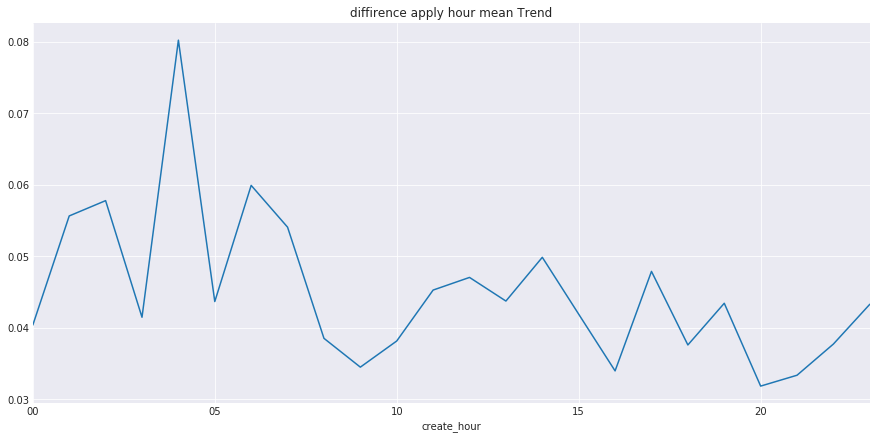

In [2008]:
apply_hour=data_set.groupby(['create_hour']).y_tag.agg(['size','sum','mean'])
# a['mean']=a['mean'].apply(lambda x: format(x, '.1%'))
apply_hour['mean'].plot(title='diffirence apply hour mean Trend',figsize=(15,7))

In [2009]:
apply_hour

,size,sum,mean
create_hour,,,
00,792,32.0,0.040404
01,521,29.0,0.055662
02,346,20.0,0.057803
03,241,10.0,0.041494
04,162,13.0,0.080247
05,206,9.0,0.043689
06,317,19.0,0.059937
07,721,39.0,0.054092
08,1375,53.0,0.038545


### 手动切分

In [2019]:
# 手动切分
data_set['create_hour']=data_set['create_hour'].astype(int)
data_set.loc[(data_set.create_hour >=0)&(data_set.create_hour <=7), 'create_hour_cut'] = 7
data_set.loc[(data_set.create_hour >=8)&(data_set.create_hour <=10), 'create_hour_cut'] = 10
data_set.loc[(data_set.create_hour >=11)&(data_set.create_hour <=17), 'create_hour_cut'] = 17
data_set.loc[(data_set.create_hour >=18)&(data_set.create_hour <=23), 'create_hour_cut'] = 23

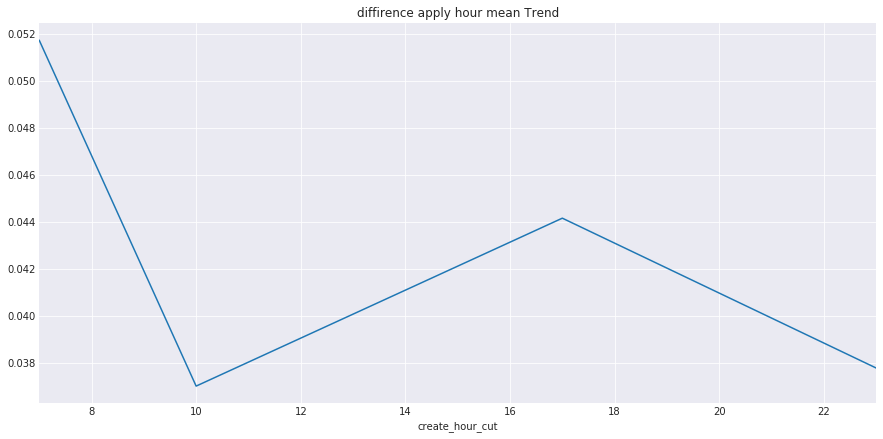

In [2021]:
apply_hour=data_set.groupby(['create_hour_cut']).y_tag.agg(['size','sum','mean'])
apply_hour
# a['mean']=a['mean'].apply(lambda x: format(x, '.1%'))
apply_hour['mean'].plot(title='diffirence apply hour mean Trend',figsize=(15,7))

# 导出数据

## 删除覆盖度低的

In [1596]:
# 筛选NULL值比较多的列
def filter_na_cols(df,p):
    na_list=[]
    for col in df.columns:
        if ((np.sum(pd.isnull(df[col])))*1.0/df.shape[0])>p:
            na_list.append(col)
    return na_list

cols_v1=filter_na_cols(data_set,0.90)
print len(cols_v1),cols_v1[0:9]

238 ['loan_willing', 'credit_card_1_day', 'credit_card_3_day', 'credit_card_5_day', 'credit_card_7_day', 'credit_card_14_day', 'credit_card_30_day', 'credit_card_60_day', 'diff_inst_dt']


## 删除唯一值

In [1598]:
# 筛选NULL值比较多的列
def filter_unique_col(df):
    unique_cols = []
    for col in df.columns:
        if len(df[col].value_counts()) == 1 : # NaN值也计算在内，value_counts()默认是不计算nan的数量，可以通过dropna设置
            unique_cols.append(col)
    return unique_cols

cols_v2=filter_unique_col(data_set)
print len(cols_v2),cols_v2[0:9]

29 ['cnt_daik_page_1_day', 'cnt_daik_page_3_day', 'cnt_daik_page_5_day', 'cnt_daik_page_7_day', 'cnt_daik_page_14_day', 'cnt_daik_page_30_day', 'cnt_p_yx_1_day', 'cnt_p_kmr_1_day', 'cnt_p_bm3_1_day']


## 删除RH

In [1599]:
# 筛选出s型特征
cols=[]
for col in data_set.columns:
    if col.startswith('s0') or col.startswith('S0'):
        cols.append(col)


# 筛选出s型特征
s_features=['matchtag','isfakephone']+cols
print len(s_features),s_features

44 ['matchtag', 'isfakephone', 's001', 's002', 's003', 's004', 's005', 's006', 's007', 's008', 's009', 's010', 's011', 's012', 's013', 's014', 's015', 's016', 's017', 's018', 's019', 's020', 's021', 's022', 's023', 's024', 's025', 's026', 's027', 's028', 's029', 's030', 's031', 's032', 's033', 's034', 's035', 's036', 's037', 's038', 's039', 's040', 's004_tag', 's004_01']


## 删除无效变量

In [1601]:
# 3.1 首先删除无效变量
valid_vars=['uuid','create_time','create_unix_time','mobile_hash','city_name','isfakephone','edu_new_dict'
           ,'age','edu_level','marital_status','mortgage','customer_value','is_loan','concen_degree'
           ,'is_car_loan','violation_level','credit_level','stage','car_age_0','s012','s040','dist_duotou_30_day'
            ,'appr_amount','appl_date','cnt_duotou_30_day','dist_duotou_5_day','dist_duotou_7_day','cnt_active_14_day'
           ,'cnt_daik_page_14_day','dist_duotou_14_day','cnt_jxd_30_day','cnt_chexian_7_day_page','cnt_chexian_7_day'
           ,'cnt_chexian_3_day','score_bin', 's004_bin', 'diff_price_bin', 'probability_bin','credit_card_1_day'
            ,'credit_card_3_day','credit_card_5_day','credit_card_7_day','credit_card_14_day','credit_card_30_day'
            ,'credit_card_60_day','diff_inst_dt','diff_pass_dt','diff_active_dt','diff_pay_dt']

In [1608]:
# 其他不想要的变量
drop_cols=['cnt_real_times','dist_act_platform_14_day','name_tag','age_new','marital_status','dist_act_platform_5_day'
          ,'dist_dt_5_day','cnt_active_30_day','cnt_jxd_1_day','cnt_active_7_day','dist_dt_1_day','dist_act_platform_14_day'
          ,'dist_act_platform_30_day', 'dist_dt_3_day','cnt_active_3_day','cnt_jxd_3_day','cnt_active_1_day','cnt_active_5_day'
          ,'dist_act_platform_3_day','cnt_chexian_5_day','dist_dt_7_day','dist_act_platform_7_day','dist_act_platform_1_day'
          ,'dist_dt_14_day','dist_duotou_3_day','cnt_duotou_14_day','dist_duotou_1_day','cnt_duotou_1_day','cnt_daik_page_30_day'
          ,'is_predict','cnt_jxd_14_day','loan_willing','cnt_chexian_1_day'
           ,'LatLong','city_id','country_id','province_id','device_id','machine_sn','index']

## 特征筛选结果

In [1609]:
# 筛选变量
features=list(set(data_set.columns)-set(valid_vars)-set(cols_v1)-set(cols_v2)-set(s_features)-set(drop_cols))
# features.append('y_tag')
features.append('loan_willing')
features.append('s004')
print len(features)

75


In [1644]:
# 删除一些标签异常值
a=data_set[(data_set.y_tag==0)|(data_set.y_tag==1)]
a[features]=a[features].fillna(-999)
a[features].head()

,score_1,score_2,id_no_tag,delta_apply_first_day,gps_province,first_login_day,rn_city_idx,delta_reg_time,is_loan_tag,fig_age,sex,lbs_cnt,rn_idx_4,card_no_tag,cnt_jxd_7_day,convert_level,create_dt,cnt_chexian_14_day,reg_time_type,score_2_500,dist_scene_level,rn_city,diff_reg_real_city,gps_idx_4,maxage,diff_gps_reg_city,price_min,first_login_dt,stage_tag,cnt_jxd_5_day,diff_gps_real_prov,latitude,gps_city,age_v,diff_price,delta_reg_day_tag,concen_degree_tag,car_age_0_tag,price_max,cnt_duotou_5_day,phone_md5,probability,delta_reg_day,rn_province,is_car_loan_tag,diff_gps_real_city,cnt_duotou_7_day,marital_status_tag,dahua_tag,mobile_brand,reg_platform,mortgage_tag,credit_level_tag,certified_car_type,delta_apply_first_dayc_cut,gps_city_idx,minage,customer_value_tag,convert_prob,delta_apply_first_day_tag,y_tag,diff_province,longitude,cnt_duotou_7_day_tag,cnt_chexian_30_day,dist_dt_30_day,violation_level_tag,is_have,cnt_duotou_3_day,qianbao_tag,is_certified,create_month,delta_apply_first_day_cut,loan_willing,s004
0,-999.000000,-999.0,3.0,54,安徽,2018-02-28,4.0,7614.73,1,23-26岁,1.0,11139.0,True,2.0,-999.0,-999,2018-04-23,-999.0,5.0,False,2.0,马鞍山,True,True,1.09,True,216300.0,2018/2/28,1,-999.0,True,31.676500,马鞍山,True,32500.0,False,1,1,248800.0,0.0,3BD86B26EBA12CCD1AD279C068F747AB,0.1690,317,安徽,1,True,0.0,1,1.0,apple,1.0,1,1,0.0,180.0,4.0,0.99,1,-999.000000,False,0.0,0.0,118.516914,True,-999.0,-999.0,1,0.0,0.0,0.0,0.0,2018-04,180.0,-999.0,-999.000000
1,0.028731,716.0,1.0,79,山西,2018-03-22,5.0,1495.38,0,27-30岁,1.0,2252.0,True,0.0,-999.0,-999,2018-06-09,-999.0,4.0,False,1.0,晋城,False,True,-999.00,False,399600.0,2018/3/22,1,-999.0,True,35.489911,晋城,False,24700.0,False,1,0,424300.0,1.0,2278D343B8D13E5BA478082138A75811,0.3353,62,山西,0,True,1.0,0,0.0,apple,3.0,0,0,0.0,180.0,5.0,-999.00,0,-999.000000,False,0.0,1.0,112.858260,False,-999.0,-999.0,0,0.0,1.0,0.0,0.0,2018-06,180.0,-999.0,0.021667
2,0.081172,511.0,1.0,0,山东,2018-01-09,3.0,0.00,0,36-40岁,1.0,-999.0,False,1.0,-999.0,-999,2018-01-09,-999.0,4.0,False,1.0,临沂,False,False,-999.00,False,-999.0,2018/1/9,0,-999.0,True,35.523624,临沂,False,-999.0,True,0,0,-999.0,1.0,D9EFBAC238E78EA6B579C5FD8BD9F944,-999.0000,0,山东,0,True,1.0,0,1.0,apple,3.0,0,0,0.0,-999.0,3.0,-999.00,0,-999.000000,True,0.0,1.0,118.368234,False,-999.0,-999.0,0,-999.0,1.0,0.0,0.0,2018-01,0.0,-999.0,0.092309
3,0.069216,544.0,-999.0,-1,天津,0,1.5,0.00,1,未知或其他,1.0,-999.0,False,-999.0,-999.0,A,2018-07-22,-999.0,-999.0,False,-999.0,天津,False,False,-999.00,False,402000.0,0,1,-999.0,True,39.121862,天津,False,24900.0,True,1,0,426900.0,1.0,1AA61B02962C676BEAA598237DE6ABB2,-999.0000,0,天津,1,True,1.0,1,-999.0,apple,-999.0,1,1,-999.0,-999.0,1.5,-999.00,1,0.974603,False,0.0,-999.0,117.163117,False,-999.0,-999.0,1,-999.0,1.0,-999.0,-999.0,2018-07,-1.0,-999.0,-999.000000
4,0.041158,646.0,2.0,243,山东,2018-03-02,4.0,5483.72,1,未知或其他,1.0,38111.0,True,0.0,1.0,N,2018-10-31,0.0,4.0,False,1.0,日照,False,True,-999.00,False,152900.0,2018/3/2,1,1.0,True,35.746815,日照,True,30300.0,False,1,1,183200.0,1.0,D46F833D3B881699B95B6B29C49D5207,0.5259,228,山东,1,True,1.0,1,0.0,apple,3.0,1,1,0.0,-999.0,4.0,-999.00,1,0.178585,False,0.0,1.0,119.322103,False,0.0,13.0,1,0.0,1.0,0.0,0.0,2018-10,181.0,-999.0,-999.000000


## 数据导出

In [1621]:
# 导出数据
a[features].to_csv('iloan_rule_data.txt'
                          ,sep = ','
                          ,header = True
                          ,index = False
                          ,encoding = 'utf-8')

# 策略

* (注册时间差 * 设备创建时间差)

In [1760]:
# 注册时间 * 登陆时间
data_set.loc[(data_set.delta_reg_day_tag == True)&(data_set.delta_apply_first_day_tag ==False), 'delta_day_tag'] = 1
data_set.loc[(data_set.delta_reg_day_tag == False)&(data_set.delta_apply_first_day_tag ==False), 'delta_day_tag'] = 2
data_set.loc[(data_set.delta_reg_day_tag == True)&(data_set.delta_apply_first_day_tag ==True), 'delta_day_tag'] = 3
data_set.loc[(data_set.delta_reg_day_tag == False)&(data_set.delta_apply_first_day_tag ==True), 'delta_day_tag'] = 4

reg_first_table=data_set.groupby(['delta_day_tag']).y_tag.agg([np.size,np.sum,np.mean])
reg_first_table['mean']=reg_first_table['mean'].apply(lambda x: format(x, '.1%'))
reg_first_table

,size,sum,mean
delta_day_tag,,,
1.0,4676.0,251.0,5.4%
2.0,27558.0,1011.0,3.7%
3.0,2186.0,181.0,8.3%
4.0,384.0,21.0,5.5%


## 当天注册 + 设备当天首次出现 : 编号 3

### 人群特征

In [1923]:
group_3=reg_first_table.loc[reg_first_table.index==3]

print '群体_3 总人数: %.0f'%(group_3['size'])
print '\t'
print '拒绝人数 : %.1f%%'%(group_3['size']/data_set.shape[0]*100)
print '逾期率 : %.1f%%'%(group_3['sum']/group_3['size']*100)
print '召回率 : %.1f%%'%(group_3['sum']/data_set['y_tag'].sum()*100)

群体_3 总人数: 2186
	
拒绝人数 : 6.3%
逾期率 : 8.3%
召回率 : 12.4%


### 策略

1. 当天注册, 设备当天新出现, s004大于0.1 (减少误差, 提高精度)

In [1950]:
# 备选特征
group_1_cols=['s004_01','sex','score_2_500','score_2_487','diff_gps_real_prov','cnt_duotou_7_day_tag'
             ,'diff_gps_reg_city','diff_reg_real_city','diff_gps_real_prov','diff_province'
             ,'gps_city_idx','gps_idx_4','rn_city_idx','rn_idx_4']

In [1982]:
# 取出子集
data_group_3=data_set[data_set.delta_day_tag==3]
data_group_3.groupby(['s004_01']).y_tag.agg([np.size,np.sum,np.mean])

,size,sum,mean
s004_01,,,
False,1786.0,133.0,0.074468
True,400.0,48.0,0.120000


In [1981]:
# 取出子集
data_group_3=data_set[data_set.delta_day_tag==3]
data_group_3.groupby(['score_2_500']).y_tag.agg([np.size,np.sum,np.mean])

,size,sum,mean
score_2_500,,,
False,1191.0,68.0,0.057095
True,995.0,113.0,0.113568


## 当天注册 + 设备非当天首次出现 : 编号 1

### 人群特征

In [1924]:
group_1=reg_first_table.loc[reg_first_table.index==1]

print '群体_1 总人数: %.0f'%(group_1['size'])
print '\t'
print '拒绝人数 : %.1f%%'%(group_1['size']/data_set.shape[0]*100)
print '逾期率 : %.1f%%'%(group_1['sum']/group_1['size']*100)
print '召回率 : %.1f%%'%(group_1['sum']/data_set['y_tag'].sum()*100)

群体_1 总人数: 4676
	
拒绝人数 : 13.4%
逾期率 : 5.4%
召回率 : 17.1%


### 策略

In [1988]:
# 取出子集
data_group_1=data_set[data_set.delta_day_tag==1]
data_group_1.groupby(['sex','diff_reg_real_city','gps_idx_4']).y_tag.agg([np.size,np.sum,np.mean])

size    sum      mean
sex diff_reg_real_city gps_idx_4                         
0.0 False              False       489.0   38.0  0.077710
                       True        193.0   11.0  0.056995
    True               False       117.0    6.0  0.051282
                       True         53.0    4.0  0.075472
1.0 False              False      2376.0  118.0  0.049663
                       True        842.0   46.0  0.054632
    True               False       453.0   20.0  0.044150
                       True        133.0    7.0  0.052632

## 非当天注册 + 设备当天首次出现 : 编号 4

### 人群特征

In [1925]:
group_4=reg_first_table.loc[reg_first_table.index==4]

print '群体_4 总人数: %.0f'%(group_4['size'])
print '\t'
print '拒绝人数 : %.1f%%'%(group_4['size']/data_set.shape[0]*100)
print '逾期率 : %.1f%%'%(group_4['sum']/group_4['size']*100)
print '召回率 : %.1f%%'%(group_4['sum']/data_set['y_tag'].sum()*100)

群体_4 总人数: 384
	
拒绝人数 : 1.1%
逾期率 : 5.5%
召回率 : 1.4%


## 非当天注册 + 设备非当天首次出现 : 编号 2

### 人群特征

In [1927]:
group_2=reg_first_table.loc[reg_first_table.index==2]

print '群体_2 总人数: %.0f'%(group_2['size'])
print '\t'
print '拒绝人数 : %.1f%%'%(group_2['size']/data_set.shape[0]*100)
print '逾期率 : %.1f%%'%(group_2['sum']/group_2['size']*100)
print '召回率 : %.1f%%'%(group_2['sum']/data_set['y_tag'].sum()*100)

群体_2 总人数: 27558
	
拒绝人数 : 79.2%
逾期率 : 3.7%
召回率 : 69.1%


----

# End

In [ ]:
# data_set['rule_1']=((data_set['delta_reg_day_tag']==True)
#                   &(data_set['diff_gps_real_prov']==False)
#                   &(data_set['diff_gps_reg_city']==False)
#                   &(data_set['diff_reg_real_city']==False))